# Mapping scRNAseq to 2D space

The aim is to spatially map single cell RNA-seq (scRNAseq) to a 2D spatial plane such that the cells are spatially arranged similar to how they would be structured in-vivo. 

**This is done without prior knowledge of cell locations for the scRNAseq cells.**

The training set would include all information from a Spatial Transcriptomic (ST) measurement, including gene expression per spatial coordinate overlayed on histology pixels.

ST data from the Allen Brain Institute is used from:

https://github.com/almaan/spacetx/

This is purposed for the Competition from the Allen Brain Institute:

https://labshare.cshl.edu/shares/gillislab/resource/CellTypeMapping_2022/


Able to run on 16 vCPUs, 104 GB RAM
with PyTorch 1.11 (with Intel® MKL-DNN/MKL)


In [1]:
# !pip install h5py
# !wget https://labshare.cshl.edu/shares/gillislab/resource/CellTypeMapping_2022/challenge2/barseq2.hdf5
# !wget https://github.com/almaan/spacetx/raw/master/data/Allen-1.h5ad.gz
# !wget https://github.com/almaan/spacetx/raw/master/data/Allen-2.h5ad.gz
# !wget https://github.com/almaan/spacetx/raw/master/data/Allen-3.h5ad.gz
# !wget https://github.com/almaan/spacetx/raw/master/data/Allen-4.h5ad.gz


In [2]:
import h5py
import torch
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math
import torch.nn as nn
import gc
import scanpy
from scipy import ndimage
import random
import torch.nn.functional as F
import torchvision.transforms.functional as TF


In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

seed_num = 1
np.random.seed(seed_num)
random.seed(seed_num)
torch.manual_seed(seed_num)


In [4]:
window_size = 1
main_axis_size = 800

# Generate a uniform grid of M cells
def to_grid(M):
    grid = np.random.uniform(size=(M.shape[1],2))
    return grid

# Put gene expression as new "channels" on top of uniform grid
def to_kde_grid(M,grid,main_axis_size=main_axis_size,window_size=window_size):
    main_grid = np.zeros(((main_axis_size+4*window_size),(main_axis_size+4*window_size),M.shape[0]))
    for i in range(M.shape[0]):
        x = np.round(main_axis_size*grid[:,0],0).astype(np.int)+2*window_size
        y = np.round(main_axis_size*grid[:,1],0).astype(np.int)+2*window_size
        main_grid[x,y,i] = main_grid[x,y,i]+M[i,:].reshape([M.shape[1],])
        main_grid[:,:,i] = ndimage.gaussian_filter(main_grid[:,:,i], window_size)
    return main_grid

# Get KNN gene expression "convolutions" from gene expression "channels"
def to_samples(kde_grid,grid,w_size=window_size,type_data="numpy",modality="ST"):
    W,H,C = kde_grid.shape
    if modality=="ST":
        x = grid[:,0].astype(np.int)
        y = grid[:,1].astype(np.int)
    else:
        x = np.round(main_axis_size*grid[:,0],0).astype(np.int)+2*window_size
        y = np.round(main_axis_size*grid[:,1],0).astype(np.int)+2*window_size
    
    main_kde_conv = np.zeros((len(x),w_size*2*w_size*2*C))
    for i in range(len(x)):
        main_kde_conv[i,:] = (kde_grid[(x[i]-w_size):(x[i]+w_size),(y[i]-w_size):(y[i]+w_size),:]).reshape([1,w_size*2*w_size*2*C])

    if type_data == "tensor":
        main_kde_conv = torch.from_numpy(main_kde_conv).float().to(device)
        
    return main_kde_conv



In [5]:

# Read in Allen Brain data
allen_1 = scanpy.read_h5ad("Allen-1.h5ad")
allen_2 = scanpy.read_h5ad("Allen-2.h5ad")
allen_3 = scanpy.read_h5ad("Allen-3.h5ad")
allen_4 = scanpy.read_h5ad("Allen-4.h5ad")



# Read in Competition data
import h5py
from scipy import sparse
with h5py.File('barseq2.hdf5') as f:
    dim = f['dim'][()]
    genes_old = [g.decode('utf-8') for g in f['dimnames/genes'][()]]
    cells = [c.decode('utf-8') for c in f['dimnames/cells'][()]]
    i = f['matrix/i'][()] - 1
    j = f['matrix/j'][()] - 1  
    x = f['matrix/x'][()]
    M = sparse.csc_matrix((x, (i,j)) , shape =dim )

M = M.todense()
# genes_old = (np.asarray(genes_old)[np.argsort(-np.asarray([i[0] for i in np.asarray(np.var(M,1))]))])[:30]


# Select similar genes shared between datasets
genes = [i for i in genes_old if i not in ['Tafa1', 'Tafa2', 'Ccn2']]
allen_1_select = allen_1[:,genes]
allen_2_select = allen_2[:,genes]
allen_3_select = allen_3[:,genes]
allen_4_select = allen_4[:,genes]

M = M[np.where(np.asarray([i in genes for i in genes_old]))[0],:]

In [6]:

coord_list = [
    np.vstack((allen_1_select.obs["x"]*allen_1_select.uns["tissue_hires_scalef"],allen_1_select.obs["y"]*allen_1_select.uns["tissue_hires_scalef"])).T,
    np.vstack((allen_2_select.obs["x"]*allen_2_select.uns["tissue_hires_scalef"],allen_2_select.obs["y"]*allen_2_select.uns["tissue_hires_scalef"])).T,
    np.vstack((allen_3_select.obs["x"]*allen_3_select.uns["tissue_hires_scalef"],allen_3_select.obs["y"]*allen_3_select.uns["tissue_hires_scalef"])).T,
    np.vstack((allen_4_select.obs["x"]*allen_4_select.uns["tissue_hires_scalef"],allen_4_select.obs["y"]*allen_4_select.uns["tissue_hires_scalef"])).T
]

    
pixel_list = [
    allen_1_select.uns["image_hires"],
    allen_2_select.uns["image_hires"],
    allen_3_select.uns["image_hires"],
    allen_4_select.uns["image_hires"]
]


main_pixel_list = [
    allen_1_select.uns["image_hires"],
    allen_2_select.uns["image_hires"],
    allen_3_select.uns["image_hires"],
    allen_4_select.uns["image_hires"]
]


gex_list = [
    allen_1_select.X,
    allen_2_select.X,
    allen_3_select.X,
    allen_4_select.X
]


for i in range(len(gex_list)):
    gex_list[i] = torch.from_numpy(gex_list[i]).float().to(device)
    pixel_list[i] = to_samples(pixel_list[i],coord_list[i],16,"numpy","ST")
    pixel_list[i] = torch.from_numpy(pixel_list[i]).float().to(device)
    print(pixel_list[i].shape)
    print(gex_list[i].shape)
    

torch.Size([2669, 3072])
torch.Size([2669, 106])
torch.Size([3571, 3072])
torch.Size([3571, 106])
torch.Size([2741, 3072])
torch.Size([2741, 106])
torch.Size([3354, 3072])
torch.Size([3354, 106])


In [7]:

# Prepare Allen brain dataset




allen_1_grid = np.vstack((allen_1_select.obs["x"]*allen_1_select.uns["tissue_hires_scalef"]/2000,
allen_1_select.obs["y"]*allen_1_select.uns["tissue_hires_scalef"]/2000)).T
allen_1_M = allen_1_select.X.T
print(allen_1_grid.shape)
print(allen_1_M.shape)

allen_1_kde_grid = to_kde_grid(allen_1_M,allen_1_grid,main_axis_size)
allen_1_kde_samples = to_samples(allen_1_kde_grid,allen_1_grid,window_size,"numpy","stRNAseq")

print(allen_1_kde_samples.shape)




allen_2_grid = np.vstack((allen_2_select.obs["x"]*allen_2_select.uns["tissue_hires_scalef"]/2000,
allen_2_select.obs["y"]*allen_2_select.uns["tissue_hires_scalef"]/2000)).T
allen_2_M = allen_2_select.X.T
print(allen_2_grid.shape)
print(allen_2_M.shape)

allen_2_kde_grid = to_kde_grid(allen_2_M,allen_2_grid,main_axis_size)
allen_2_kde_samples = to_samples(allen_2_kde_grid,allen_2_grid,window_size,"numpy","stRNAseq")

print(allen_2_kde_samples.shape)





allen_3_grid = np.vstack((allen_3_select.obs["x"]*allen_3_select.uns["tissue_hires_scalef"]/2000,
allen_3_select.obs["y"]*allen_3_select.uns["tissue_hires_scalef"]/2000)).T
allen_3_M = allen_3_select.X.T
print(allen_3_grid.shape)
print(allen_3_M.shape)

allen_3_kde_grid = to_kde_grid(allen_3_M,allen_3_grid,main_axis_size)
allen_3_kde_samples = to_samples(allen_3_kde_grid,allen_3_grid,window_size,"numpy","stRNAseq")

print(allen_3_kde_samples.shape)





allen_4_grid = np.vstack((allen_4_select.obs["x"]*allen_4_select.uns["tissue_hires_scalef"]/2000,
allen_4_select.obs["y"]*allen_4_select.uns["tissue_hires_scalef"]/2000)).T
allen_4_M = allen_4_select.X.T
print(allen_4_grid.shape)
print(allen_4_M.shape)

allen_4_kde_grid = to_kde_grid(allen_4_M,allen_4_grid,main_axis_size)
allen_4_kde_samples = to_samples(allen_4_kde_grid,allen_4_grid,window_size,"numpy","stRNAseq")

print(allen_4_kde_samples.shape)




(2669, 2)
(106, 2669)
(2669, 424)
(3571, 2)
(106, 3571)
(3571, 424)
(2741, 2)
(106, 2741)
(2741, 424)
(3354, 2)
(106, 3354)
(3354, 424)


In [8]:
main_starts = 1


kde_main = []
for i in range(main_starts):
    # Generate uniform grid
    grid = to_grid(M)

    # Generate gene expression channels 
    kde_grid = to_kde_grid(M,grid,main_axis_size)

    # Generate KNN convolutions from gene expression channels 
    kde_samples = to_samples(kde_grid,grid,window_size,"numpy","scRNAseq")
    
    kde_main += [kde_samples]
    

In [9]:

class VisualFormNet(nn.Module):

    def __init__(self):
        super(VisualFormNet, self).__init__()
        
        # beta is to learn gene expression spatial signals from scRNAseq only
        self.summary_beta = nn.Linear(10,window_size*2*window_size*2*106,bias=False)
        self.eye_beta = torch.eye(10,10).to(device)
        self.output = nn.Linear(10,3)
        
        # gex and pix are to learn transformation parameters that assign based on image similarity to real histology
        self.summary_gex = nn.Linear(len(genes),100,bias=False)
        self.eye_gex = torch.eye(len(genes)).to(device)
        self.summary_pix = nn.Linear(32*32*3,100,bias=False)
        self.eye_pix = torch.eye(32*32*3).to(device)
        
        self.dropout_gex = nn.Dropout(0.6)
        
        
    def forward(self, x_list, gex_list, pix_list):
        
        
        
        
        # Use spatial gene expression to align single cells properly
        spatial_gex_list = []
        
        
        
        # Run
        for i in range(len(gex_list)):
            gex = gex_list[i]
            pix = pix_list[i]
            N,P = gex.shape
            s_pix_2_gex = self.summary_pix(self.eye_pix)@self.dropout_gex(self.summary_gex(self.eye_gex)).T
            # s_pix_2_gex = self.summary_pix(self.eye_pix)@self.summary_gex(self.eye_gex).T
            gex_pix1,gex_pix2 = pix@s_pix_2_gex,pix@s_pix_2_gex
            spatial_gex_list += [[gex_pix1,gex_pix2,s_pix_2_gex]]
            
            
            
            
            
        # Use spatial histology pixels to align single cells properly
        ST_grid = []
        
        
            
        # Find a set of optimal signals that push cells around like Waddington's marble analogy to align single cells properly
        # via linear form model - see https://github.com/AskExplain/Interpretable-Neural-Net
        x_grid = []
        
        
        # Run 
        for i in range(len(x_list)):
            x = x_list[i]
            
            ST_x = x.reshape([x.shape[0],window_size*2,window_size*2,106]).permute([0,3,1,2])
            ST_x = torch.mean(ST_x,(2,3)).reshape(ST_x.shape[:2])
            ST_grid += [[ST_x@s_pix_2_gex.T]]

            N,P = x.shape
            beta = self.summary_beta(self.eye_beta).T
            x1,x2 = self.output(x@beta), self.output(x@beta@(beta.T@beta))
            x1,x2 = torch.subtract(x1,torch.mean(x1).to(device)),torch.subtract(x2,torch.mean(x2).to(device))
            x1,x2 = torch.div(x1,torch.std(x1).to(device)),torch.div(x2,torch.std(x2).to(device))
            x1,x2 = torch.subtract(x1,torch.min(x1).to(device)),torch.subtract(x2,torch.min(x2).to(device))
            x1,x2 = torch.div(x1,torch.max(x1).to(device)),torch.div(x2,torch.max(x2).to(device))
            x_grid += [[x1,x2]]
            

        return x_grid, ST_grid, spatial_gex_list
    

In [10]:
import torch.optim as optim

net = VisualFormNet()
net.to(device)


mseloss = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=1e-2, weight_decay = 0.5)


In [11]:

# GRID_list is a normalised list of coordinates from 0 to 1
GRID_list = [
    allen_1_grid,
    allen_2_grid,
    allen_3_grid,
    allen_4_grid
]

# Gene expression
M_list = [
          M,
          allen_1_M,
          allen_2_M,
          allen_3_M,
          allen_4_M
         ]

# Spatial gene expression convolutions from gene "channels"
x_list = kde_main + [
          allen_1_kde_samples,
          allen_2_kde_samples,
          allen_3_kde_samples,
          allen_4_kde_samples
]

del kde_main, M, allen_1_M,allen_2_M,allen_3_M,allen_4_M
gc.collect()

for i in range(len(x_list)):
    x_list[i] = torch.from_numpy(x_list[i]).float().to(device)
    
for i in range(len(GRID_list)):
    GRID_list[i-1] = torch.from_numpy(GRID_list[i-1]).float().to(device)


In-Silico Histology Examples - X-axis


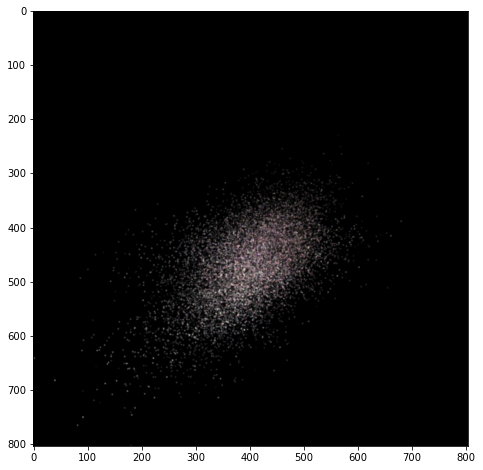

In-Silico Histology Examples - Y-axis


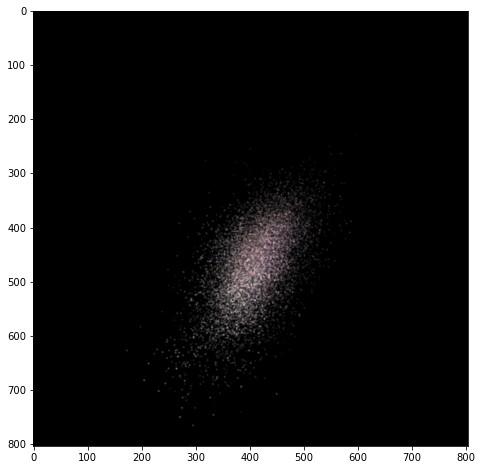

In-Silico Histology Examples - Z-axis


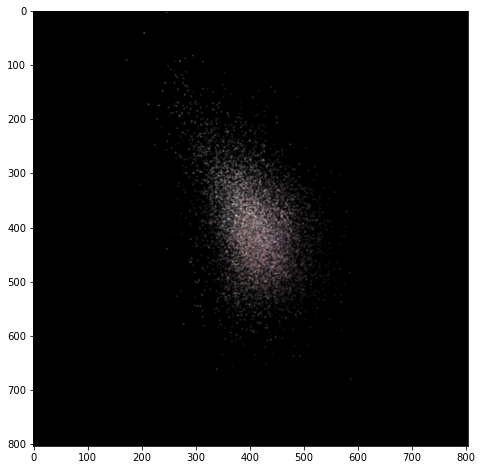

[4, 647.4403901100159, tensor([63962064.], grad_fn=<AddBackward0>)]
In-Silico Histology Examples - X-axis


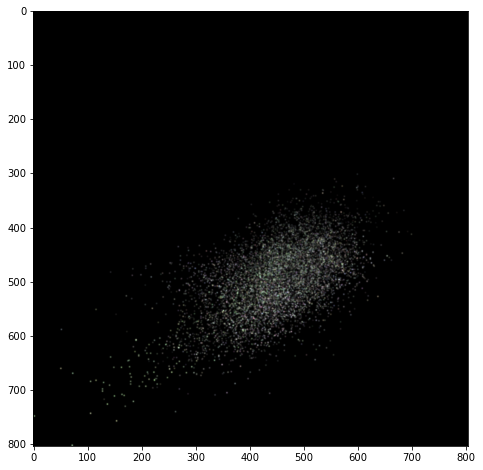

In-Silico Histology Examples - Y-axis


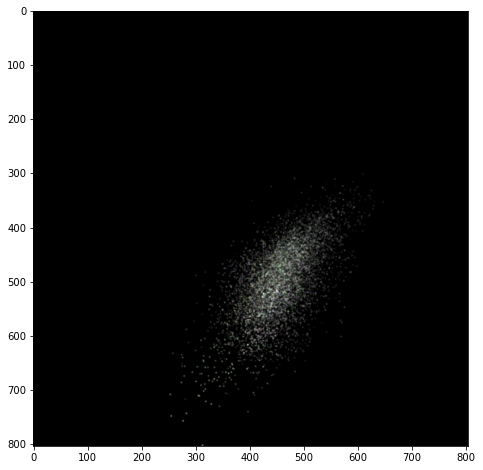

In-Silico Histology Examples - Z-axis


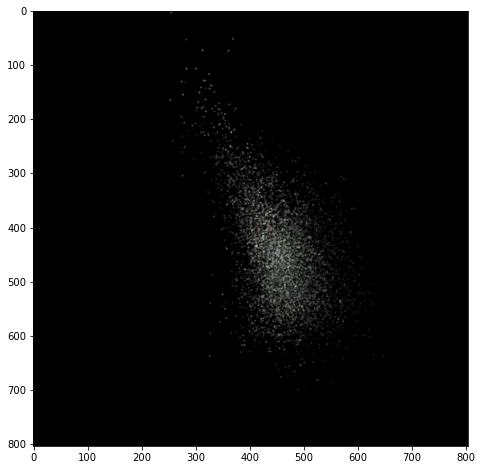

[9, 1284.704591035843, tensor([16633862.], grad_fn=<AddBackward0>)]
In-Silico Histology Examples - X-axis


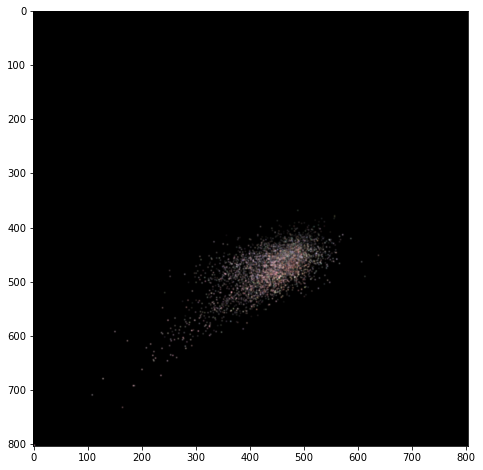

In-Silico Histology Examples - Y-axis


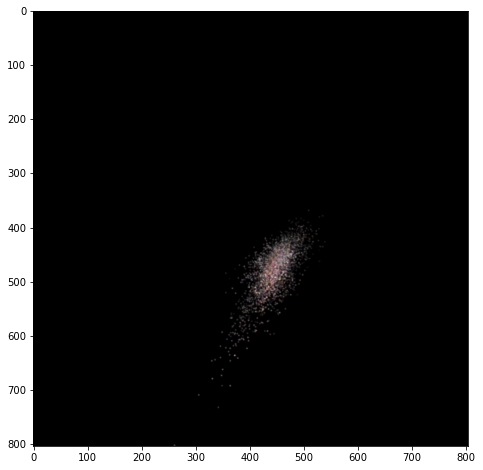

In-Silico Histology Examples - Z-axis


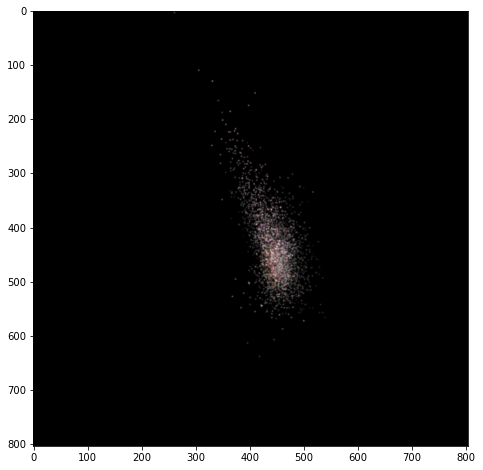

[14, 1918.635003566742, tensor([13981284.], grad_fn=<AddBackward0>)]
Finished Training


In [12]:
plt.rcParams['figure.figsize'] = (8, 8)
            
import time
import gc

start = time.time()

for epoch in range(15):  # loop over the dataset multiple times

    optimizer.zero_grad()
    grid_return_list, ST_list, spatial_gex_list = net(x_list,gex_list,pixel_list)
    
    
    
# Initialise loss


    loss = torch.zeros(1).to(device)
    
    x1 = grid_return_list[0][0]
    x2 = grid_return_list[0][1]
    for i in range(1,len(grid_return_list)):
    
    
    
# Loss function questions how accurate are cell distributions compared to training?


        loss += mseloss(grid_return_list[i][0][:,:2],GRID_list[i-1])
        
        x1 = torch.vstack((x1,grid_return_list[i][0]))
        x2 = torch.vstack((x2,grid_return_list[i][1]))

        
# Loss function questions whether the parameters for the new cell locations are actual signals?

    loss += mseloss(x1,x2)
    
    
    
# Loss function questions whether gene to pixel transformations are learned correctly?


    for i in range(len(gex_list)):
        loss += mseloss(gex_list[i],spatial_gex_list[i][0])+mseloss(gex_list[i],spatial_gex_list[i][1])

        
        
# Loss function questions whether pixel image prediction is aligned with reality on a:
# local predicted imaging spot level?


    for i in range(len(pixel_list)):
        loss += mseloss(pixel_list[i],ST_list[i+1][0])
    
    kde_grid_new = []
    
    for i in range(len(grid_return_list)):
        kde_grid_new += [[(to_kde_grid(M_list[i],(grid_return_list[i][0][:,:2].cpu().detach().numpy()),main_axis_size))]]        
        x_list[i] = to_samples(kde_grid_new[i][0],(grid_return_list[i][0][:,:2].cpu().detach().numpy()),w_size=window_size,type_data="tensor",modality="scMAP")

        
# Loss function questions whether pixel image prediction is aligned with reality on a:
# global predicted imaging tissue level?

        if i>0:
        
            main_histology = np.max((kde_grid_new[i][0].reshape([(main_axis_size+4*window_size)*(main_axis_size+4*window_size),len(genes)])@((spatial_gex_list[0][2].T).cpu().detach().numpy())).reshape([(main_axis_size+4*window_size),(main_axis_size+4*window_size),32,32,3]),(2,3))
            main_histology = (main_histology-np.min(main_histology))/np.max(main_histology-np.min(main_histology))

            loss += mseloss(torch.from_numpy(main_histology).float().to(device),TF.resize(torch.from_numpy(main_pixel_list[i-1]).permute([2,0,1]),((main_axis_size+4*window_size),(main_axis_size+4*window_size))).permute([1,2,0]))
                    
        if i == 0 and epoch%5==4:
            
            x = (to_kde_grid(M_list[i],(grid_return_list[i][0][:,[0,1]].cpu().detach().numpy()),main_axis_size))
            y = (to_kde_grid(M_list[i],(grid_return_list[i][0][:,[0,2]].cpu().detach().numpy()),main_axis_size))
            z = (to_kde_grid(M_list[i],(grid_return_list[i][0][:,[1,2]].cpu().detach().numpy()),main_axis_size))

            image_x = np.max((x.reshape([(main_axis_size+4*window_size)*(main_axis_size+4*window_size),len(genes)])@((spatial_gex_list[0][2].T).cpu().detach().numpy())).reshape([(main_axis_size+4*window_size),(main_axis_size+4*window_size),32,32,3]),(2,3))
            image_x = (image_x-np.min(image_x))/np.max(image_x-np.min(image_x))
            
            image_y = np.max((y.reshape([(main_axis_size+4*window_size)*(main_axis_size+4*window_size),len(genes)])@((spatial_gex_list[0][2].T).cpu().detach().numpy())).reshape([(main_axis_size+4*window_size),(main_axis_size+4*window_size),32,32,3]),(2,3))
            image_y = (image_y-np.min(image_y))/np.max(image_y-np.min(image_y))
            
            image_z = np.max((z.reshape([(main_axis_size+4*window_size)*(main_axis_size+4*window_size),len(genes)])@((spatial_gex_list[0][2].T).cpu().detach().numpy())).reshape([(main_axis_size+4*window_size),(main_axis_size+4*window_size),32,32,3]),(2,3))
            image_z = (image_z-np.min(image_z))/np.max(image_z-np.min(image_z))

            print("In-Silico Histology Examples - X-axis")
            plt.imshow(image_x)
            plt.show()
            
            print("In-Silico Histology Examples - Y-axis")
            plt.imshow(image_y)
            plt.show()
            
            print("In-Silico Histology Examples - Z-axis")
            plt.imshow(image_z)
            plt.show()
                
        else:
            
            
            
# Loss function questions whether the movement of cells around fits well with the idea of Waddington's marble analogy?


            loss += mseloss(x_list[i],to_samples(kde_grid_new[i][0],(grid_return_list[i][0][:,:2].cpu().detach().numpy()),w_size=window_size,type_data="tensor",modality="scMAP"))
            
        
        
    del grid_return_list, ST_list, spatial_gex_list 
    gc.collect()
    
    loss.backward()
    optimizer.step()
    
    end = time.time()
    if epoch%5==4:
        print([epoch,end - start,loss])

print('Finished Training')


In-Silico Histology Examples - X-axis


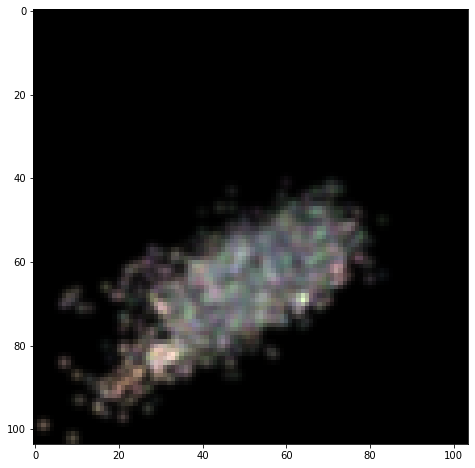

In-Silico Histology Examples - Y-axis


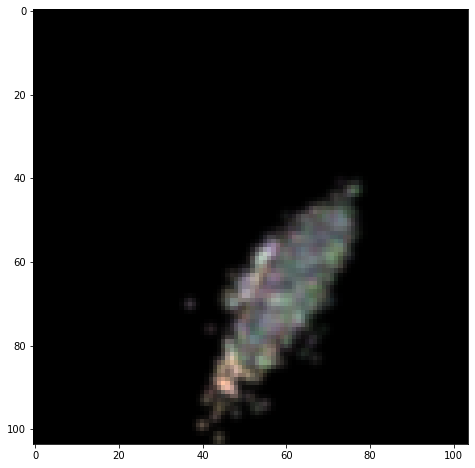

In-Silico Histology Examples - Z-axis


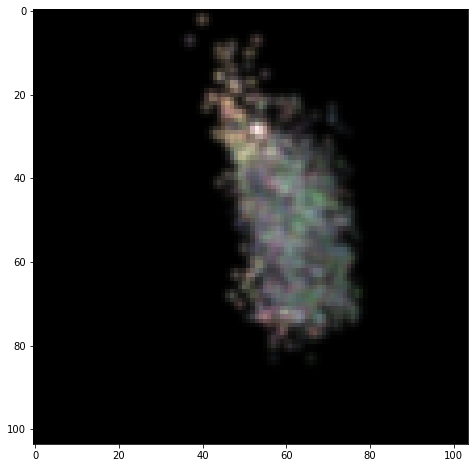

Re-predicted images of Histology training dataset


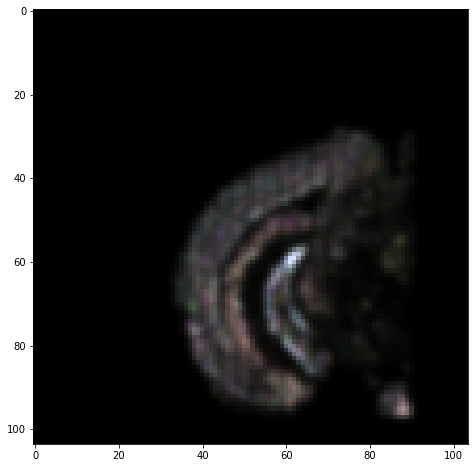

Re-predicted images of Histology training dataset


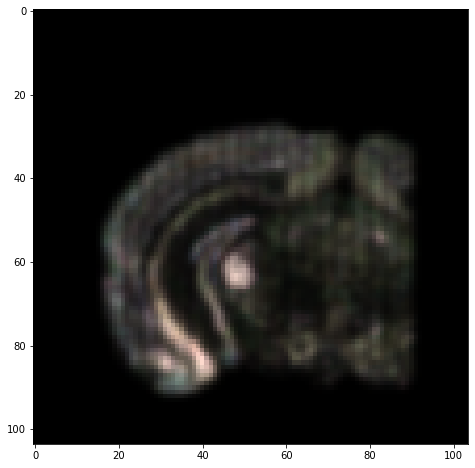

Re-predicted images of Histology training dataset


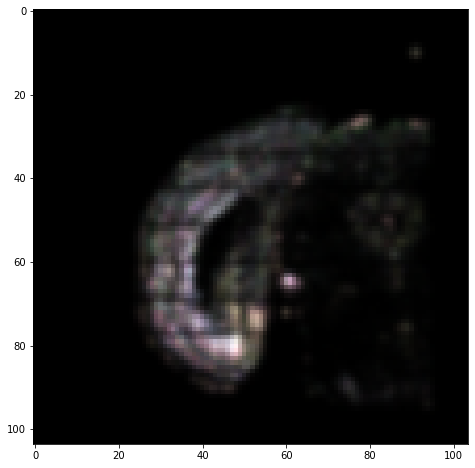

Re-predicted images of Histology training dataset


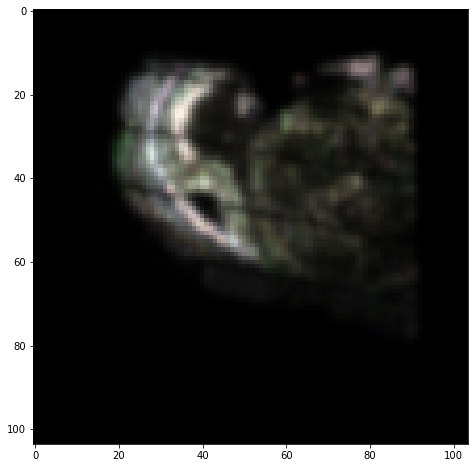

Plotting in-silico ST data via loss function optimisation through learning proper gene to pixel transformations and cell placement via KNN gene convolutions
Calb1
Real GEX


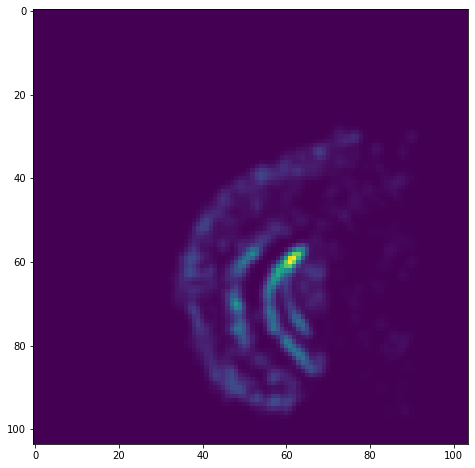

In-Silico GEX - X-axis


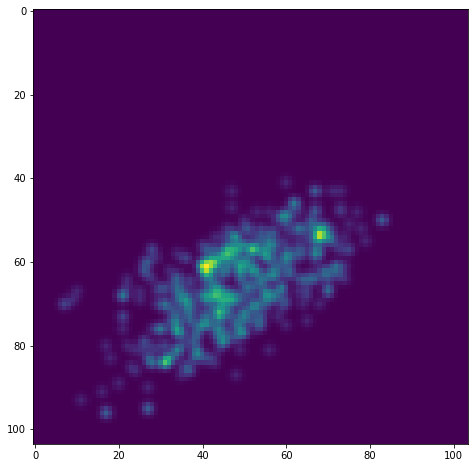

In-Silico GEX - Y-axis


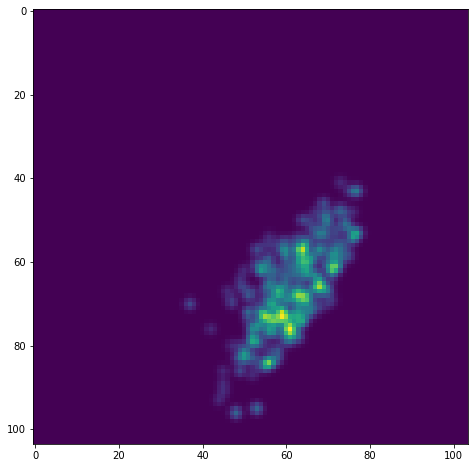

In-Silico GEX - Z-axis


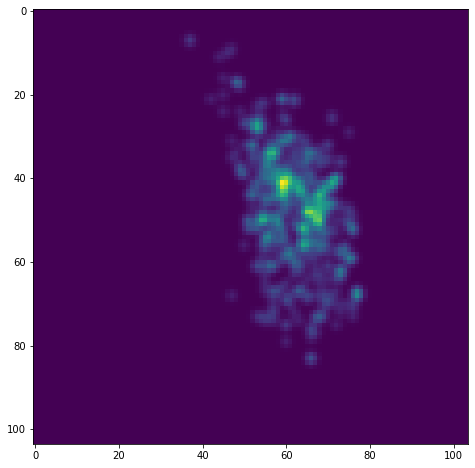

Rasgrf2
Real GEX


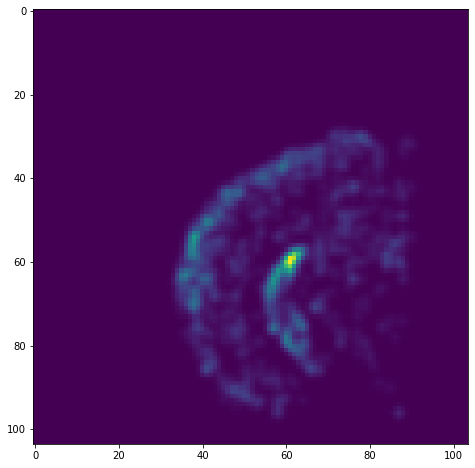

In-Silico GEX - X-axis


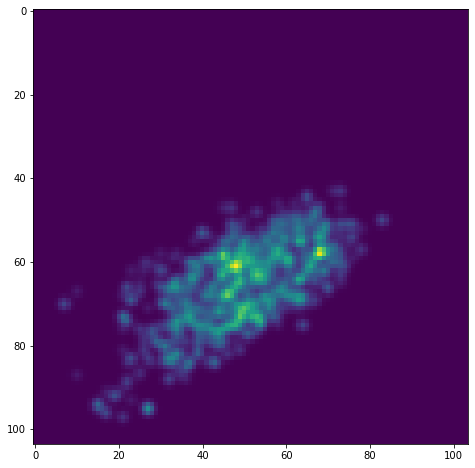

In-Silico GEX - Y-axis


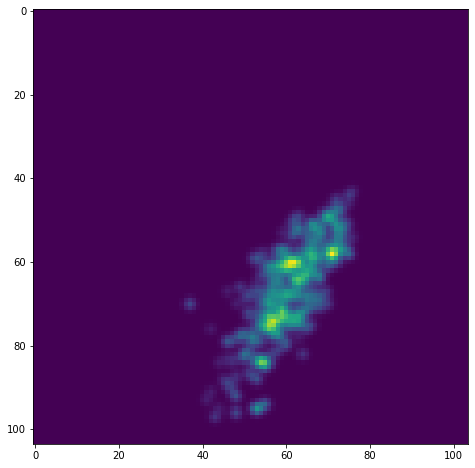

In-Silico GEX - Z-axis


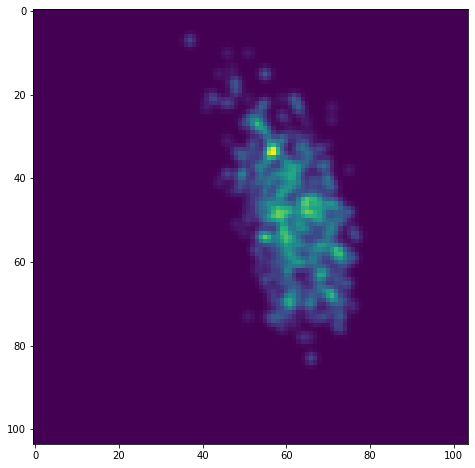

Enpp2
Real GEX


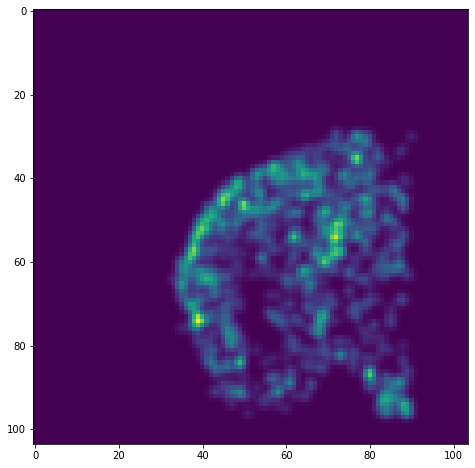

In-Silico GEX - X-axis


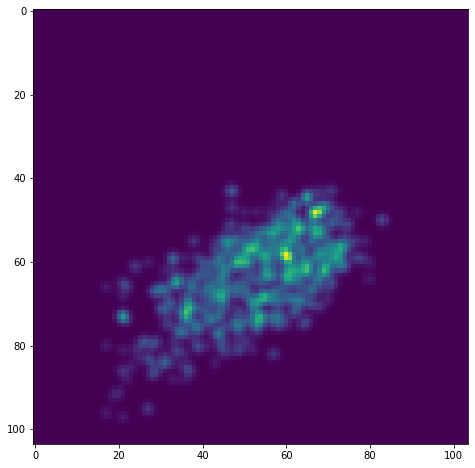

In-Silico GEX - Y-axis


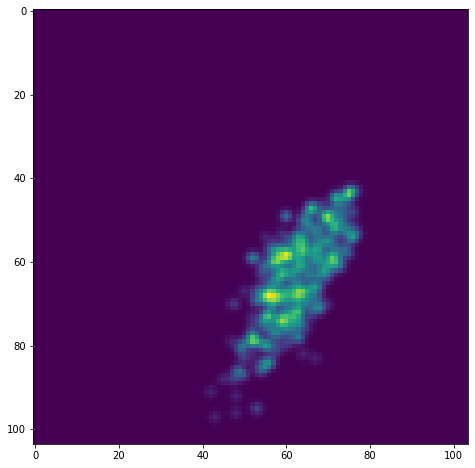

In-Silico GEX - Z-axis


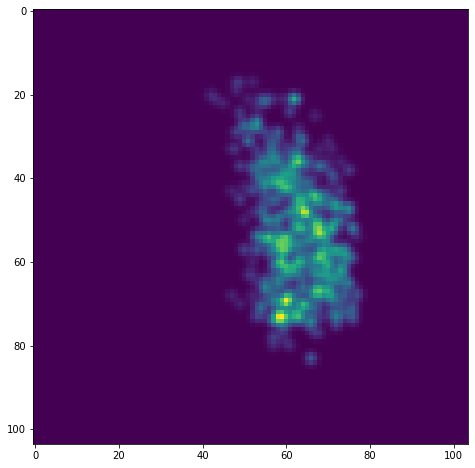

Col19a1
Real GEX


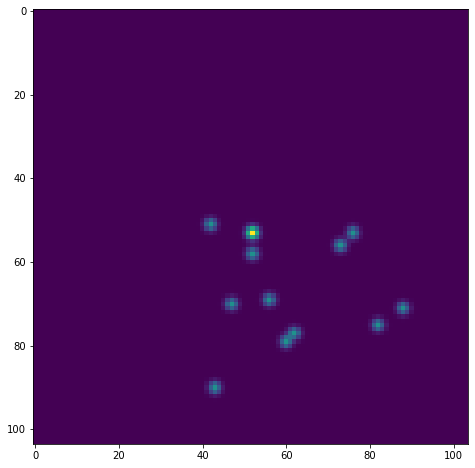

In-Silico GEX - X-axis


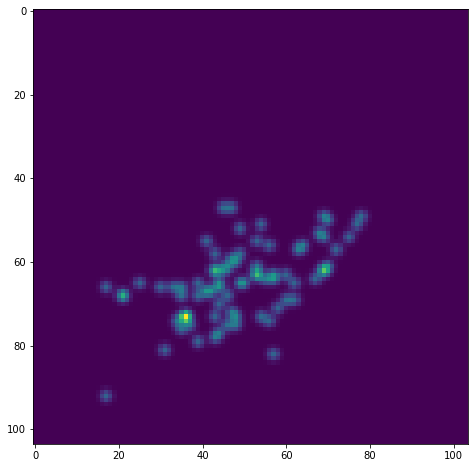

In-Silico GEX - Y-axis


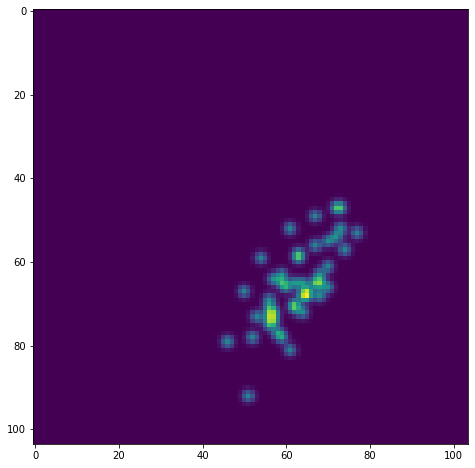

In-Silico GEX - Z-axis


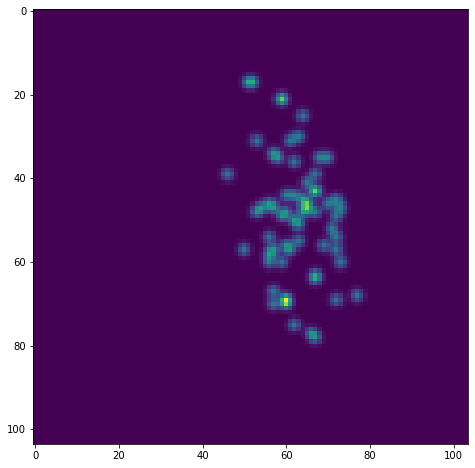

Rorb
Real GEX


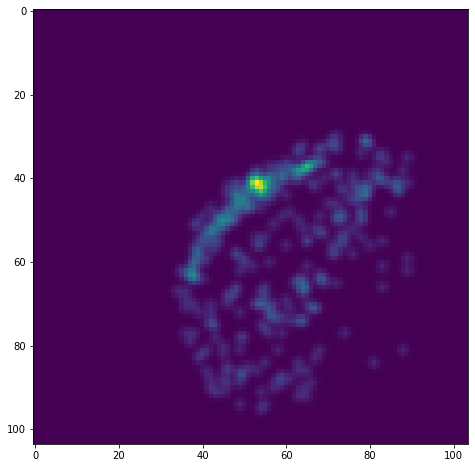

In-Silico GEX - X-axis


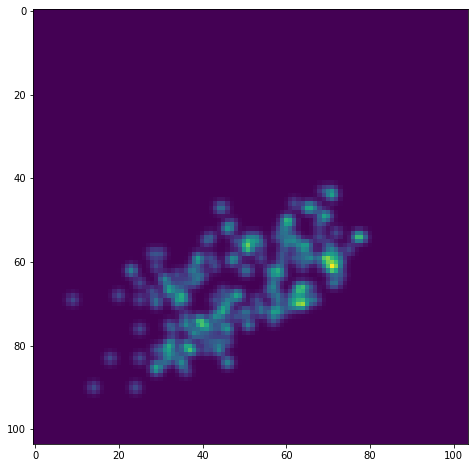

In-Silico GEX - Y-axis


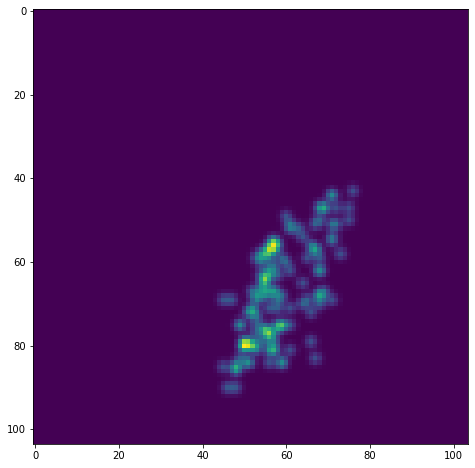

In-Silico GEX - Z-axis


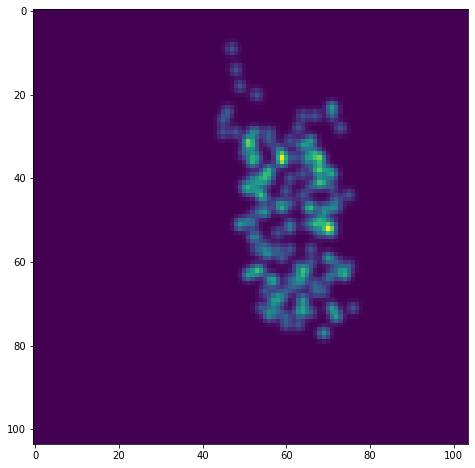

Slc24a3
Real GEX


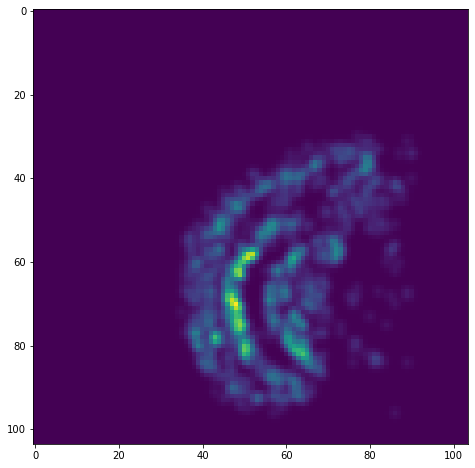

In-Silico GEX - X-axis


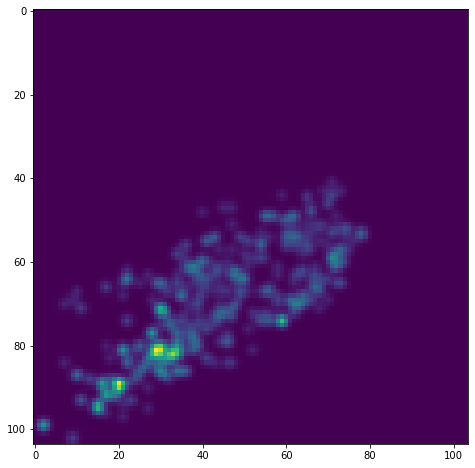

In-Silico GEX - Y-axis


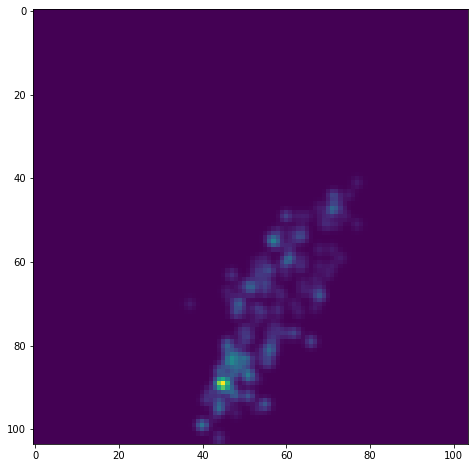

In-Silico GEX - Z-axis


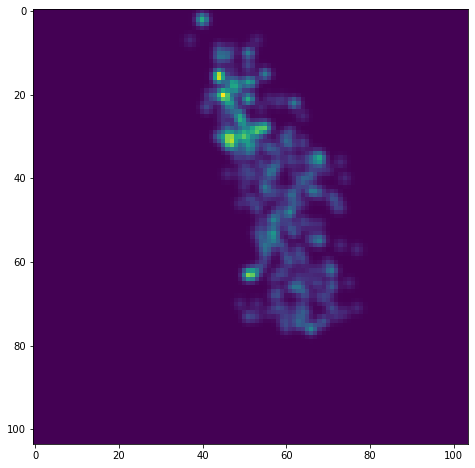

Galntl6
Real GEX


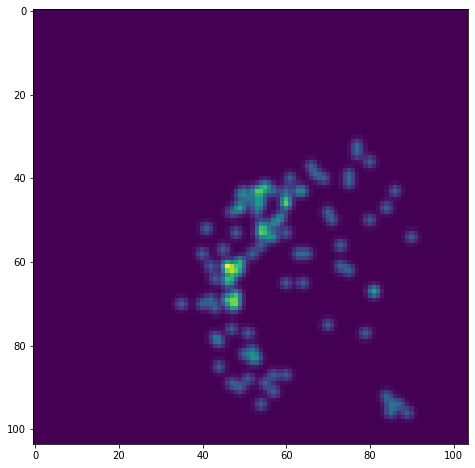

In-Silico GEX - X-axis


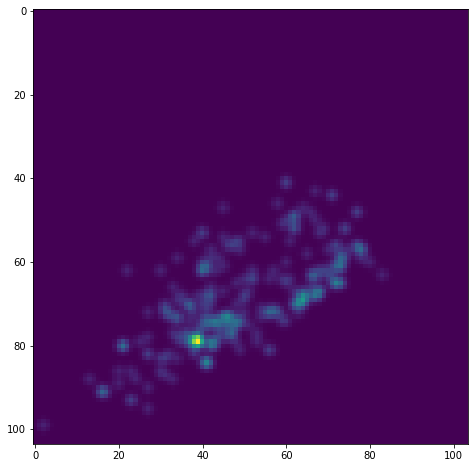

In-Silico GEX - Y-axis


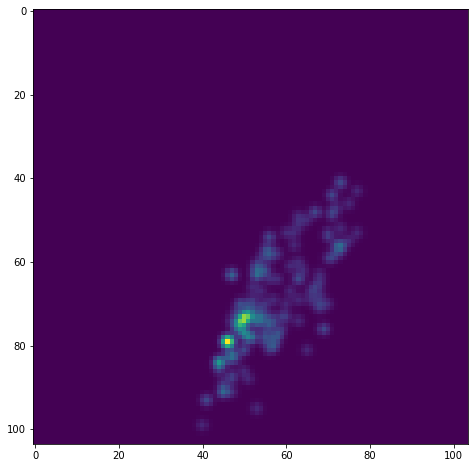

In-Silico GEX - Z-axis


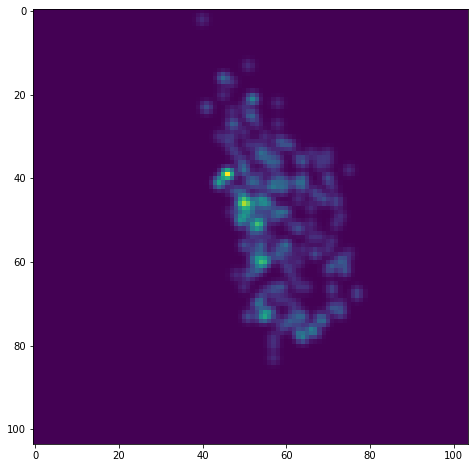

Il1rapl2
Real GEX


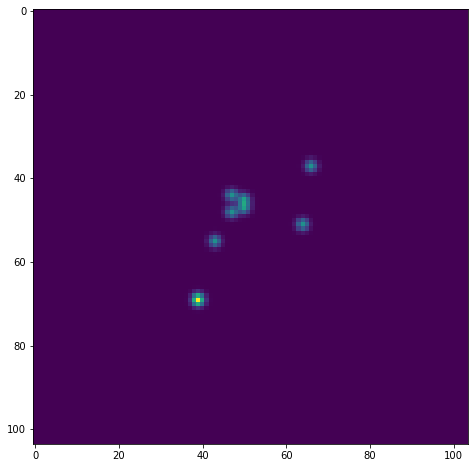

In-Silico GEX - X-axis


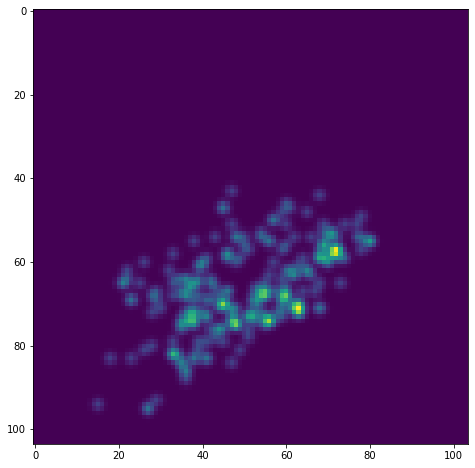

In-Silico GEX - Y-axis


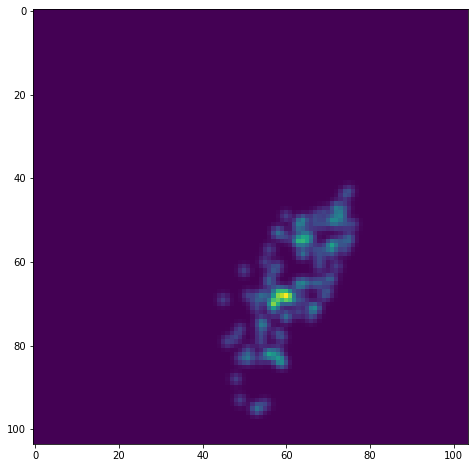

In-Silico GEX - Z-axis


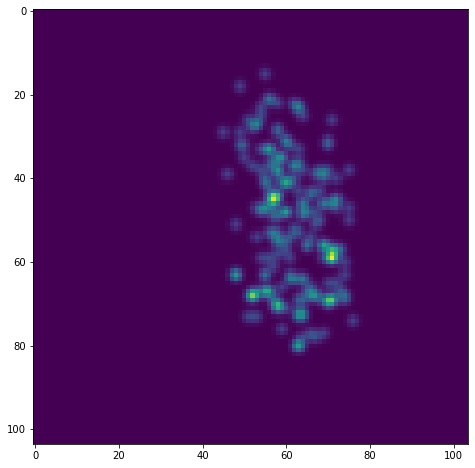

Galnt14
Real GEX


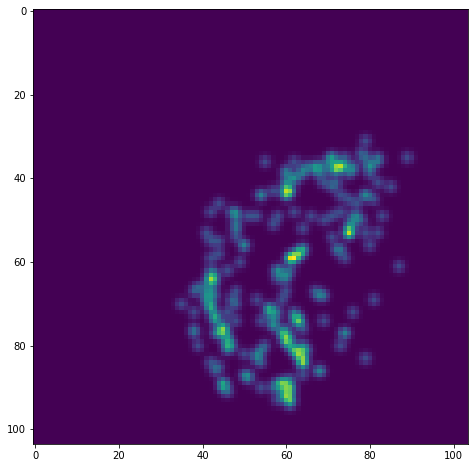

In-Silico GEX - X-axis


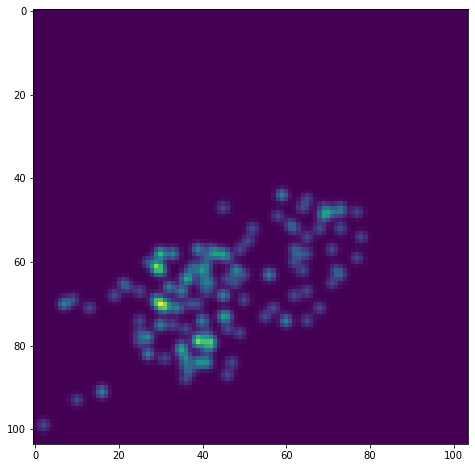

In-Silico GEX - Y-axis


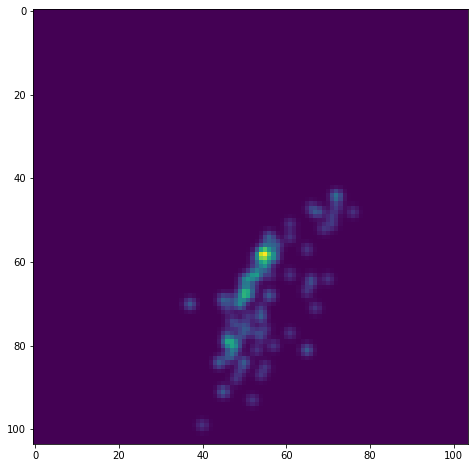

In-Silico GEX - Z-axis


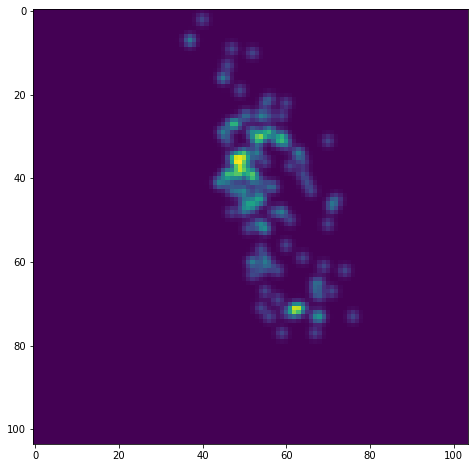

Cdh9
Real GEX


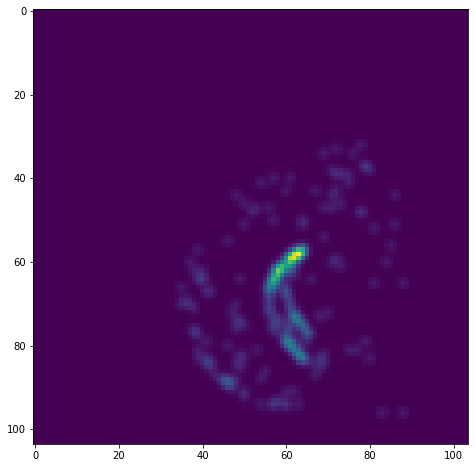

In-Silico GEX - X-axis


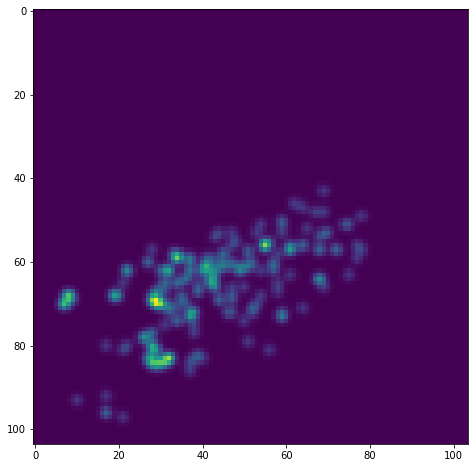

In-Silico GEX - Y-axis


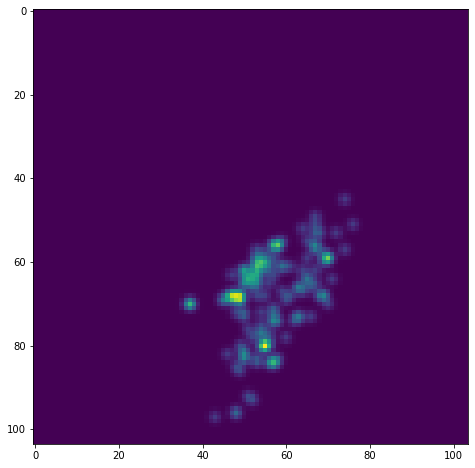

In-Silico GEX - Z-axis


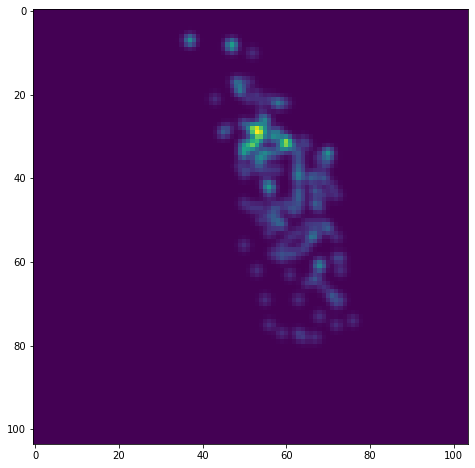

Rasl10a
Real GEX


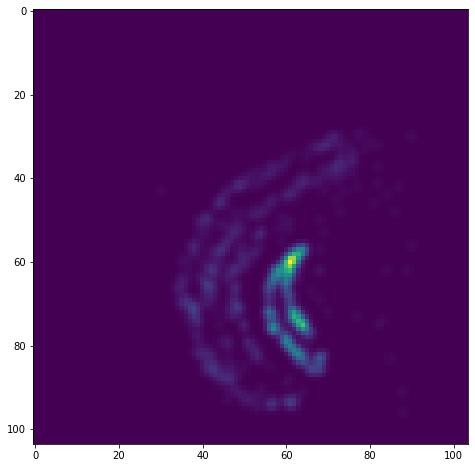

In-Silico GEX - X-axis


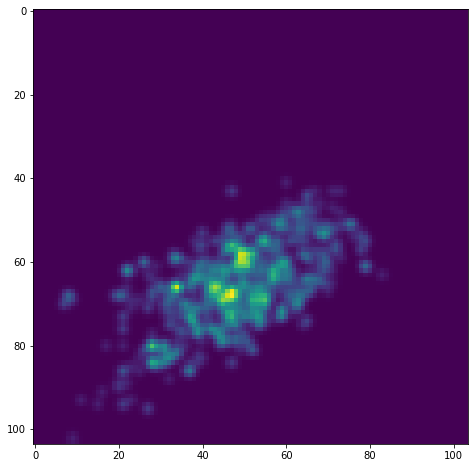

In-Silico GEX - Y-axis


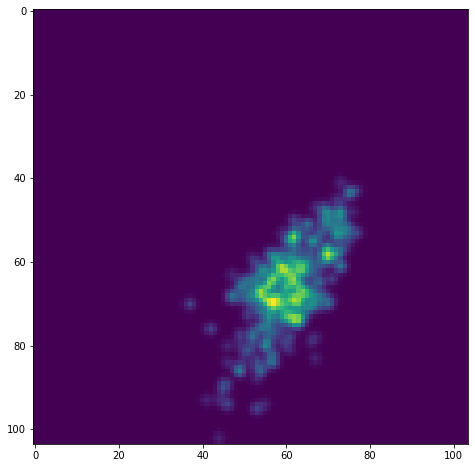

In-Silico GEX - Z-axis


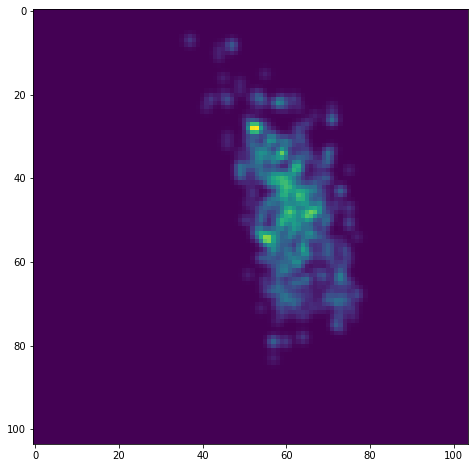

Sorcs3
Real GEX


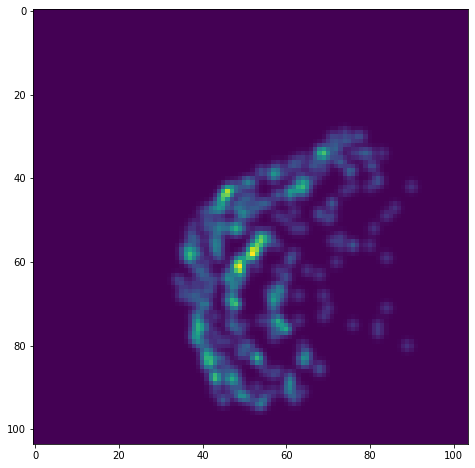

In-Silico GEX - X-axis


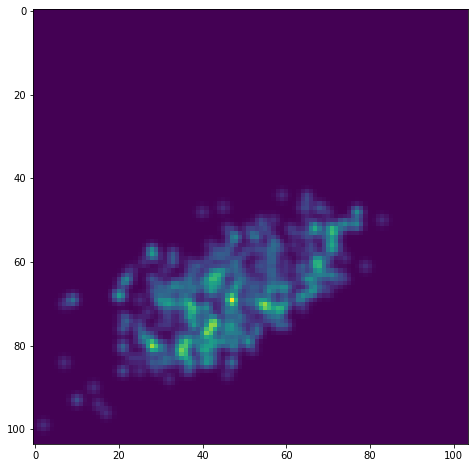

In-Silico GEX - Y-axis


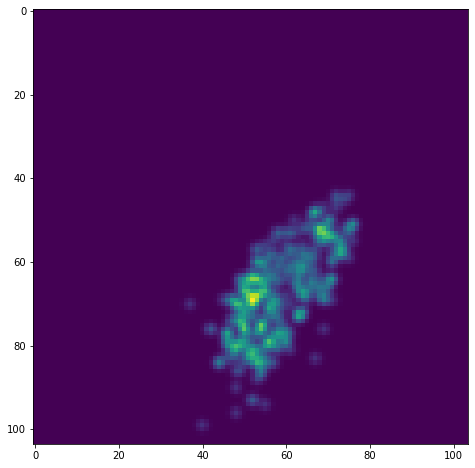

In-Silico GEX - Z-axis


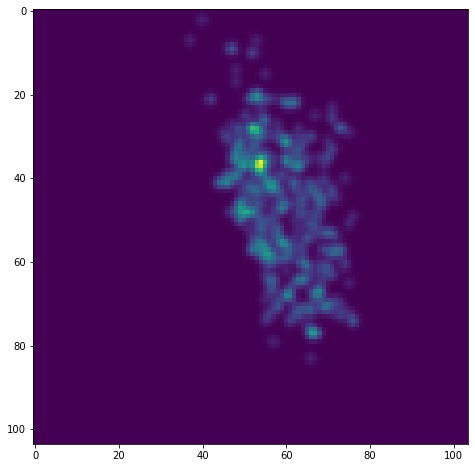

Sdk1
Real GEX


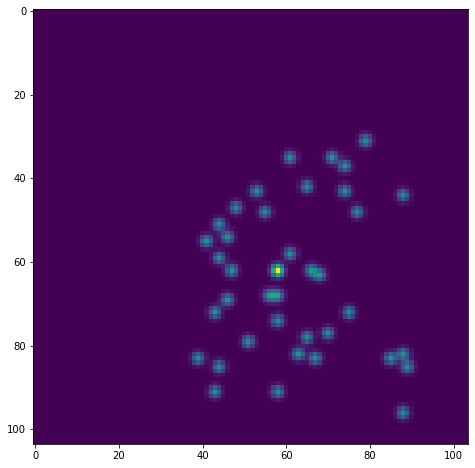

In-Silico GEX - X-axis


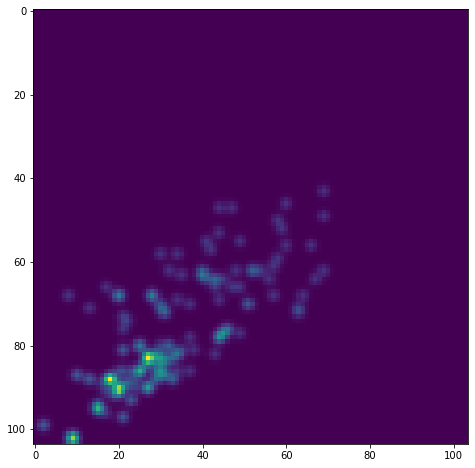

In-Silico GEX - Y-axis


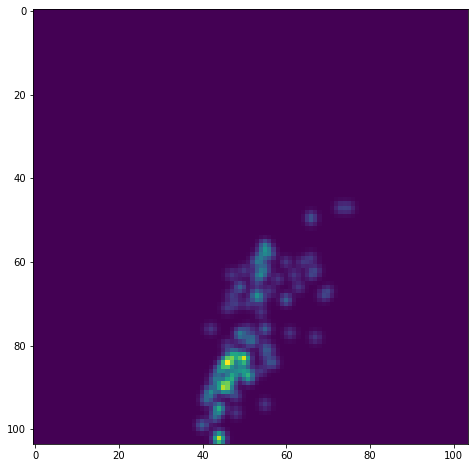

In-Silico GEX - Z-axis


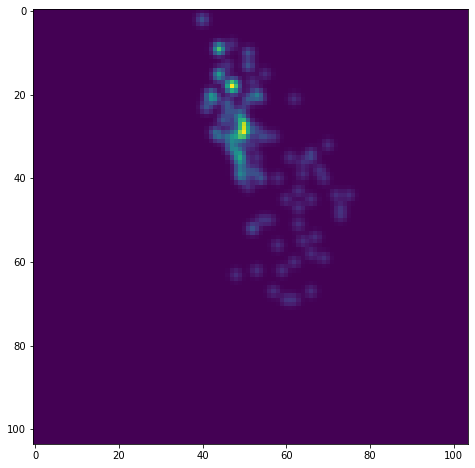

Nr4a2
Real GEX


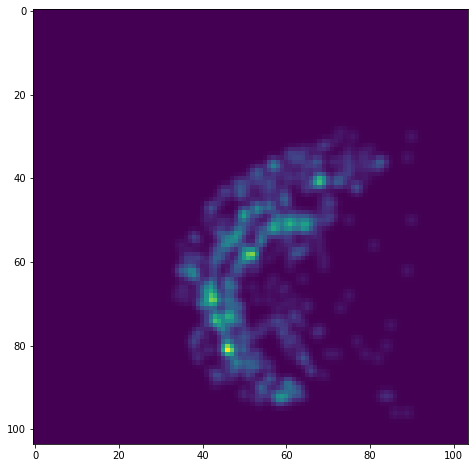

In-Silico GEX - X-axis


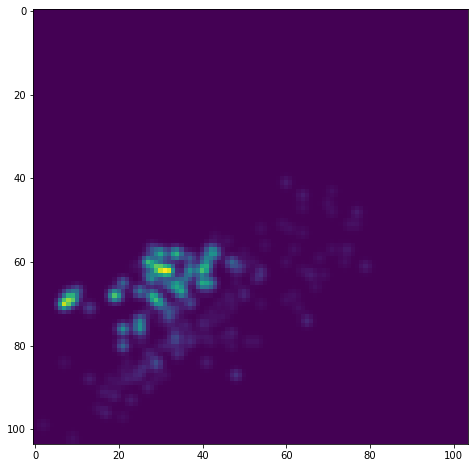

In-Silico GEX - Y-axis


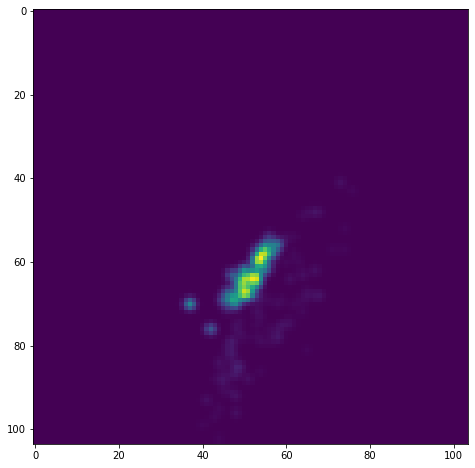

In-Silico GEX - Z-axis


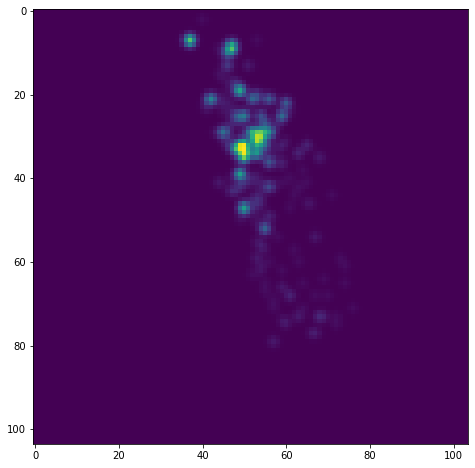

Gfra1
Real GEX


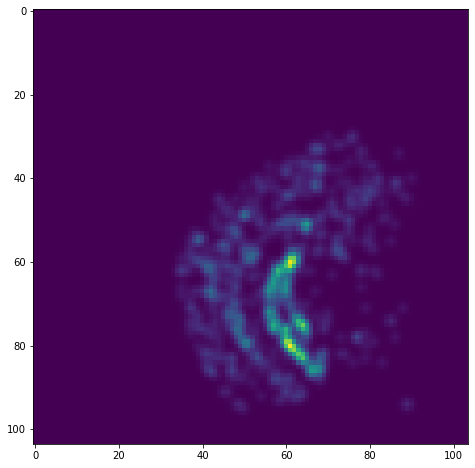

In-Silico GEX - X-axis


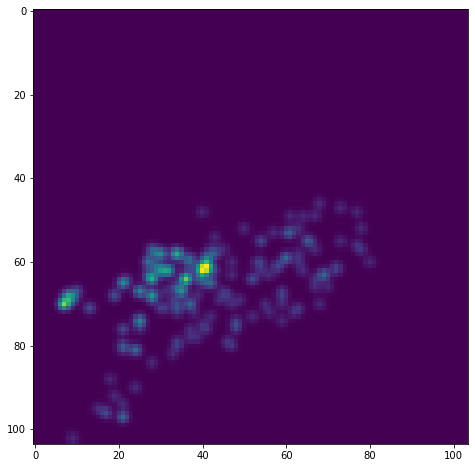

In-Silico GEX - Y-axis


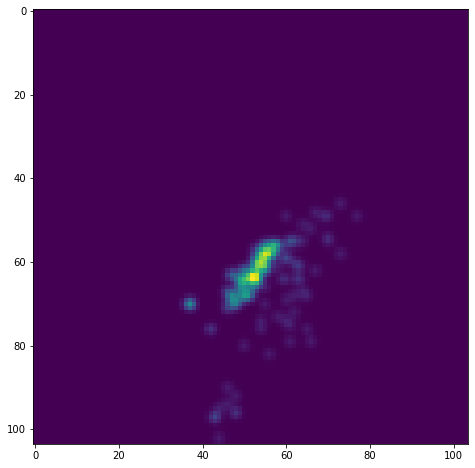

In-Silico GEX - Z-axis


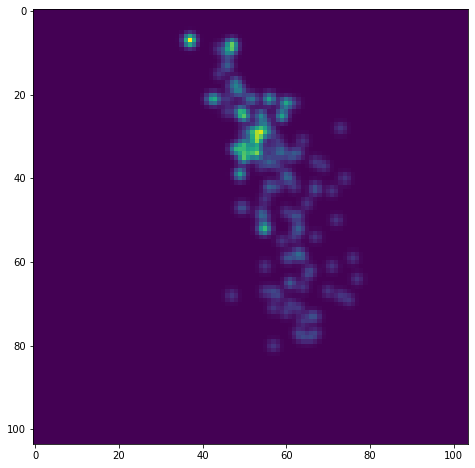

Oprk1
Real GEX


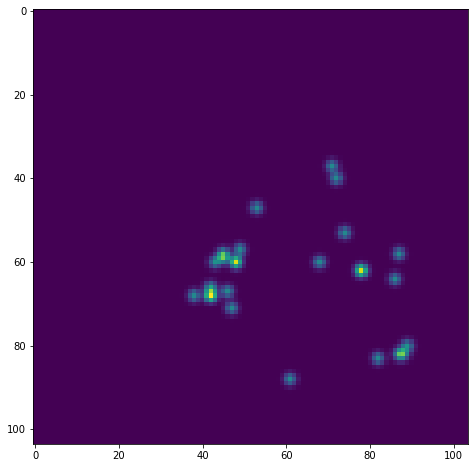

In-Silico GEX - X-axis


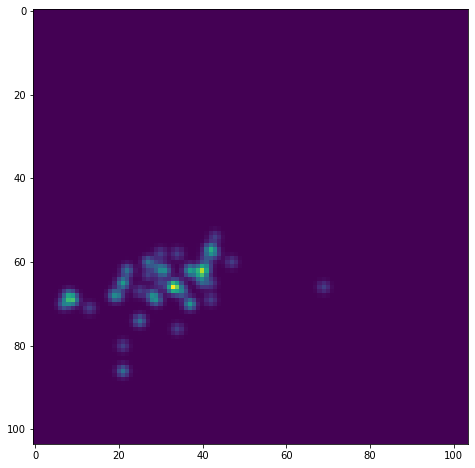

In-Silico GEX - Y-axis


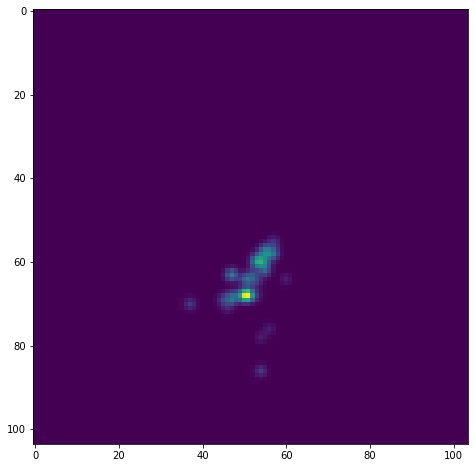

In-Silico GEX - Z-axis


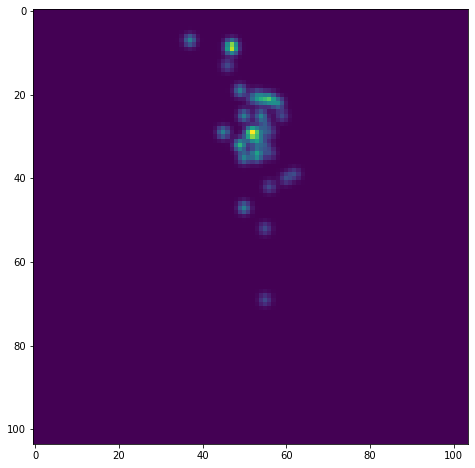

Col11a1
Real GEX


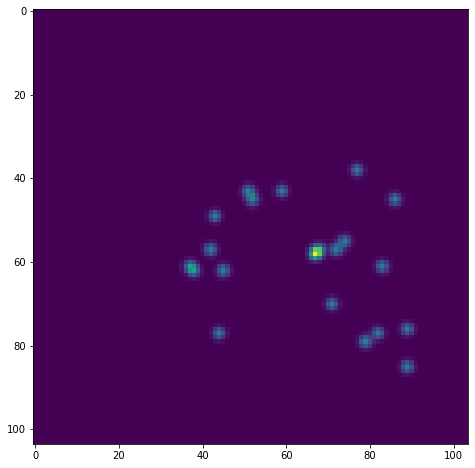

In-Silico GEX - X-axis


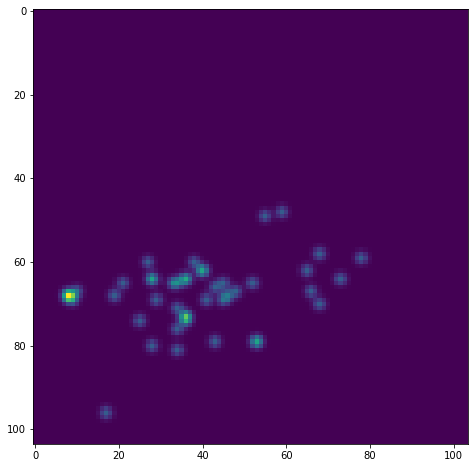

In-Silico GEX - Y-axis


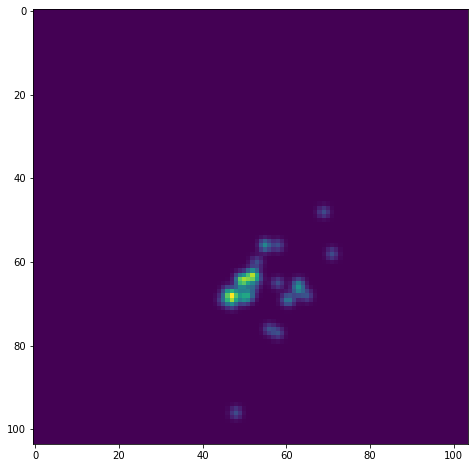

In-Silico GEX - Z-axis


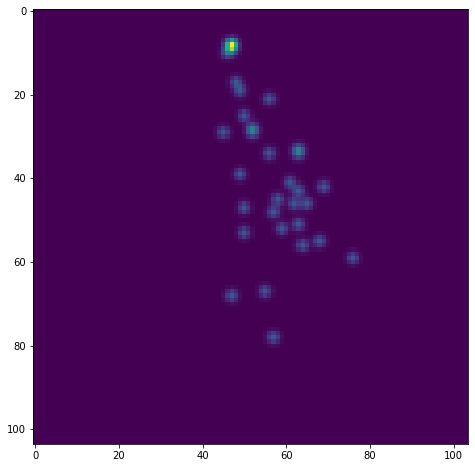

Synpr
Real GEX


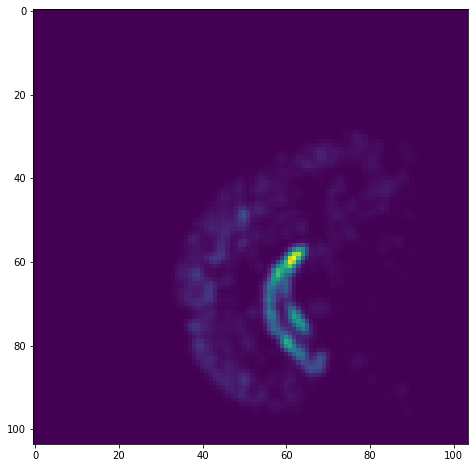

In-Silico GEX - X-axis


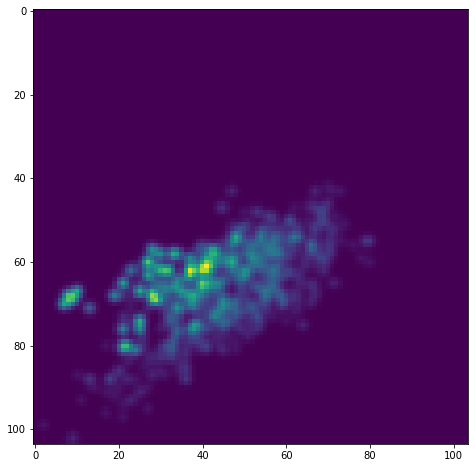

In-Silico GEX - Y-axis


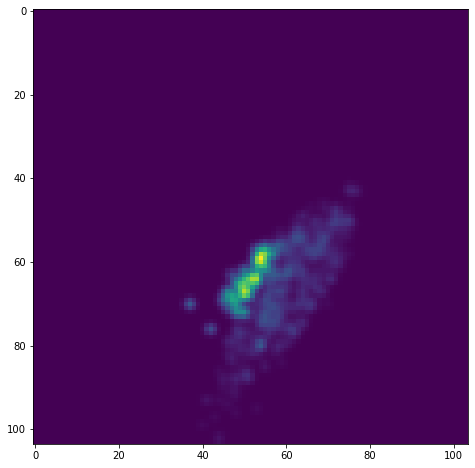

In-Silico GEX - Z-axis


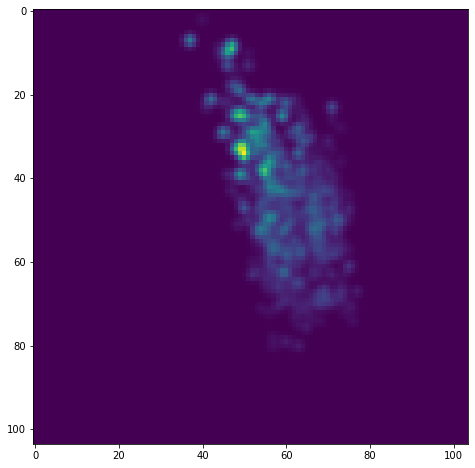

Tshz2
Real GEX


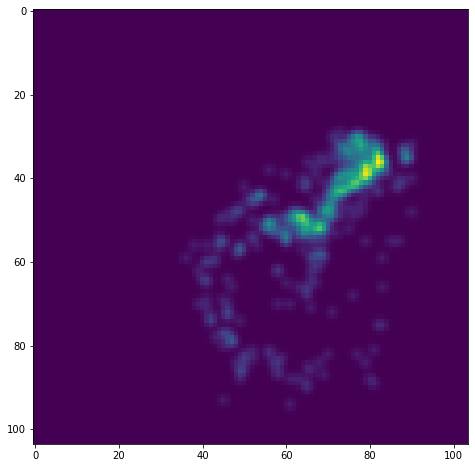

In-Silico GEX - X-axis


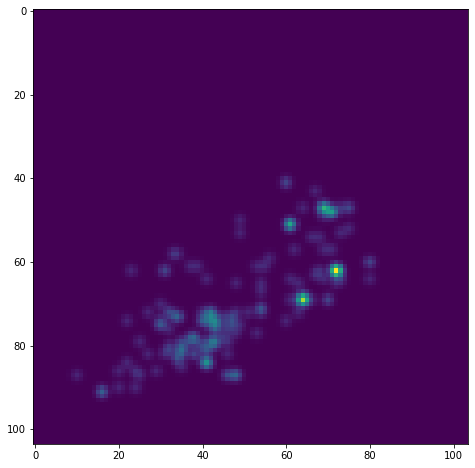

In-Silico GEX - Y-axis


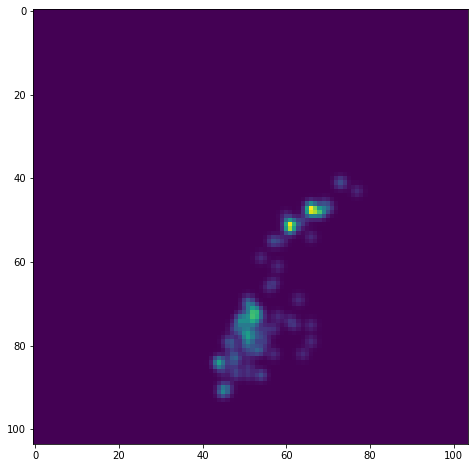

In-Silico GEX - Z-axis


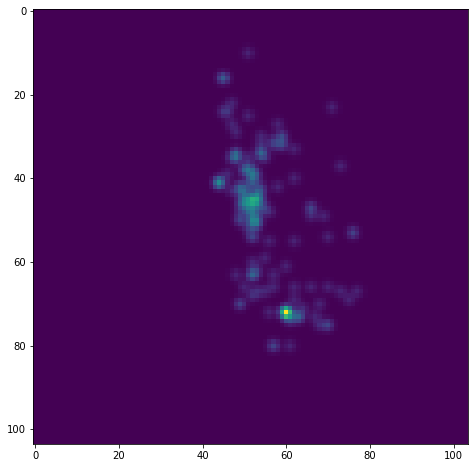

Nxph1
Real GEX


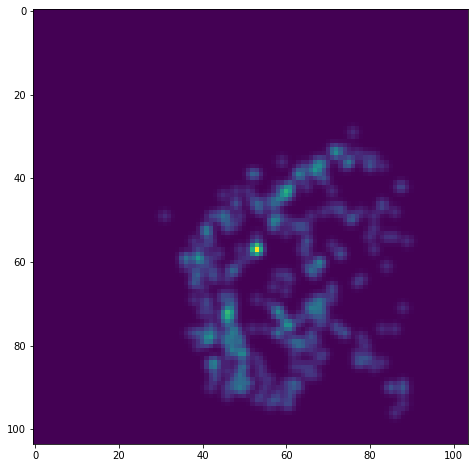

In-Silico GEX - X-axis


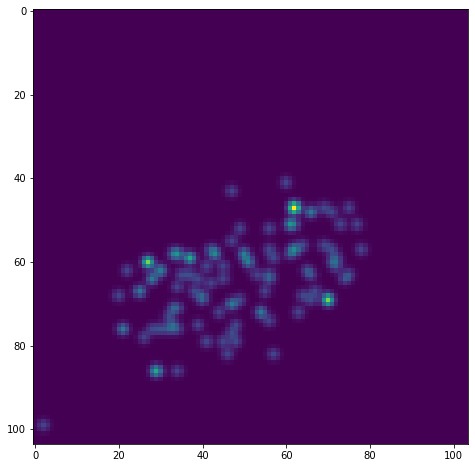

In-Silico GEX - Y-axis


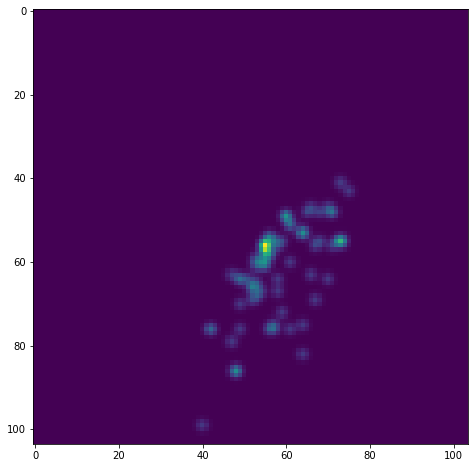

In-Silico GEX - Z-axis


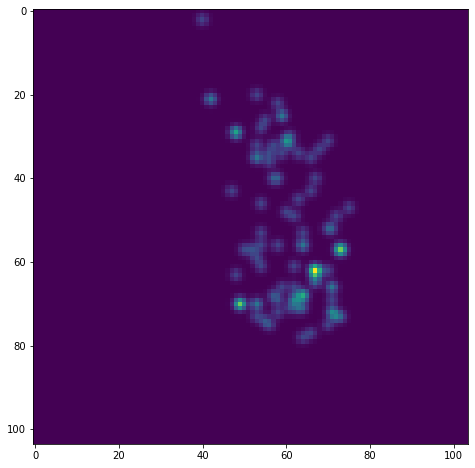

Kcnip1
Real GEX


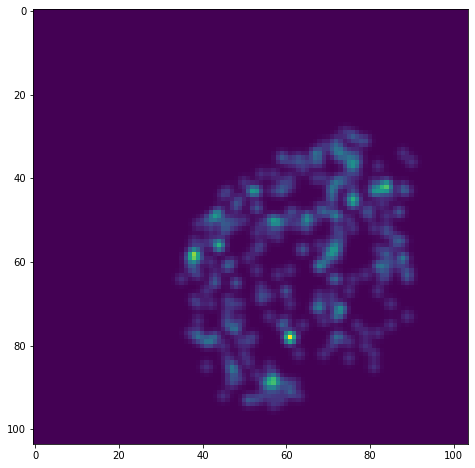

In-Silico GEX - X-axis


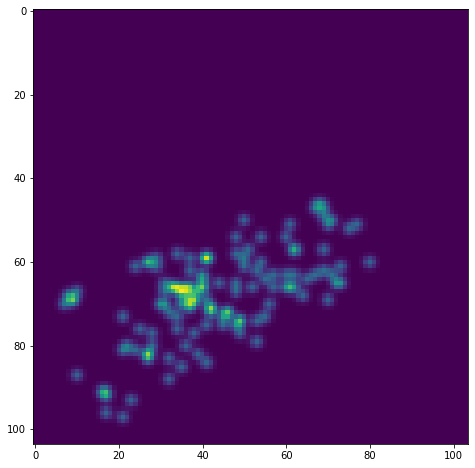

In-Silico GEX - Y-axis


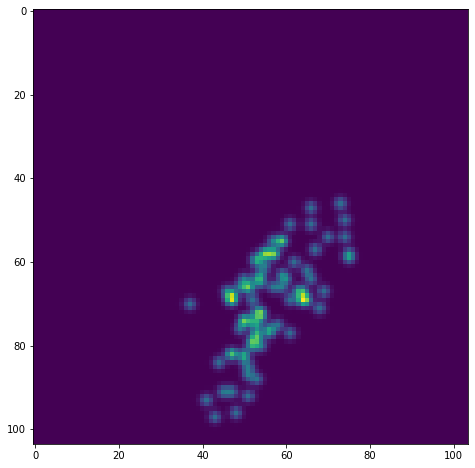

In-Silico GEX - Z-axis


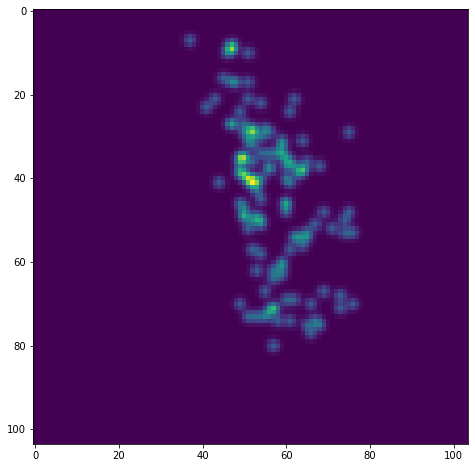

Grik1
Real GEX


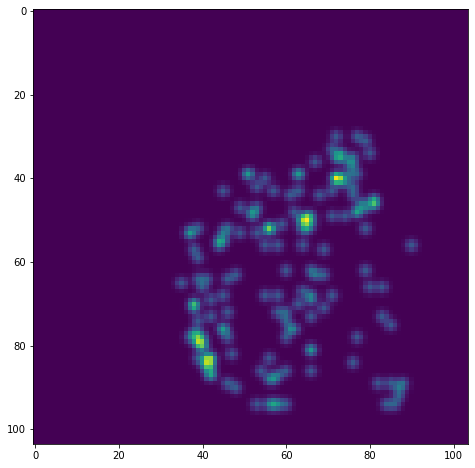

In-Silico GEX - X-axis


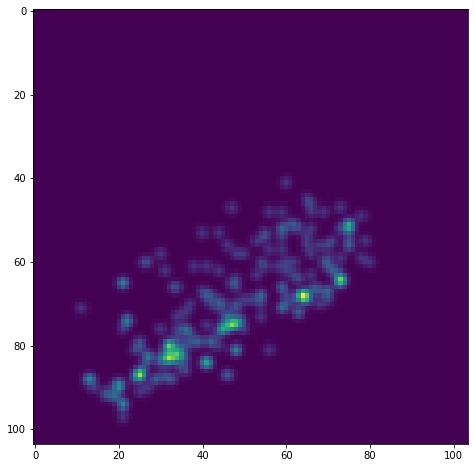

In-Silico GEX - Y-axis


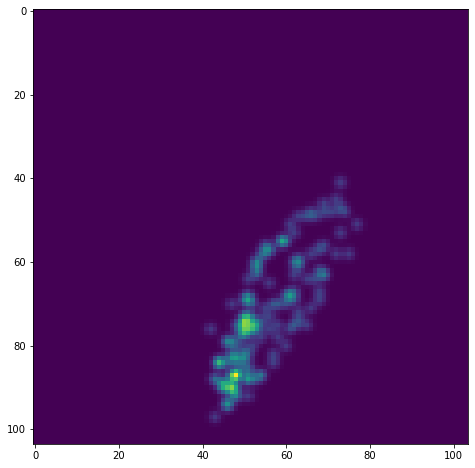

In-Silico GEX - Z-axis


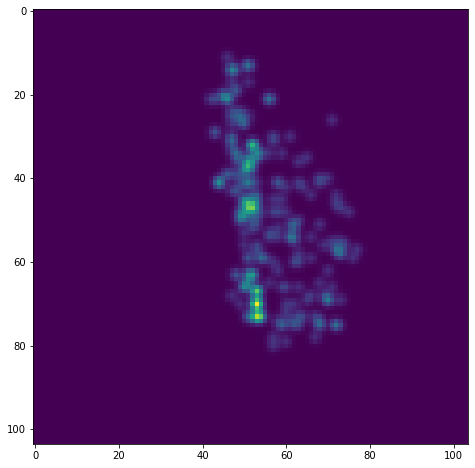

Vwc2l
Real GEX


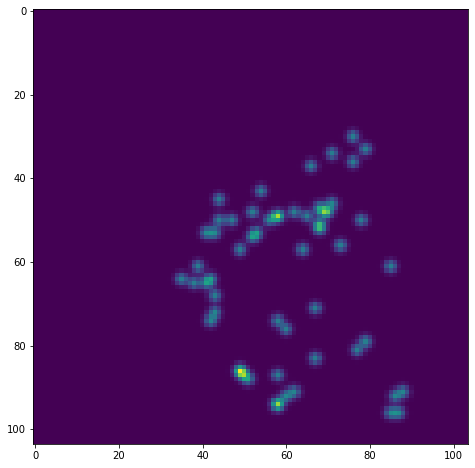

In-Silico GEX - X-axis


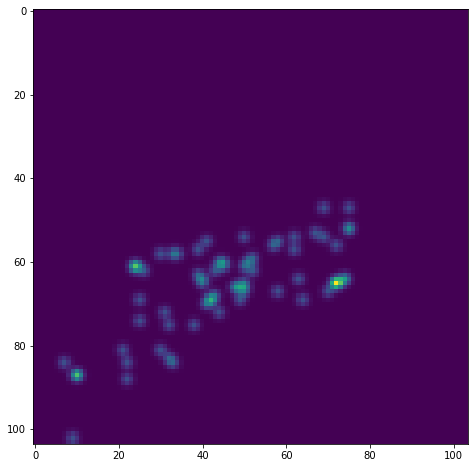

In-Silico GEX - Y-axis


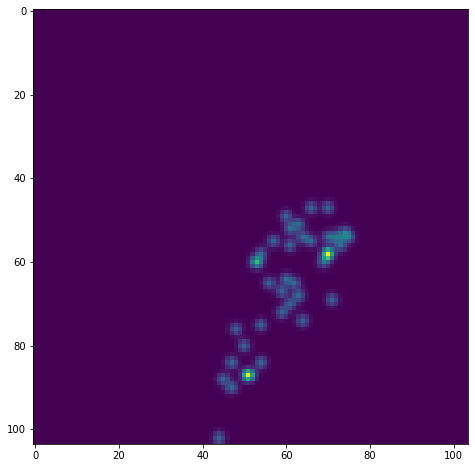

In-Silico GEX - Z-axis


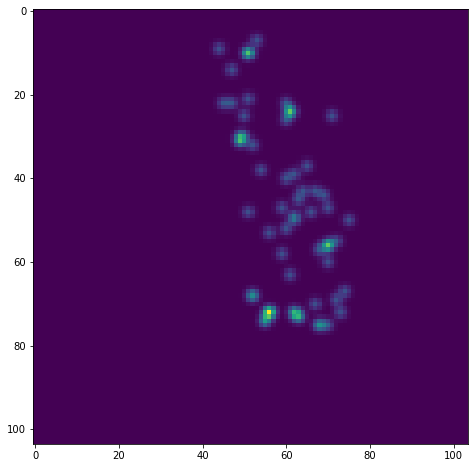

Coro6
Real GEX


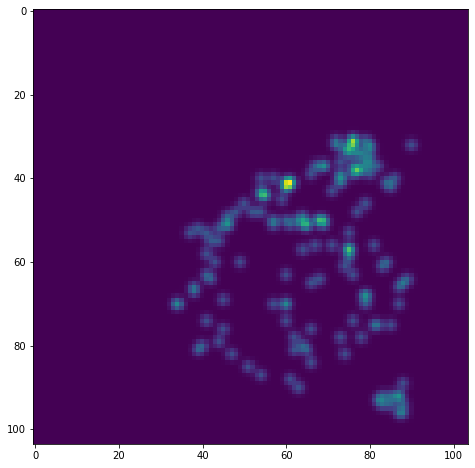

In-Silico GEX - X-axis


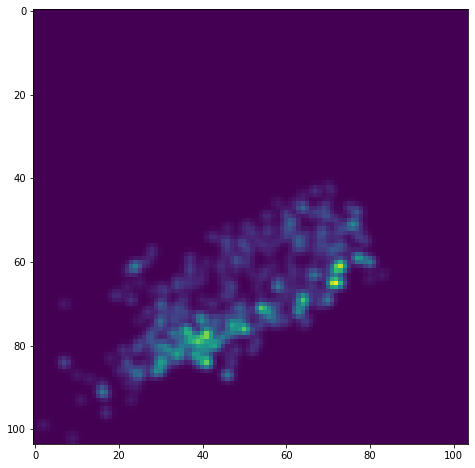

In-Silico GEX - Y-axis


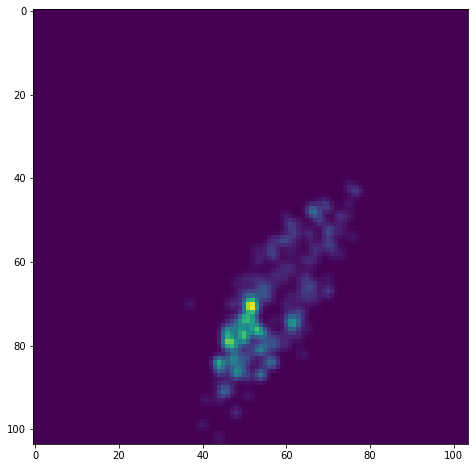

In-Silico GEX - Z-axis


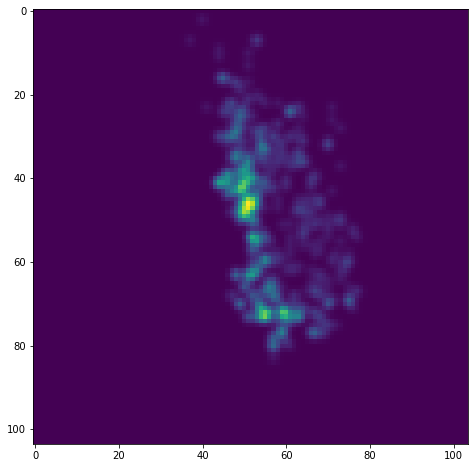

Lpp
Real GEX


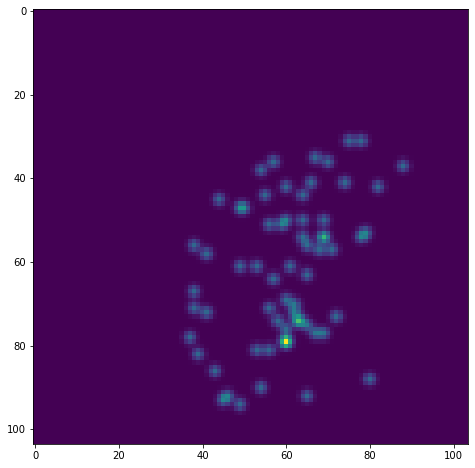

In-Silico GEX - X-axis


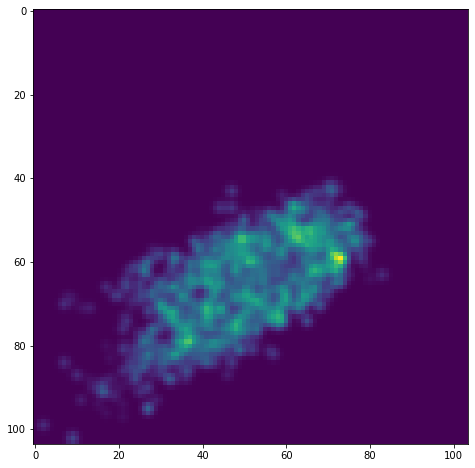

In-Silico GEX - Y-axis


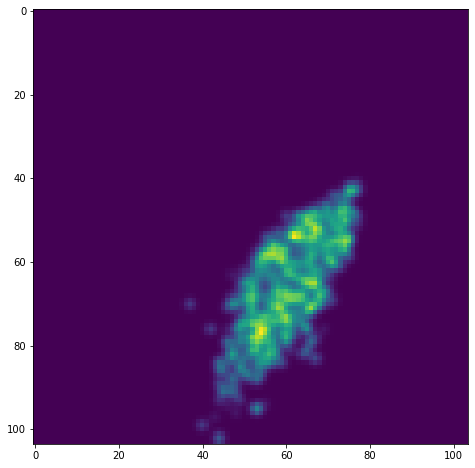

In-Silico GEX - Z-axis


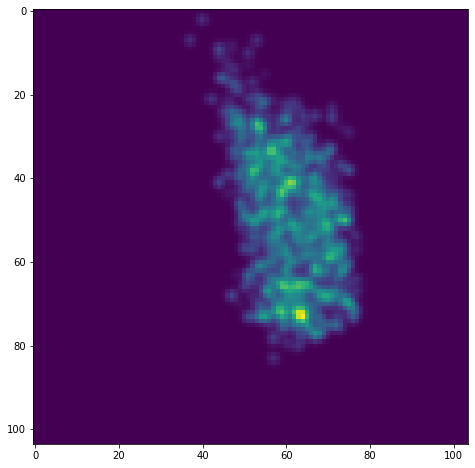

Kcnn2
Real GEX


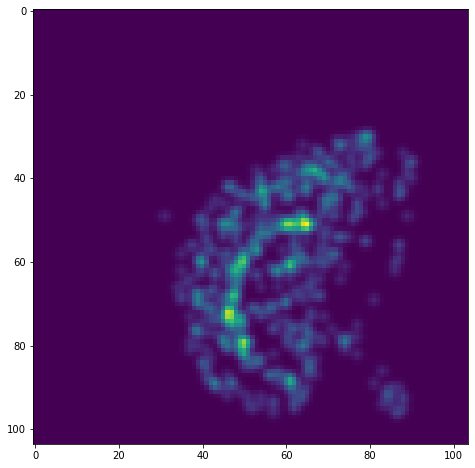

In-Silico GEX - X-axis


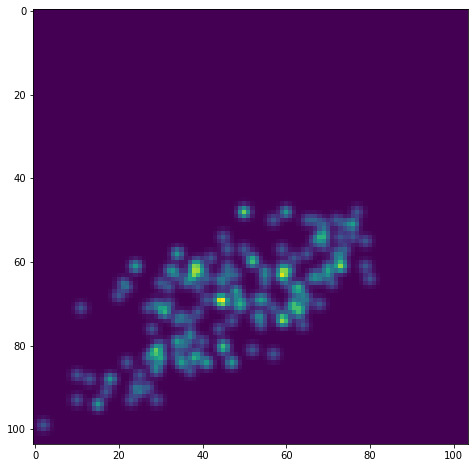

In-Silico GEX - Y-axis


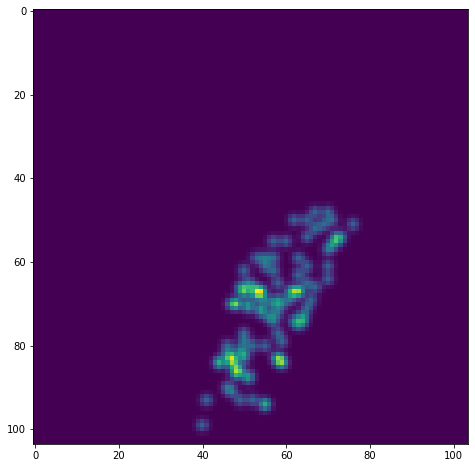

In-Silico GEX - Z-axis


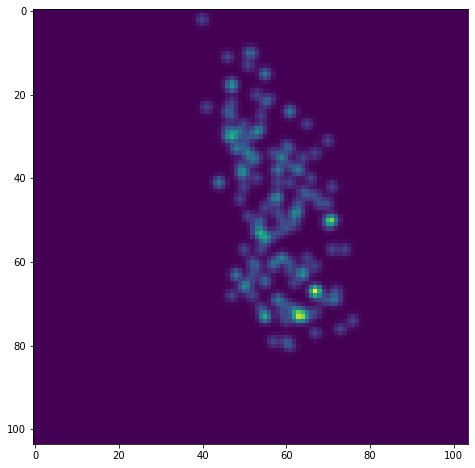

Rab3c
Real GEX


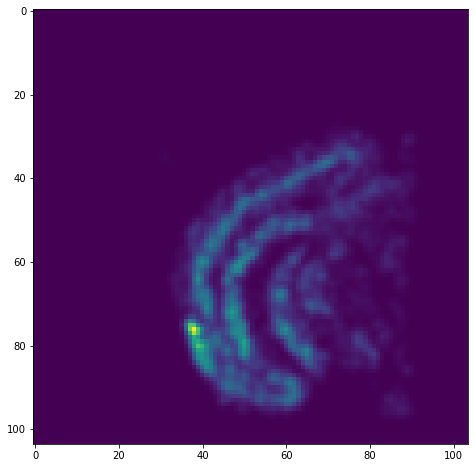

In-Silico GEX - X-axis


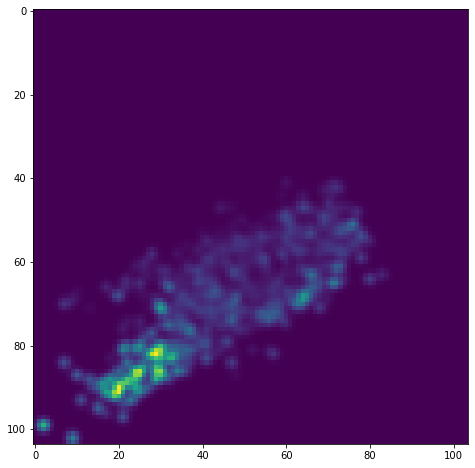

In-Silico GEX - Y-axis


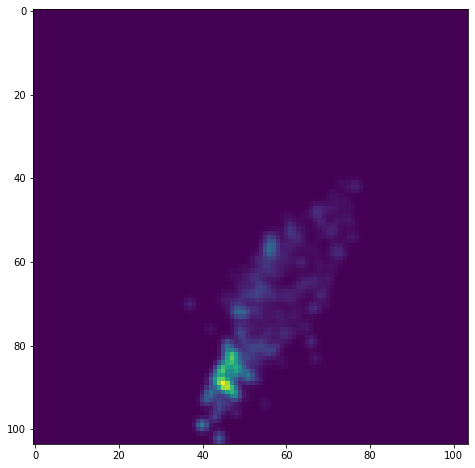

In-Silico GEX - Z-axis


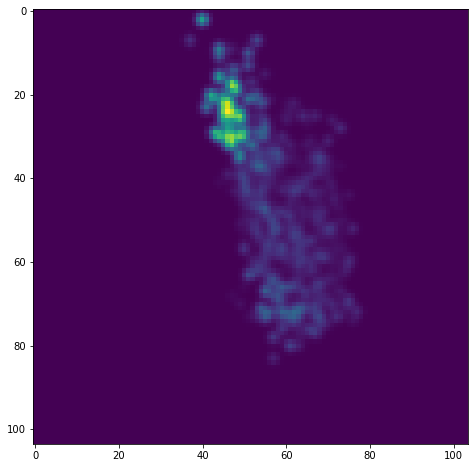

Foxp2
Real GEX


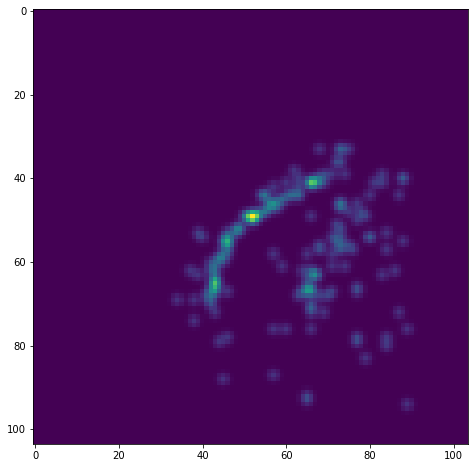

In-Silico GEX - X-axis


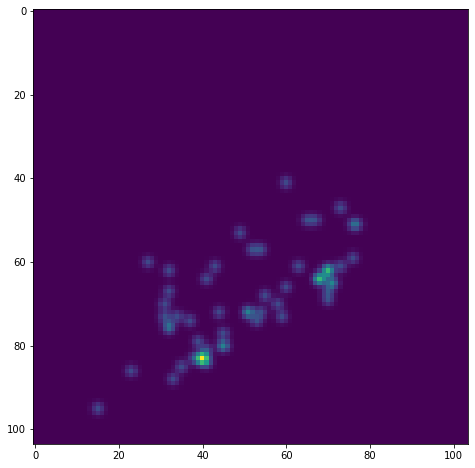

In-Silico GEX - Y-axis


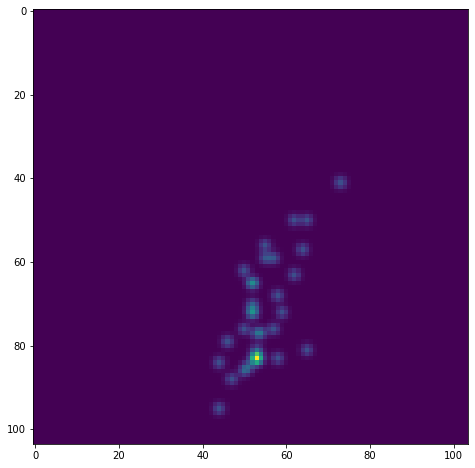

In-Silico GEX - Z-axis


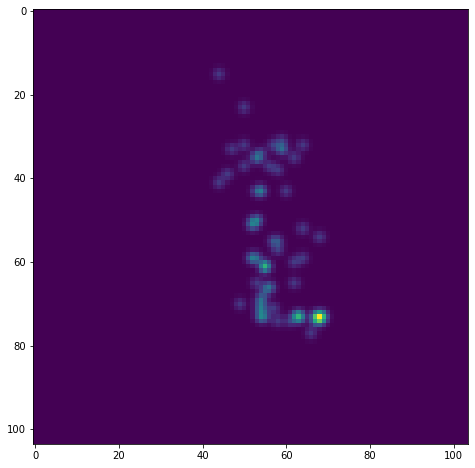

Zfpm2
Real GEX


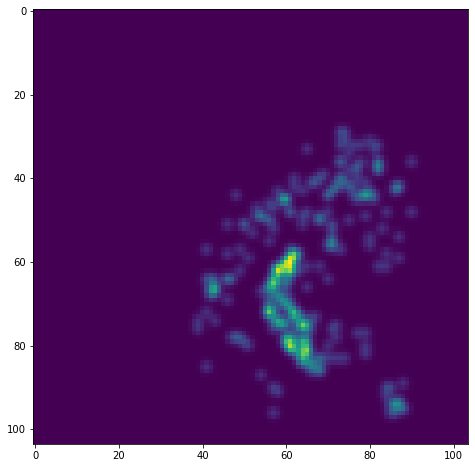

In-Silico GEX - X-axis


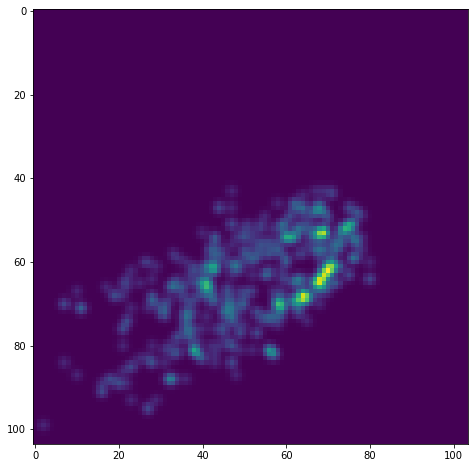

In-Silico GEX - Y-axis


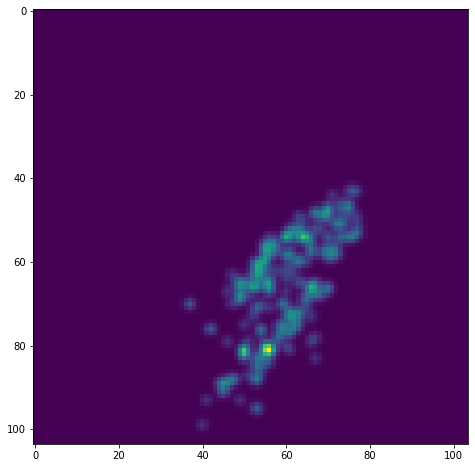

In-Silico GEX - Z-axis


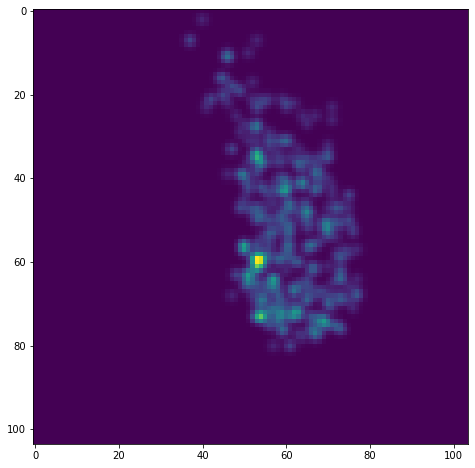

Hs3st4
Real GEX


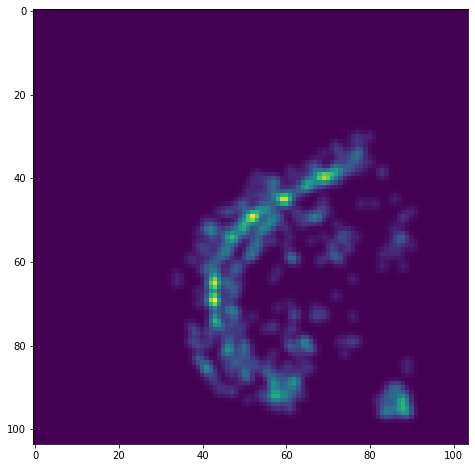

In-Silico GEX - X-axis


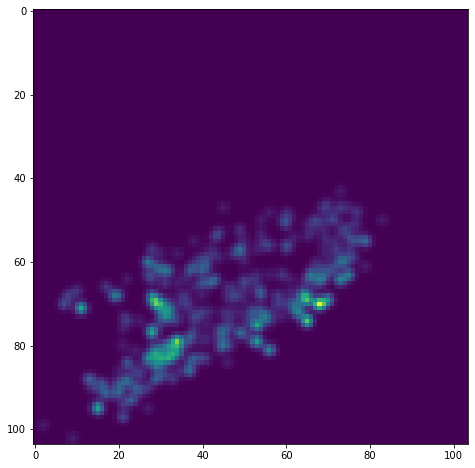

In-Silico GEX - Y-axis


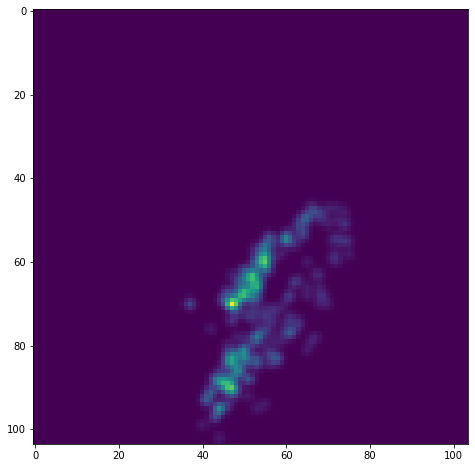

In-Silico GEX - Z-axis


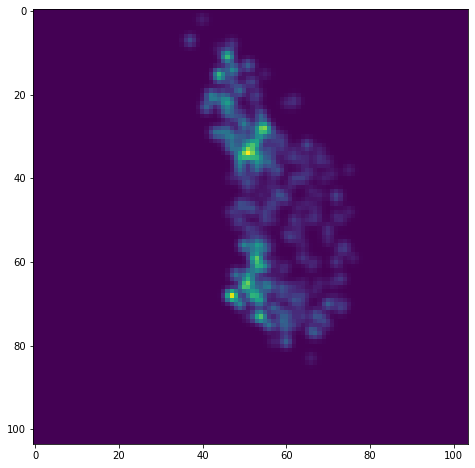

Nrp1
Real GEX


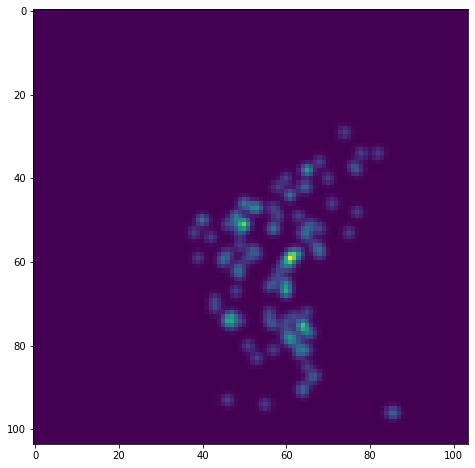

In-Silico GEX - X-axis


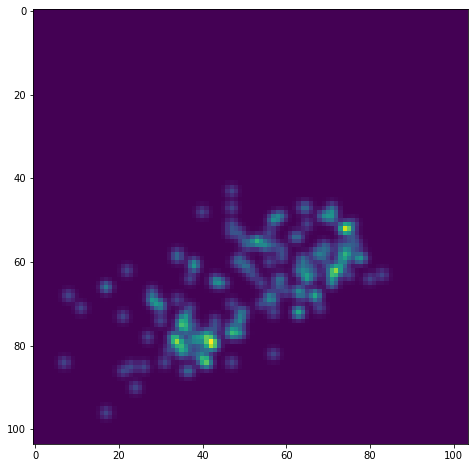

In-Silico GEX - Y-axis


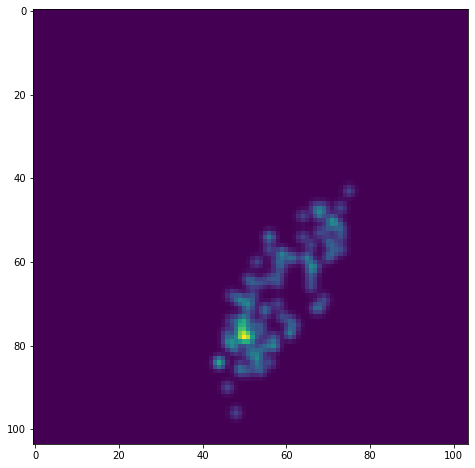

In-Silico GEX - Z-axis


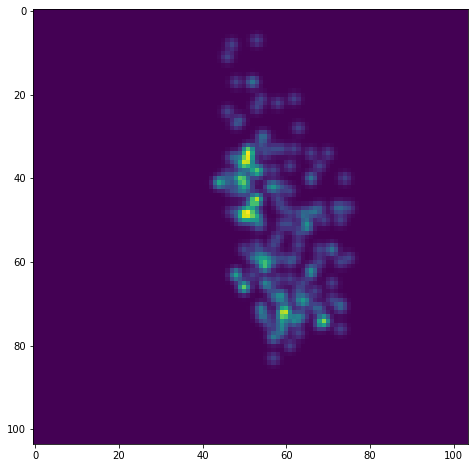

Tle4
Real GEX


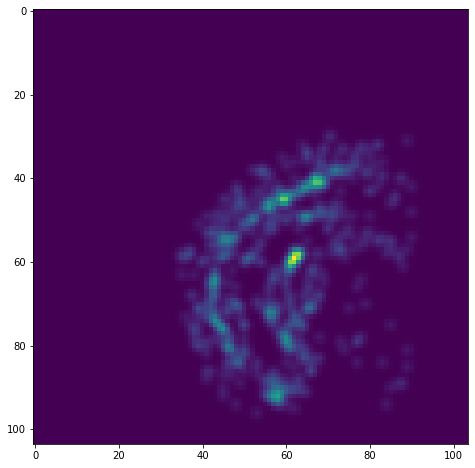

In-Silico GEX - X-axis


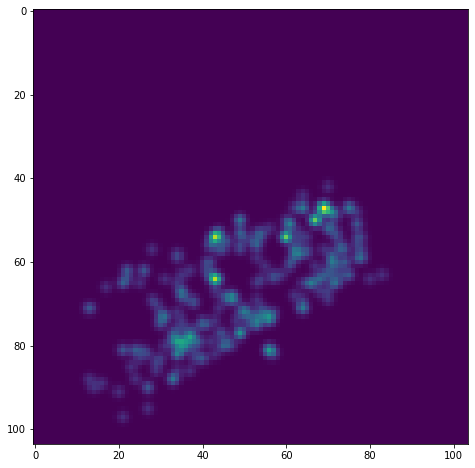

In-Silico GEX - Y-axis


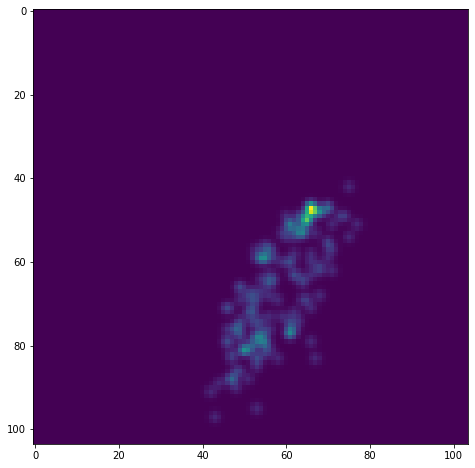

In-Silico GEX - Z-axis


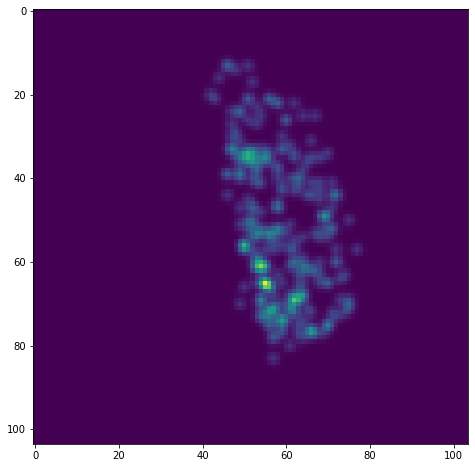

Cplx3
Real GEX


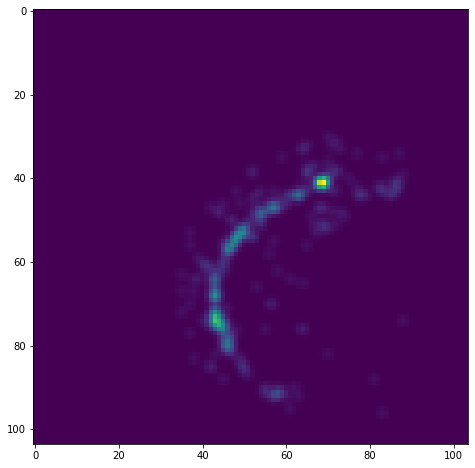

In-Silico GEX - X-axis


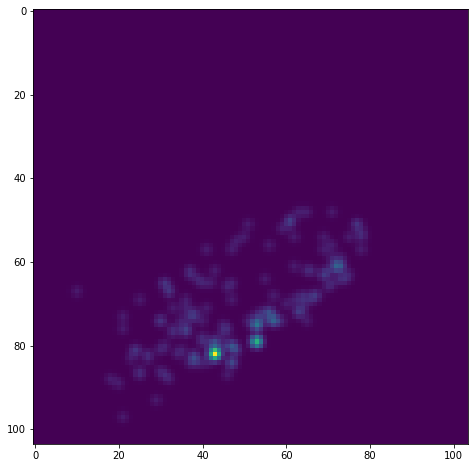

In-Silico GEX - Y-axis


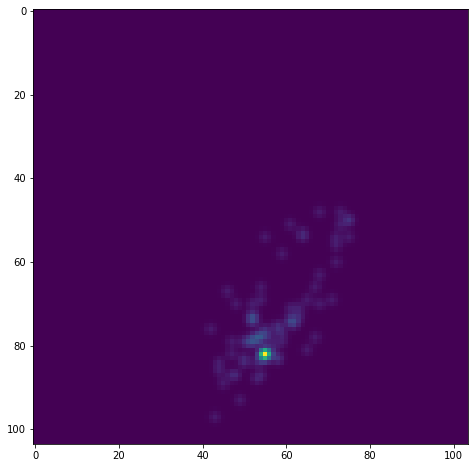

In-Silico GEX - Z-axis


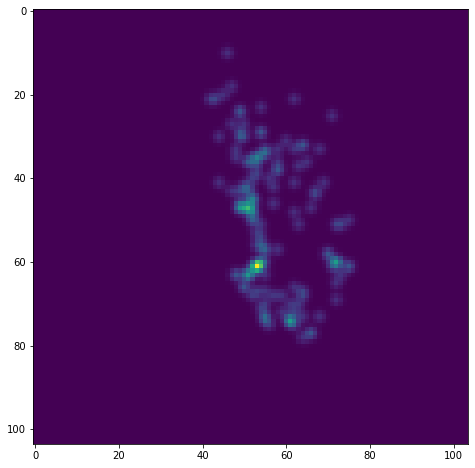

Svil
Real GEX


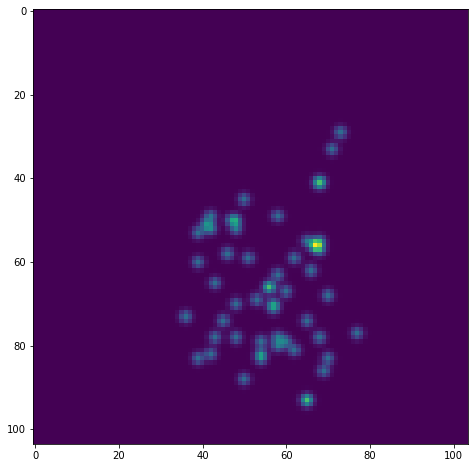

In-Silico GEX - X-axis


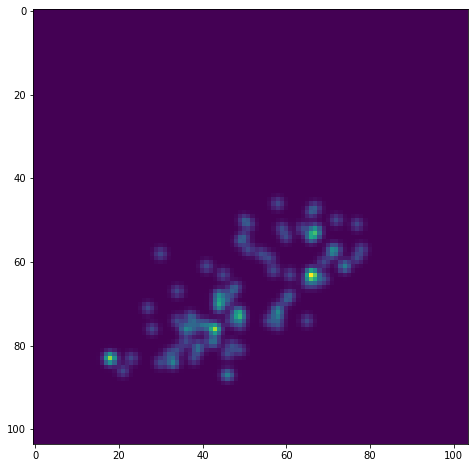

In-Silico GEX - Y-axis


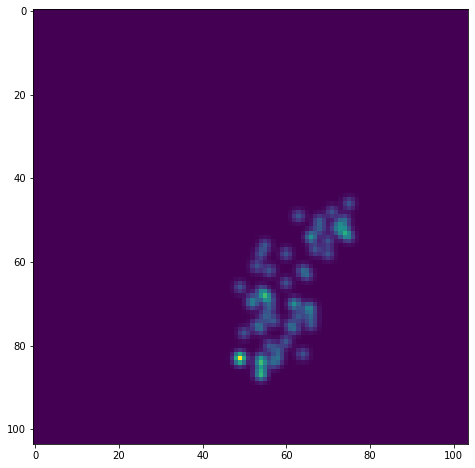

In-Silico GEX - Z-axis


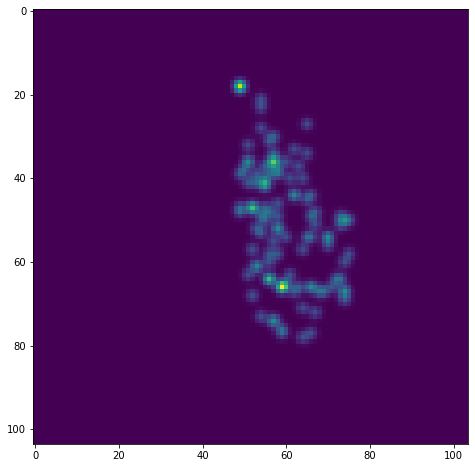

Fbxl7
Real GEX


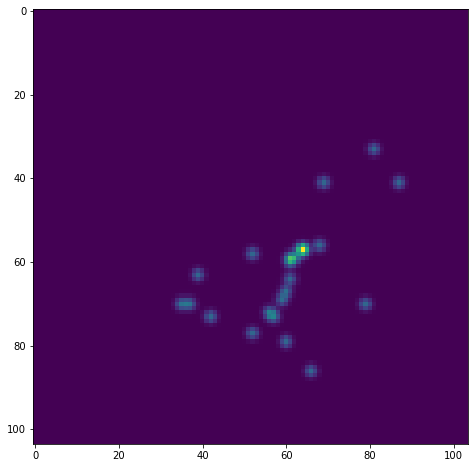

In-Silico GEX - X-axis


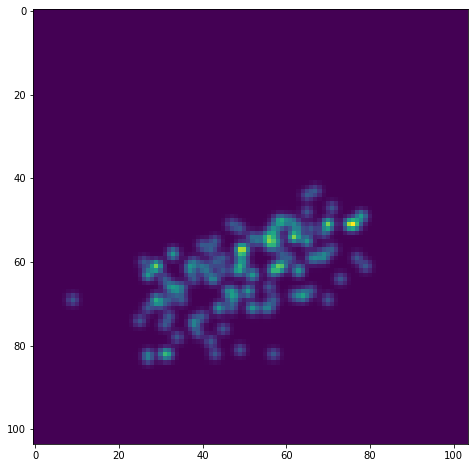

In-Silico GEX - Y-axis


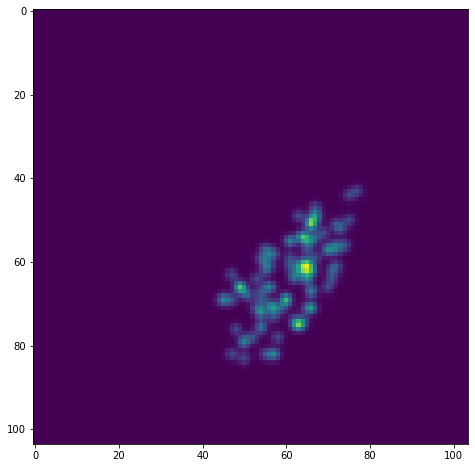

In-Silico GEX - Z-axis


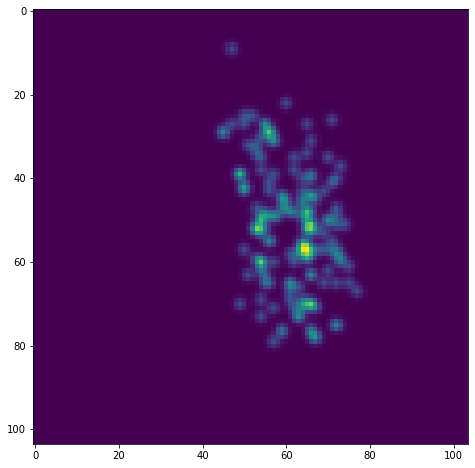

Inpp4b
Real GEX


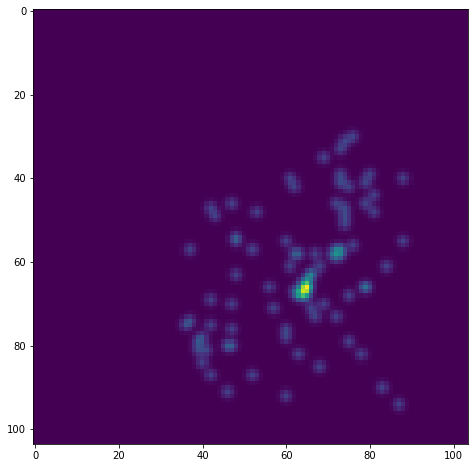

In-Silico GEX - X-axis


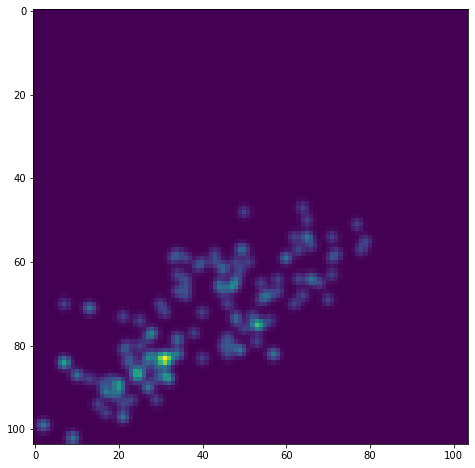

In-Silico GEX - Y-axis


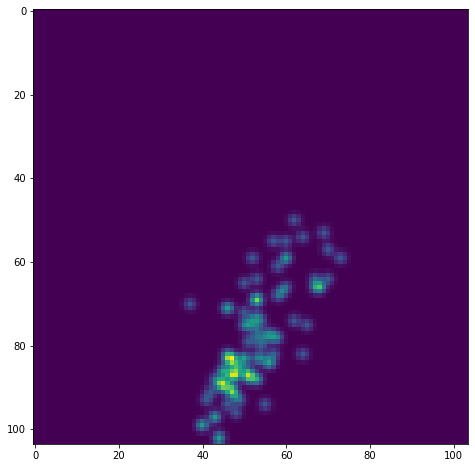

In-Silico GEX - Z-axis


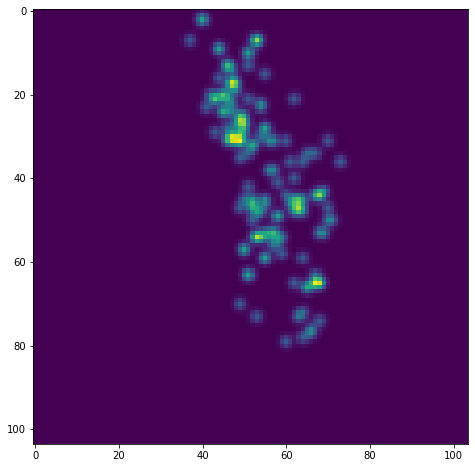

Car3
Real GEX


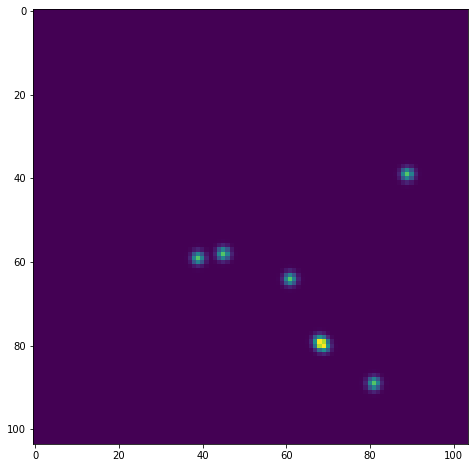

In-Silico GEX - X-axis


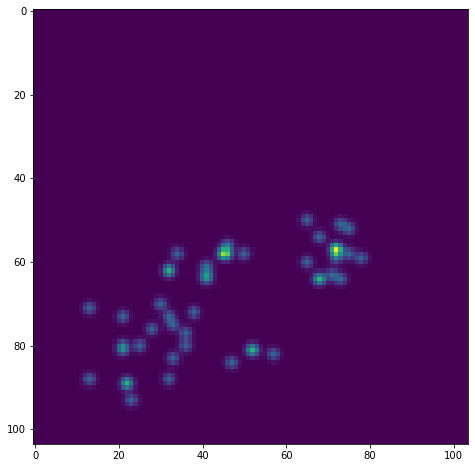

In-Silico GEX - Y-axis


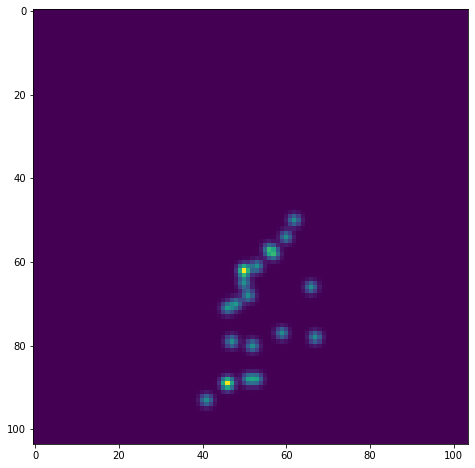

In-Silico GEX - Z-axis


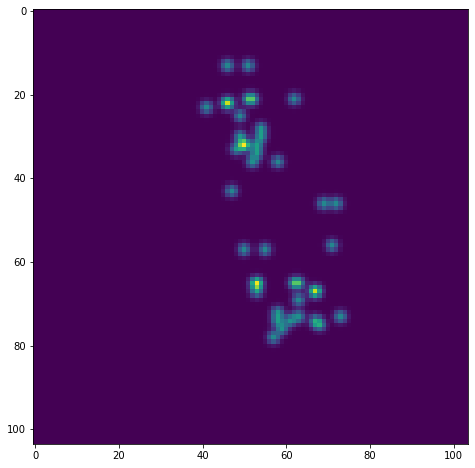

Otof
Real GEX


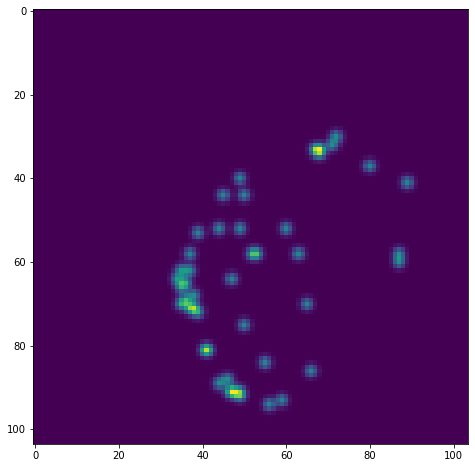

In-Silico GEX - X-axis


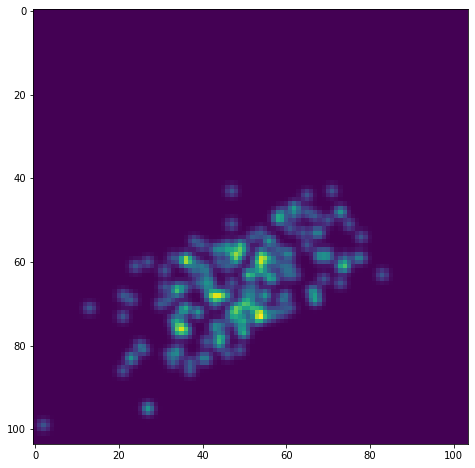

In-Silico GEX - Y-axis


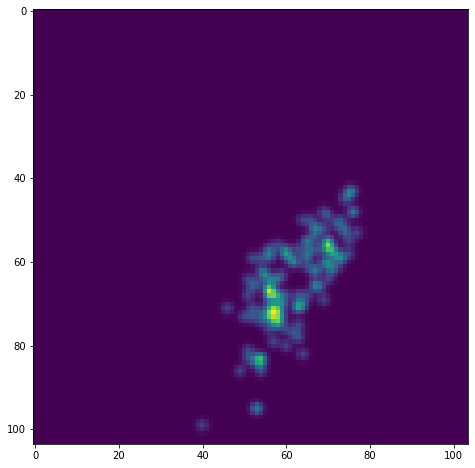

In-Silico GEX - Z-axis


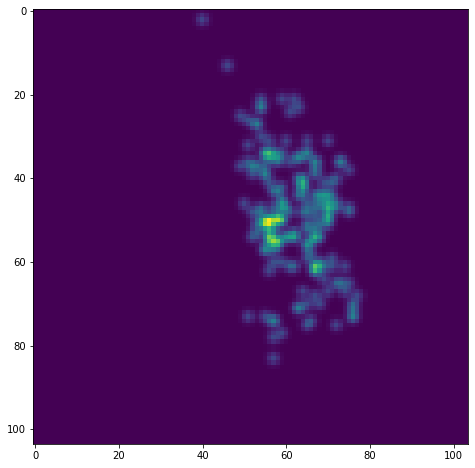

Hgf
Real GEX


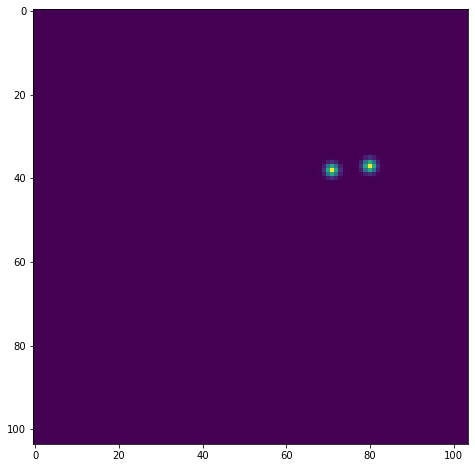

In-Silico GEX - X-axis


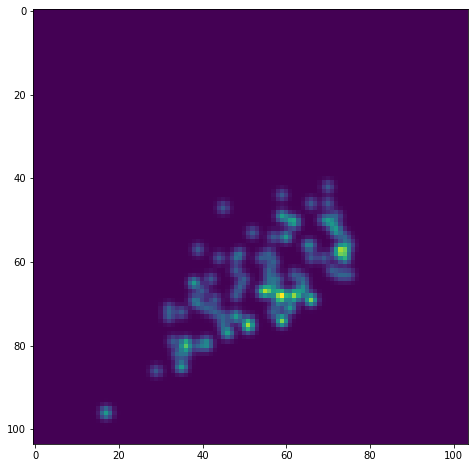

In-Silico GEX - Y-axis


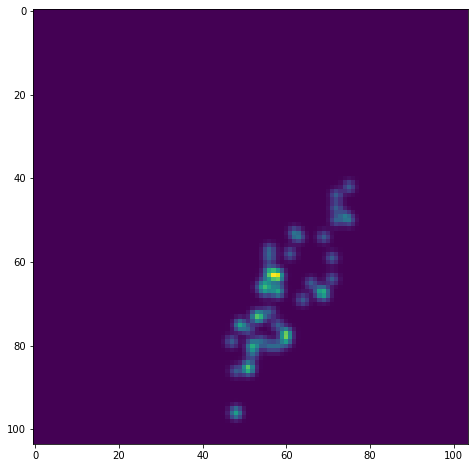

In-Silico GEX - Z-axis


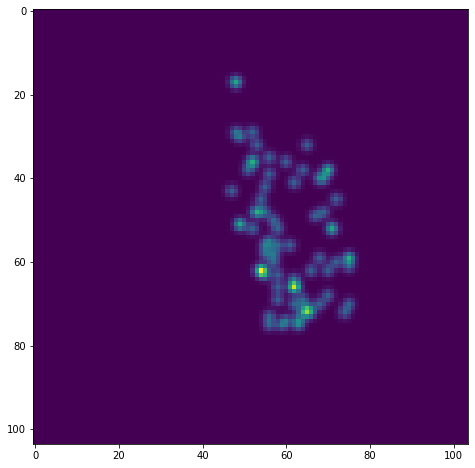

Fezf2
Real GEX


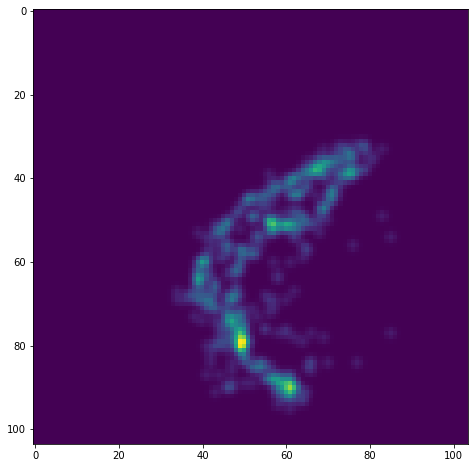

In-Silico GEX - X-axis


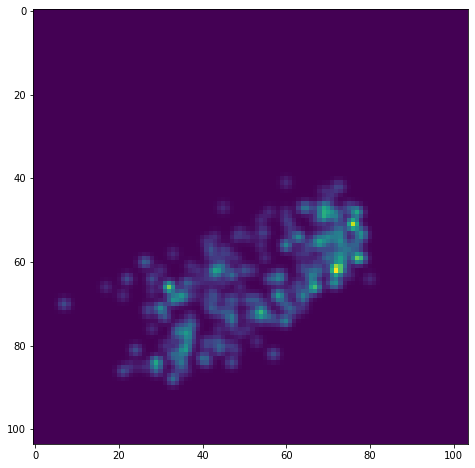

In-Silico GEX - Y-axis


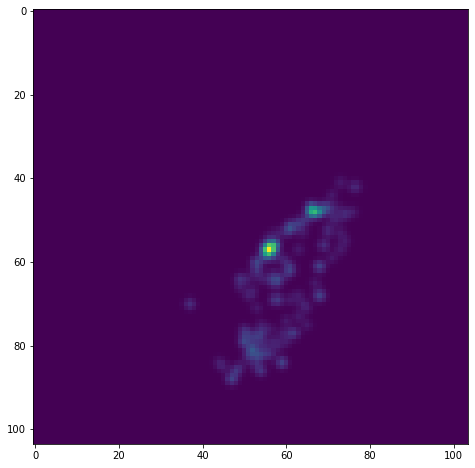

In-Silico GEX - Z-axis


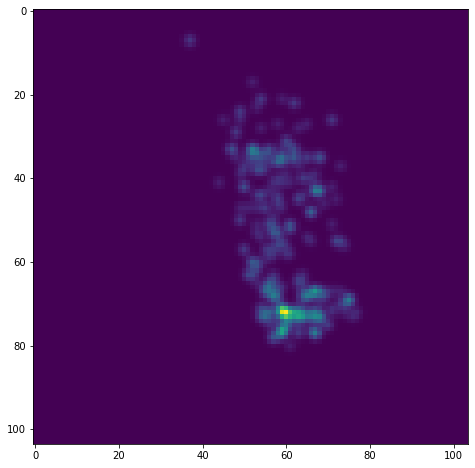

Lamp5
Real GEX


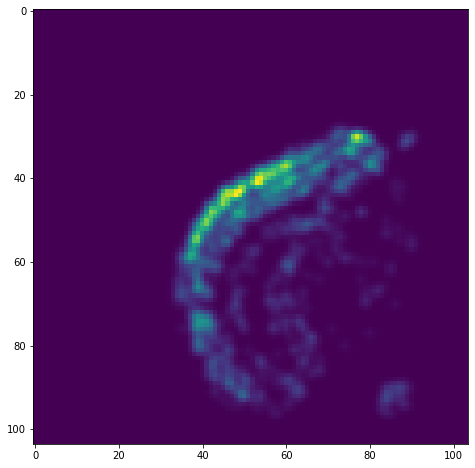

In-Silico GEX - X-axis


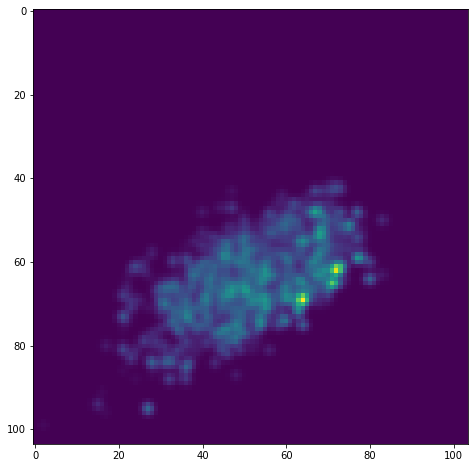

In-Silico GEX - Y-axis


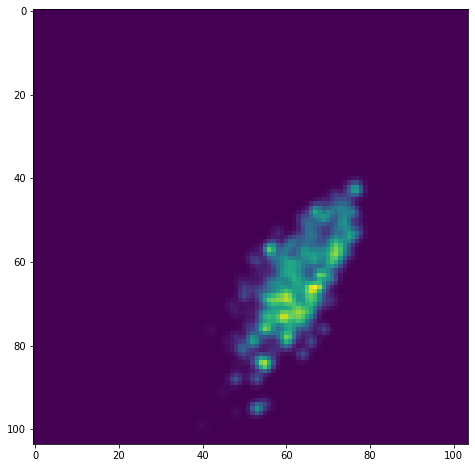

In-Silico GEX - Z-axis


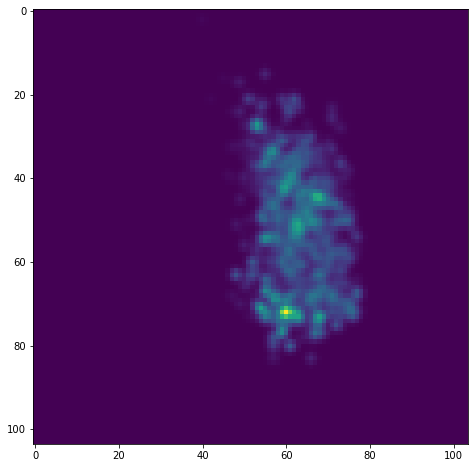

Dab1
Real GEX


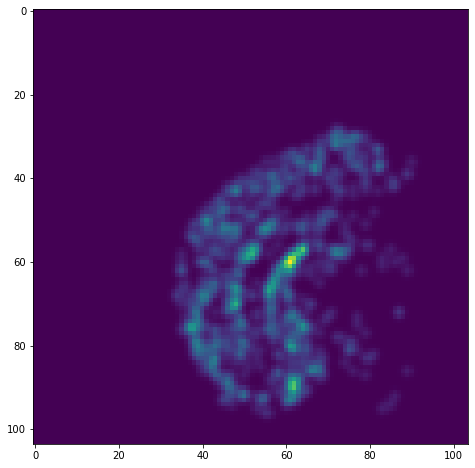

In-Silico GEX - X-axis


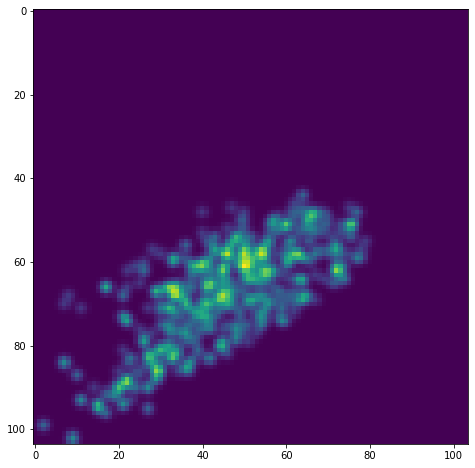

In-Silico GEX - Y-axis


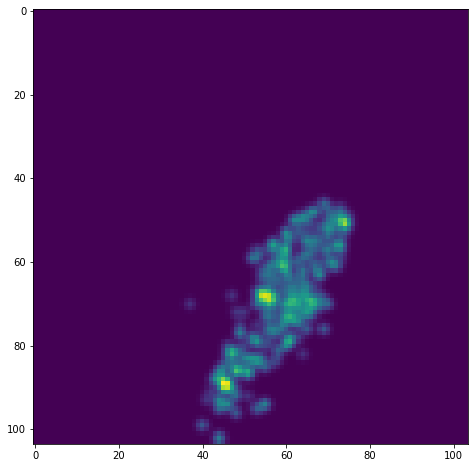

In-Silico GEX - Z-axis


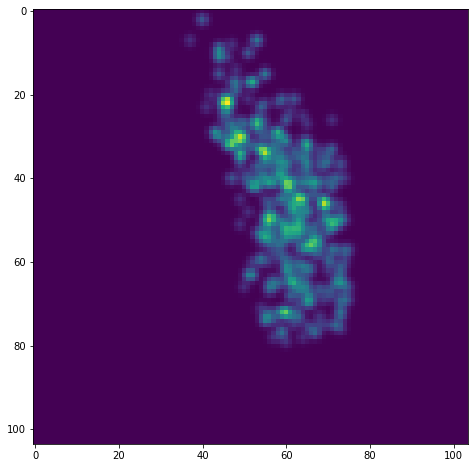

Zmat4
Real GEX


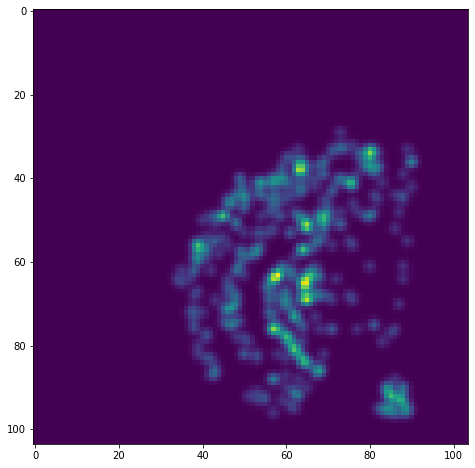

In-Silico GEX - X-axis


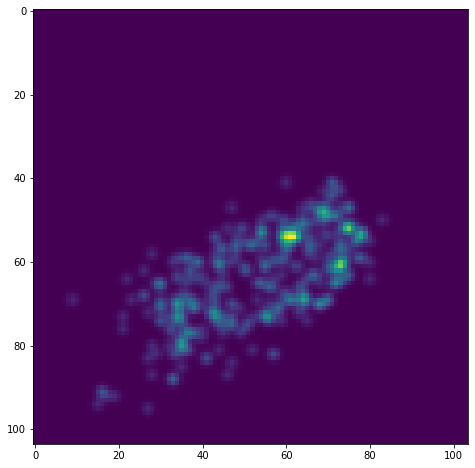

In-Silico GEX - Y-axis


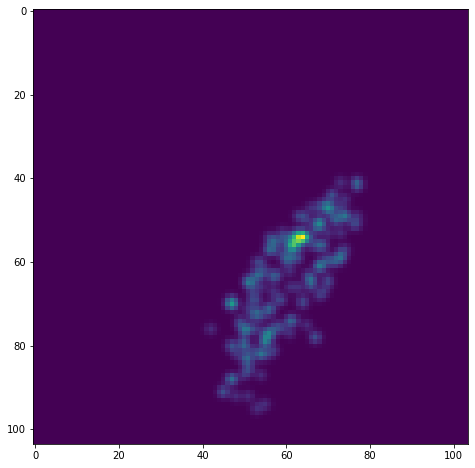

In-Silico GEX - Z-axis


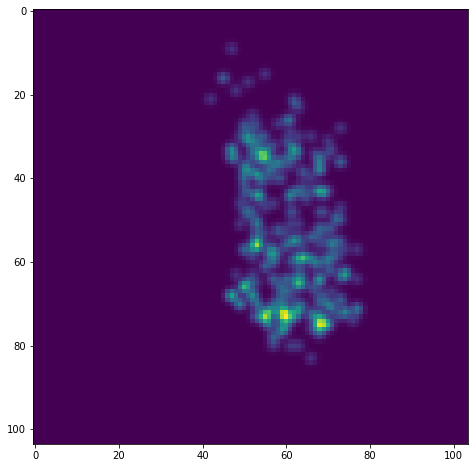

Hs6st3
Real GEX


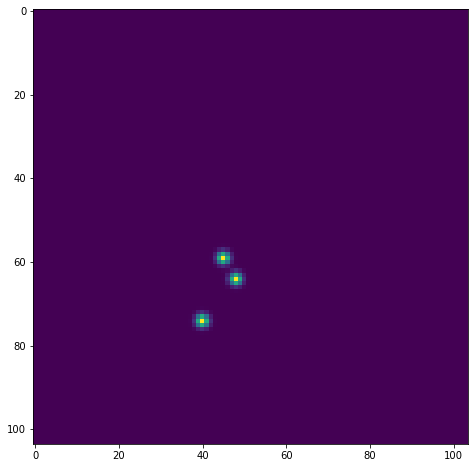

In-Silico GEX - X-axis


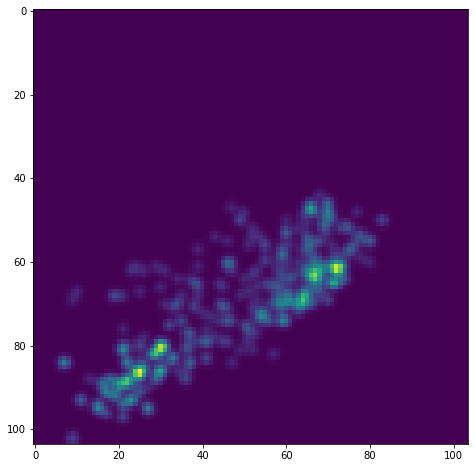

In-Silico GEX - Y-axis


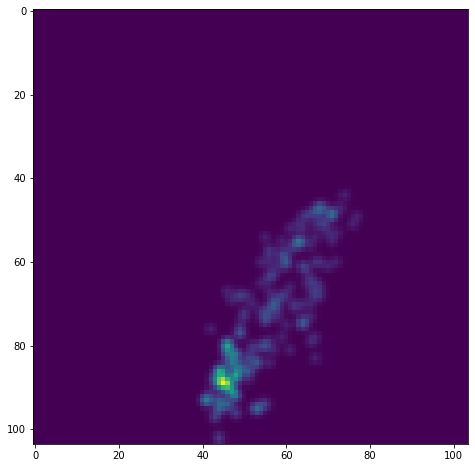

In-Silico GEX - Z-axis


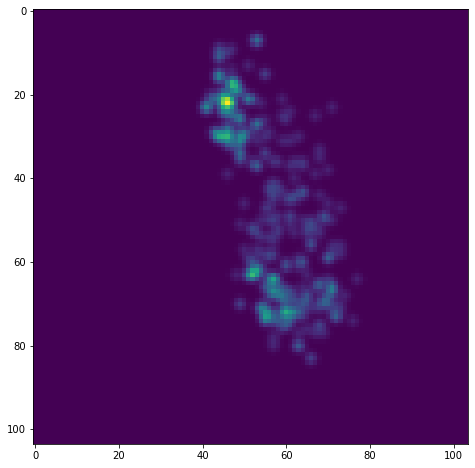

Nrsn1
Real GEX


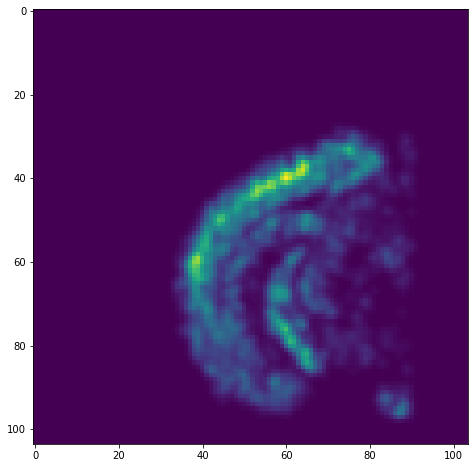

In-Silico GEX - X-axis


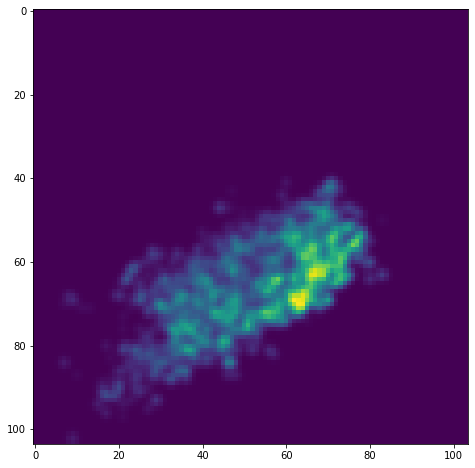

In-Silico GEX - Y-axis


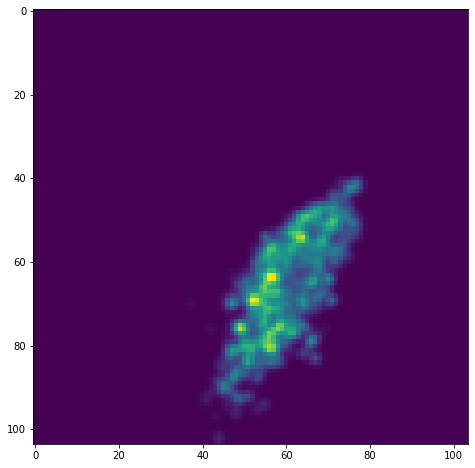

In-Silico GEX - Z-axis


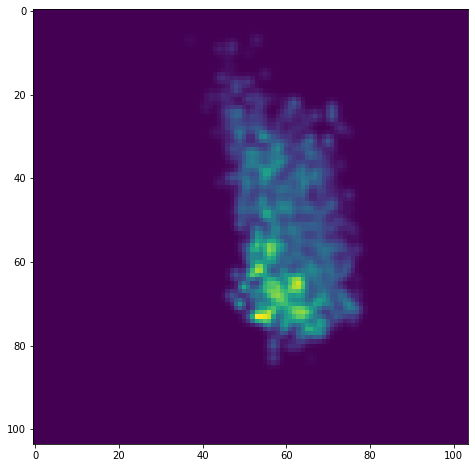

Satb1
Real GEX


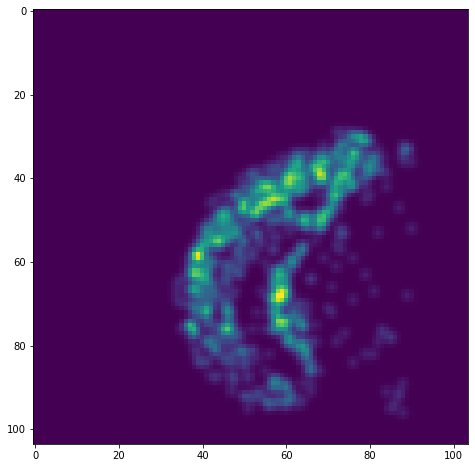

In-Silico GEX - X-axis


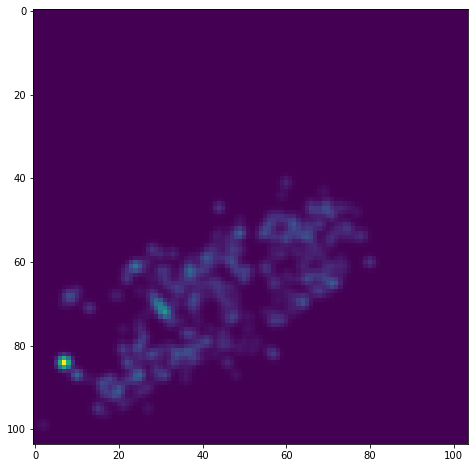

In-Silico GEX - Y-axis


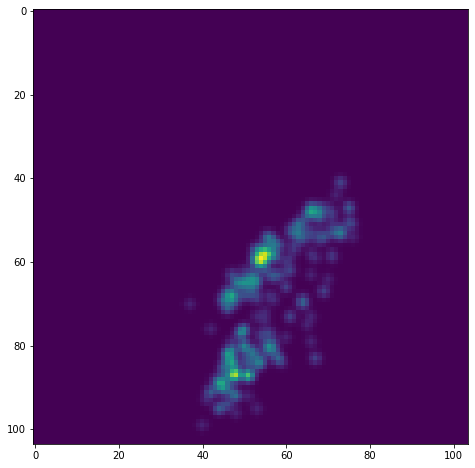

In-Silico GEX - Z-axis


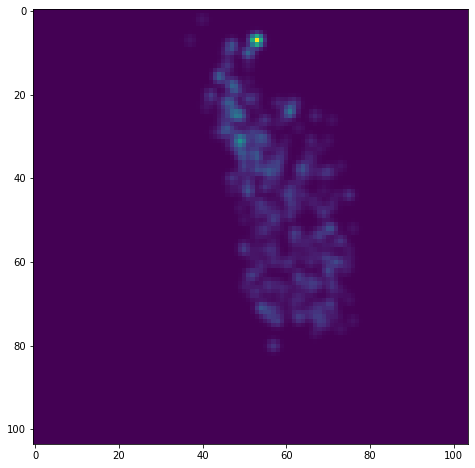

Camk4
Real GEX


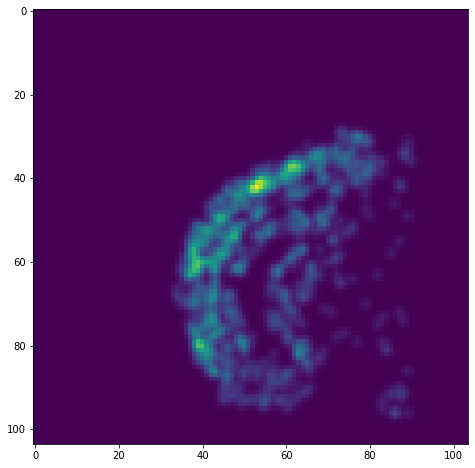

In-Silico GEX - X-axis


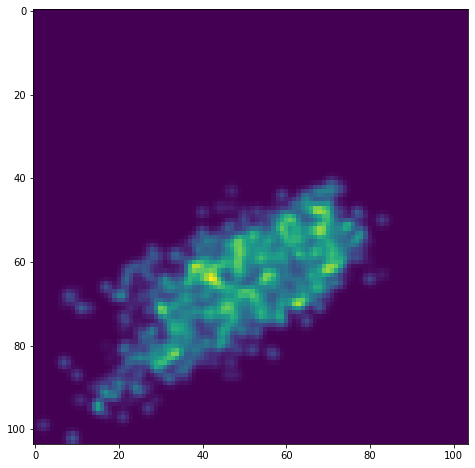

In-Silico GEX - Y-axis


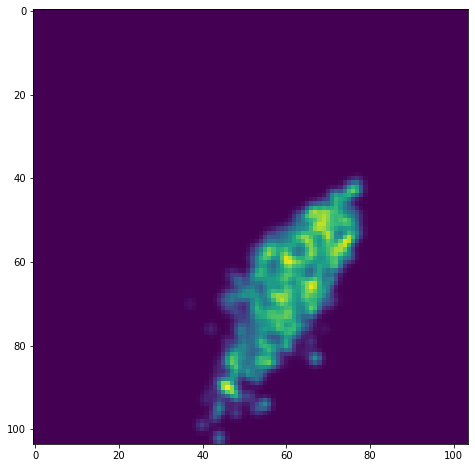

In-Silico GEX - Z-axis


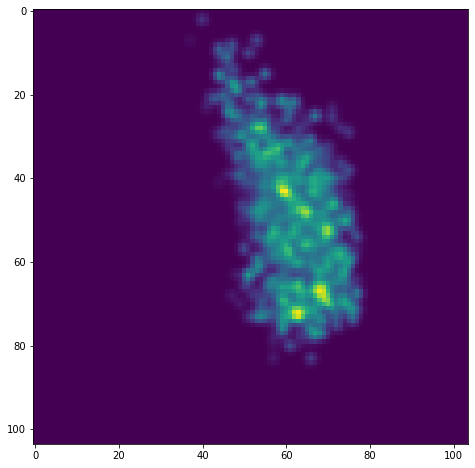

Rgs4
Real GEX


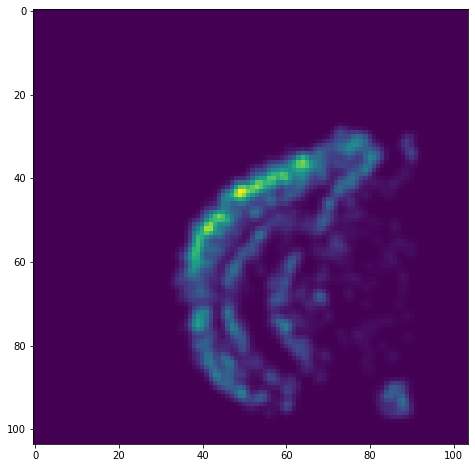

In-Silico GEX - X-axis


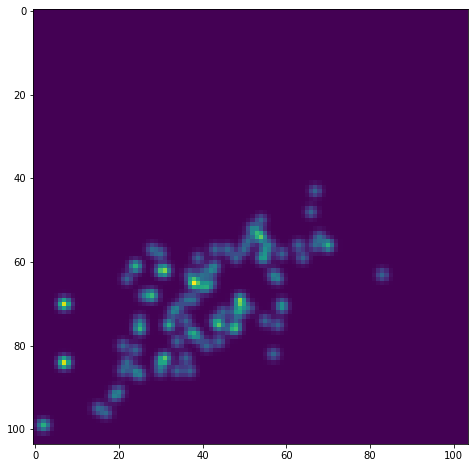

In-Silico GEX - Y-axis


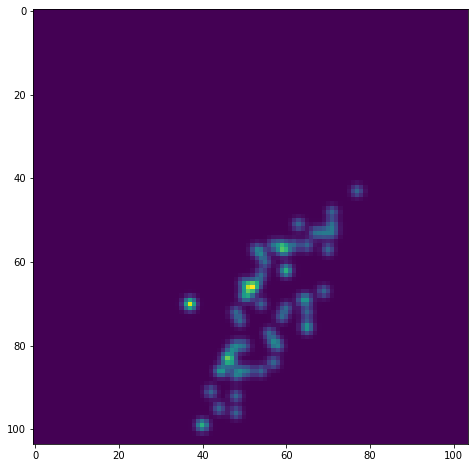

In-Silico GEX - Z-axis


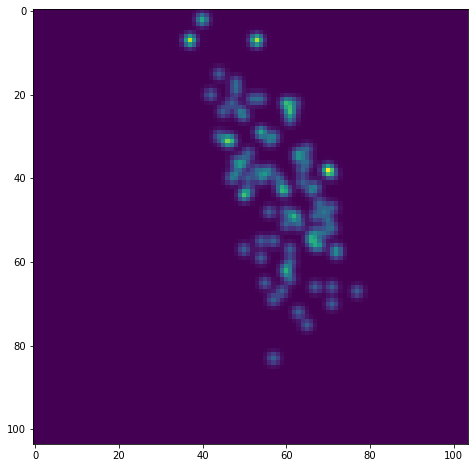

Pcp4
Real GEX


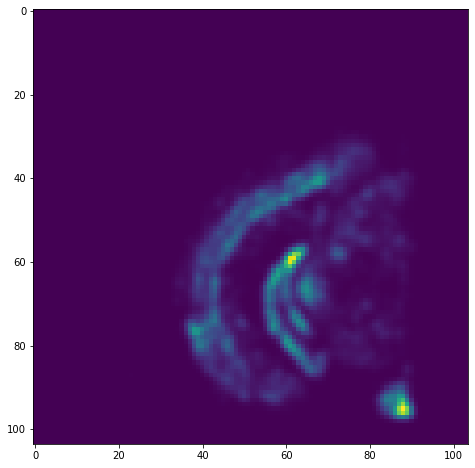

In-Silico GEX - X-axis


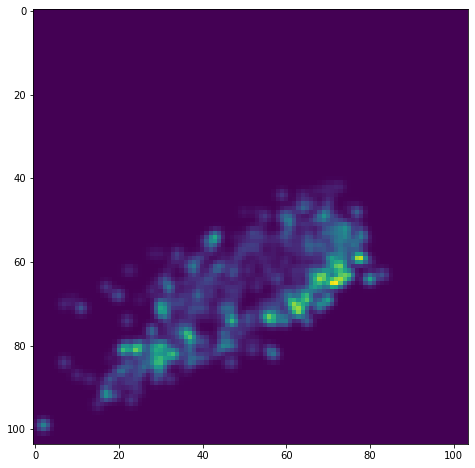

In-Silico GEX - Y-axis


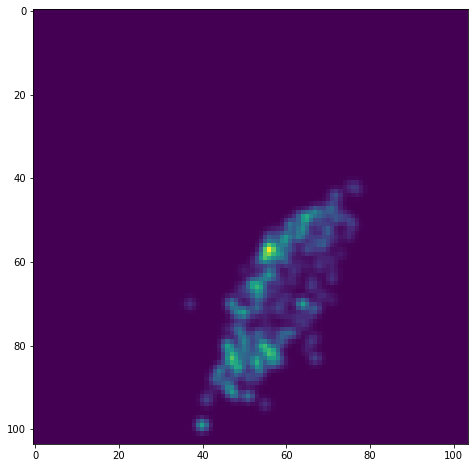

In-Silico GEX - Z-axis


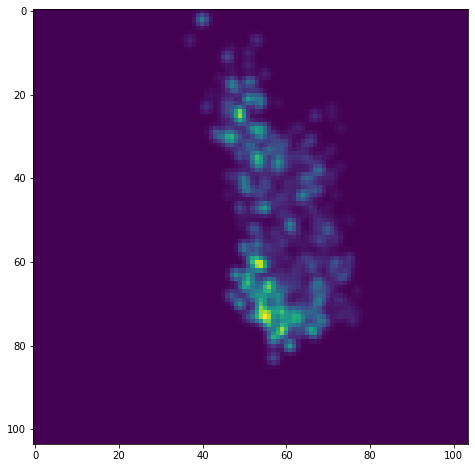

Hs3st2
Real GEX


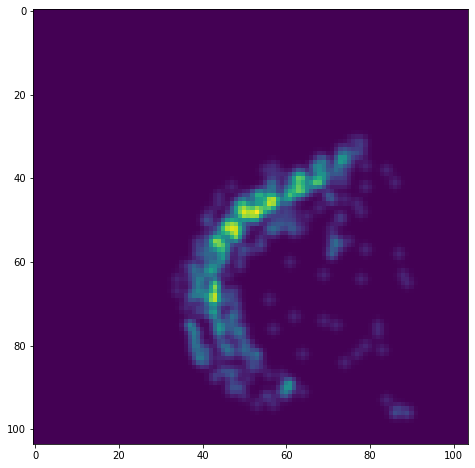

In-Silico GEX - X-axis


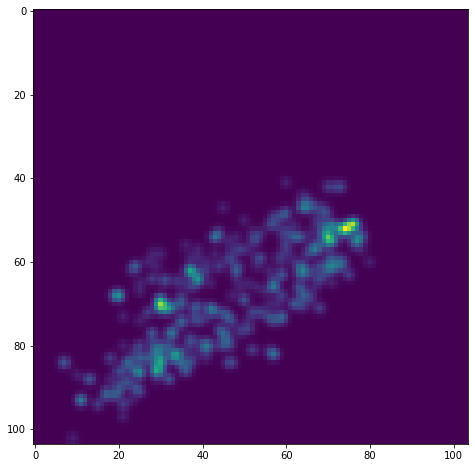

In-Silico GEX - Y-axis


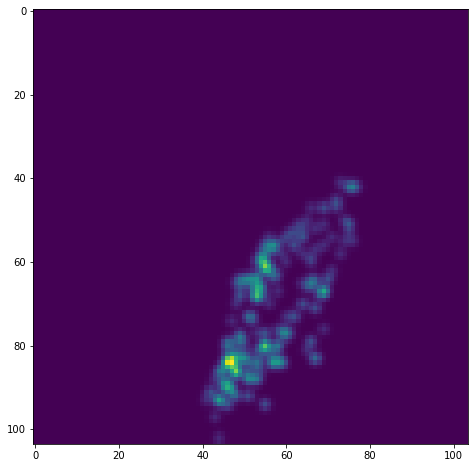

In-Silico GEX - Z-axis


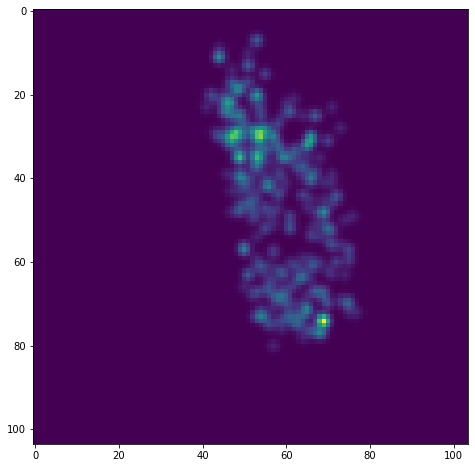

Tmsb10
Real GEX


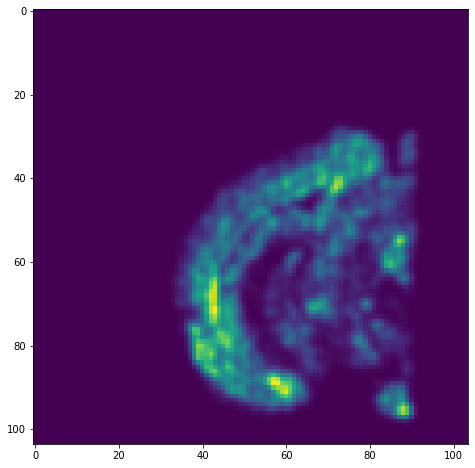

In-Silico GEX - X-axis


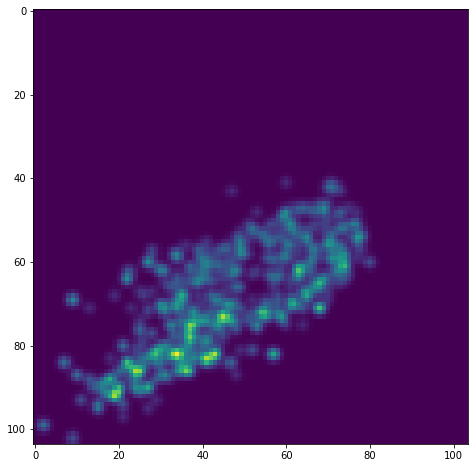

In-Silico GEX - Y-axis


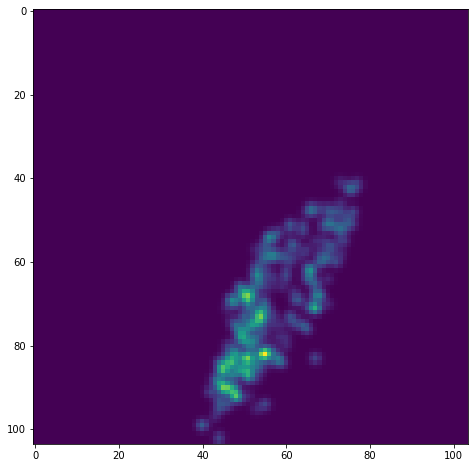

In-Silico GEX - Z-axis


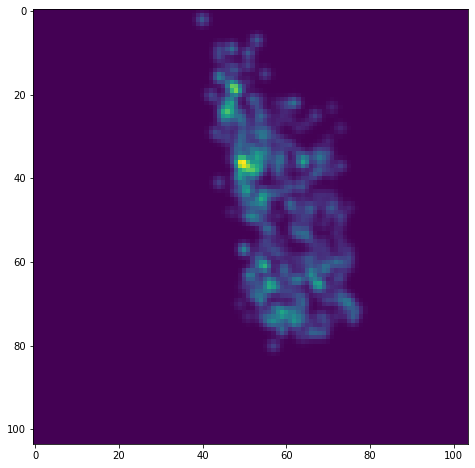

Cdh13
Real GEX


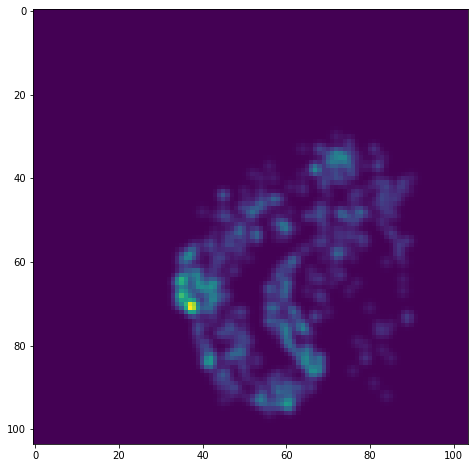

In-Silico GEX - X-axis


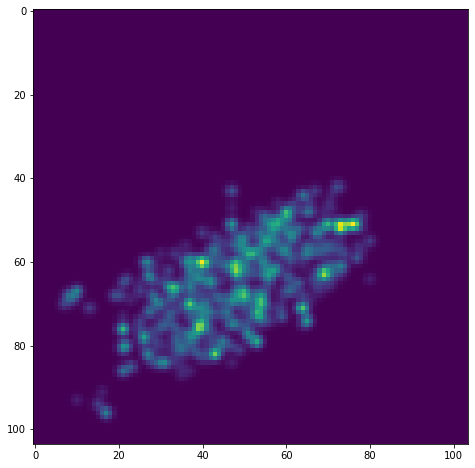

In-Silico GEX - Y-axis


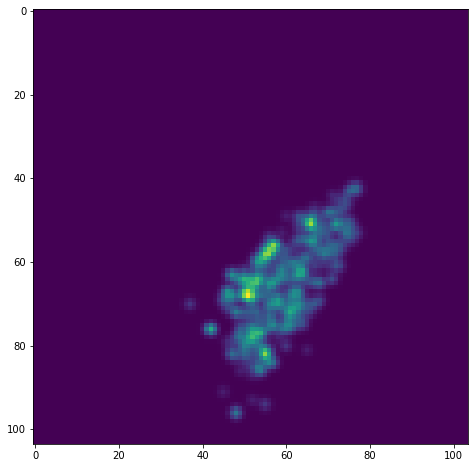

In-Silico GEX - Z-axis


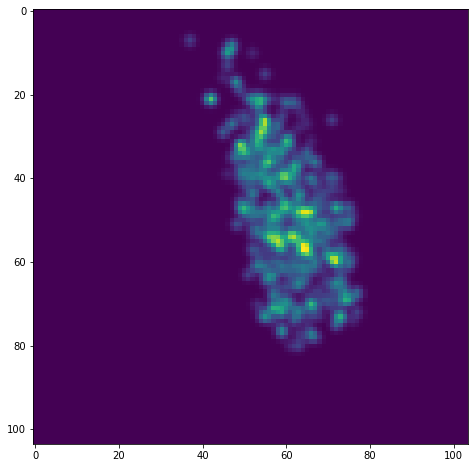

Igsf21
Real GEX


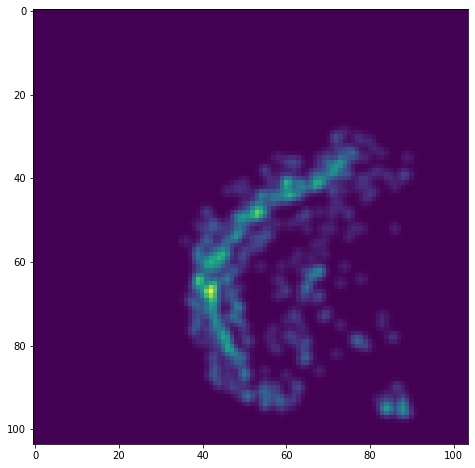

In-Silico GEX - X-axis


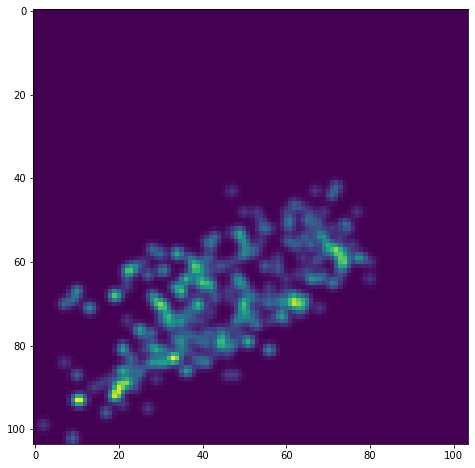

In-Silico GEX - Y-axis


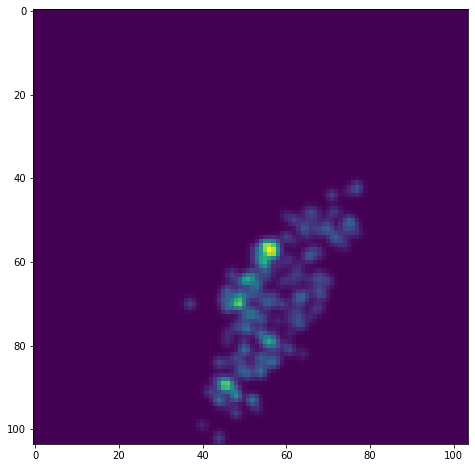

In-Silico GEX - Z-axis


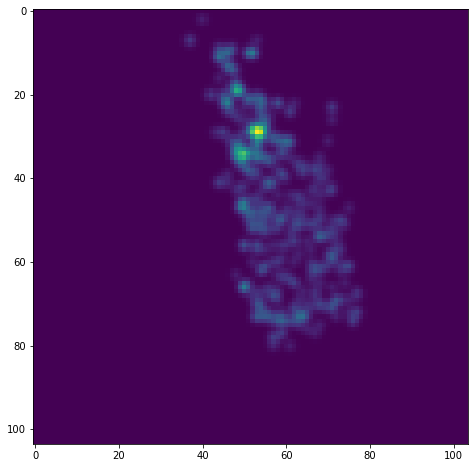

Gria1
Real GEX


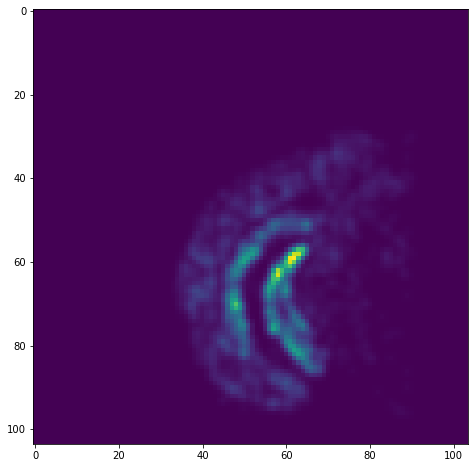

In-Silico GEX - X-axis


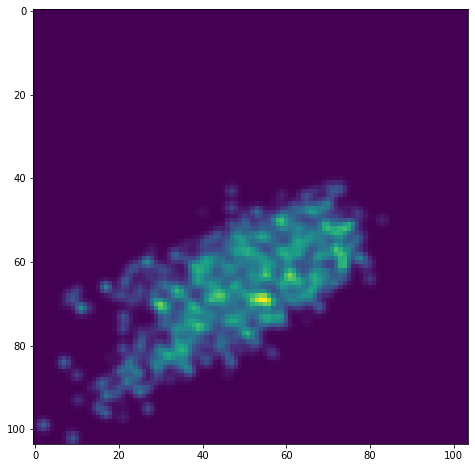

In-Silico GEX - Y-axis


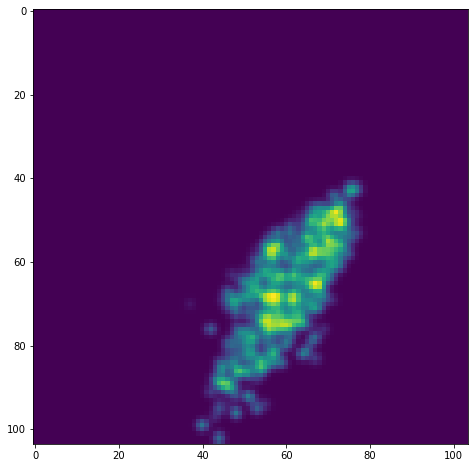

In-Silico GEX - Z-axis


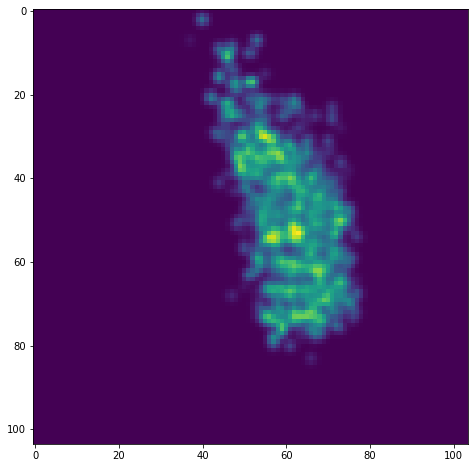

Zfp804a
Real GEX


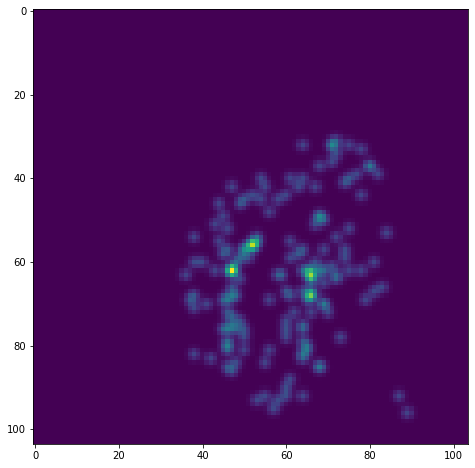

In-Silico GEX - X-axis


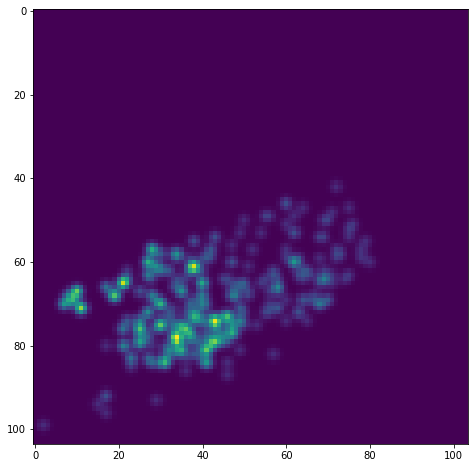

In-Silico GEX - Y-axis


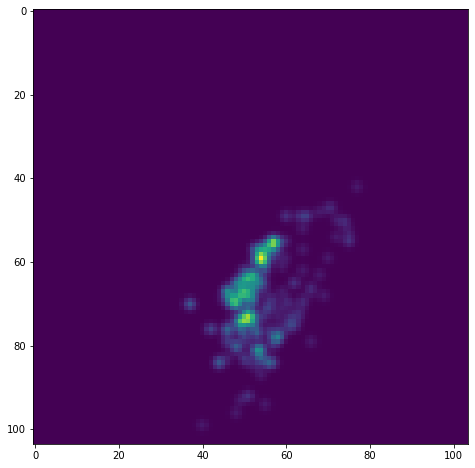

In-Silico GEX - Z-axis


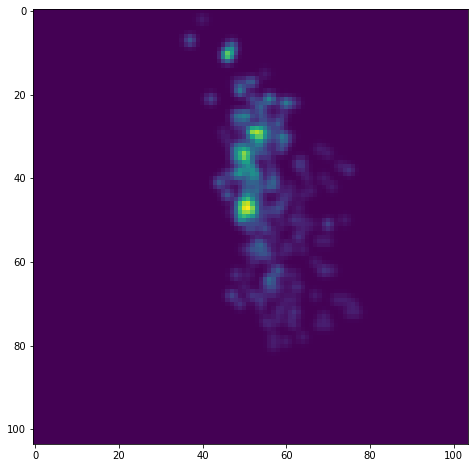

Brinp3
Real GEX


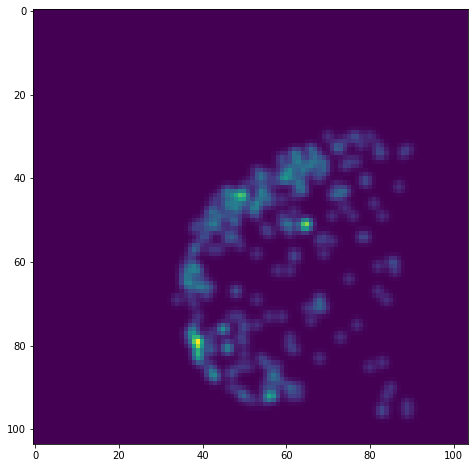

In-Silico GEX - X-axis


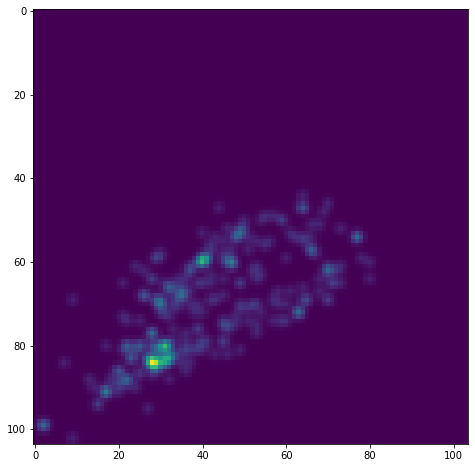

In-Silico GEX - Y-axis


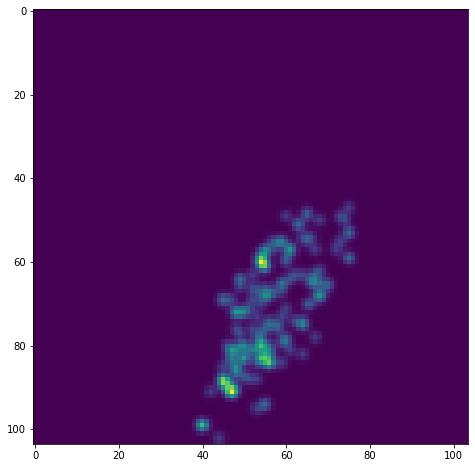

In-Silico GEX - Z-axis


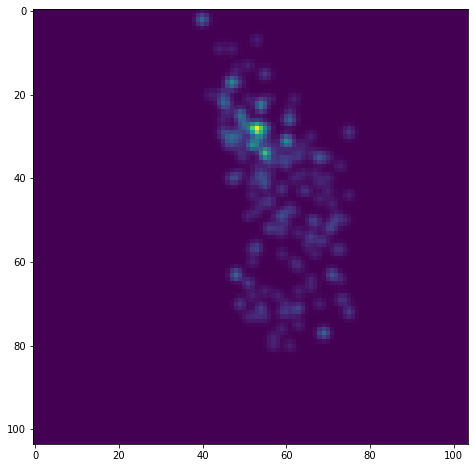

Cbln2
Real GEX


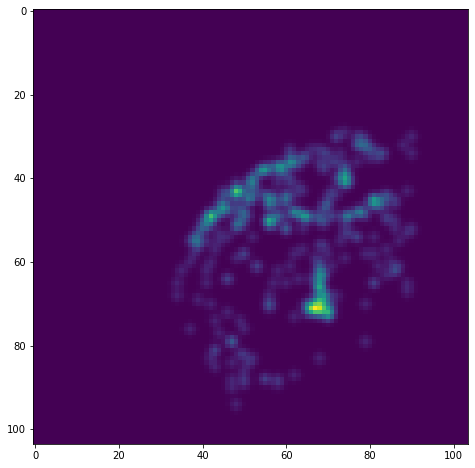

In-Silico GEX - X-axis


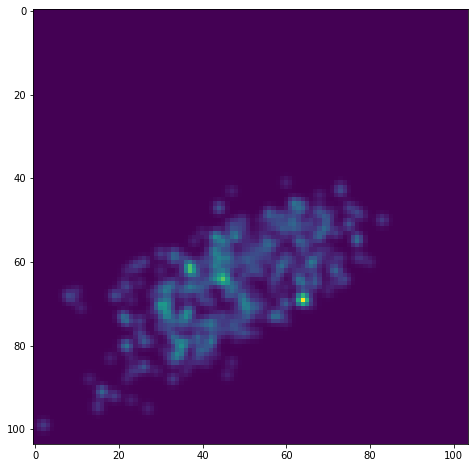

In-Silico GEX - Y-axis


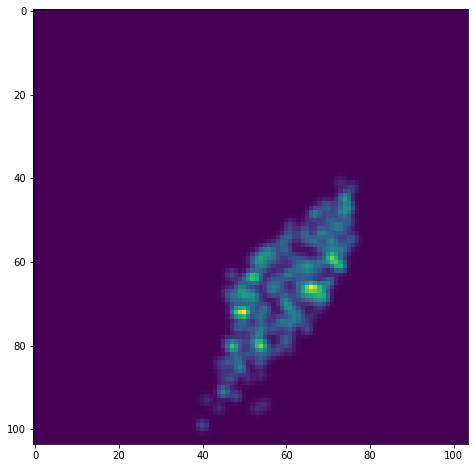

In-Silico GEX - Z-axis


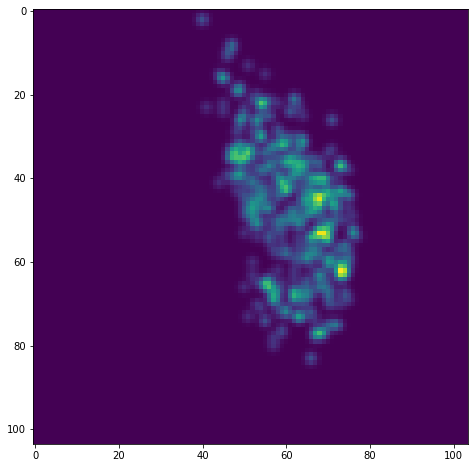

Etv1
Real GEX


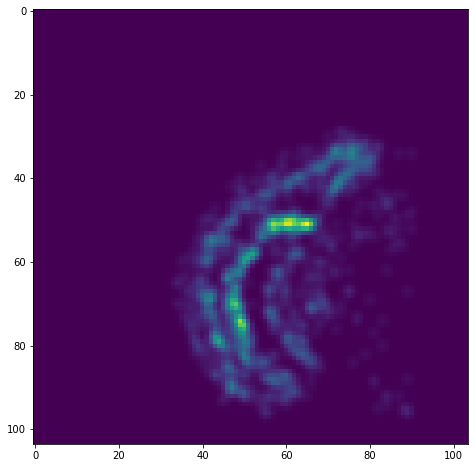

In-Silico GEX - X-axis


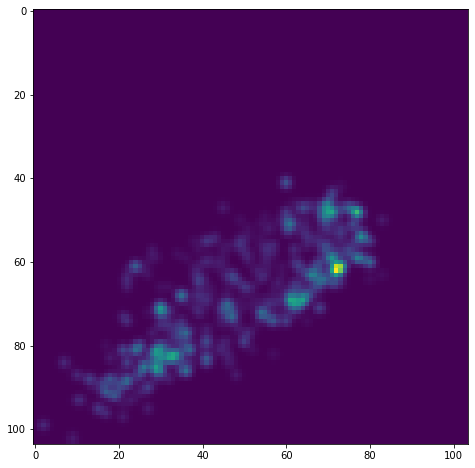

In-Silico GEX - Y-axis


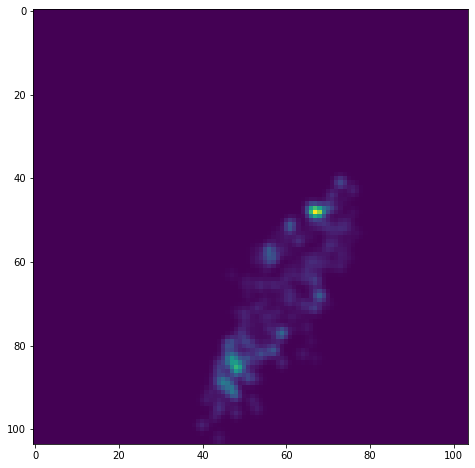

In-Silico GEX - Z-axis


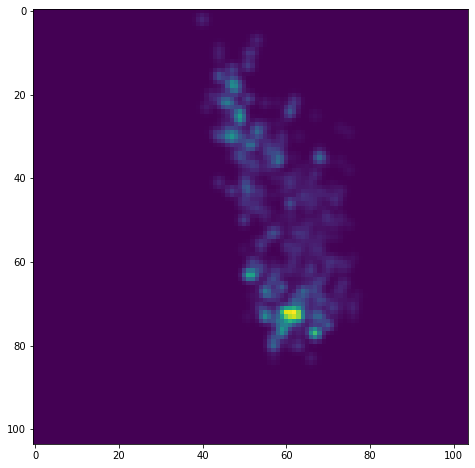

Nnat
Real GEX


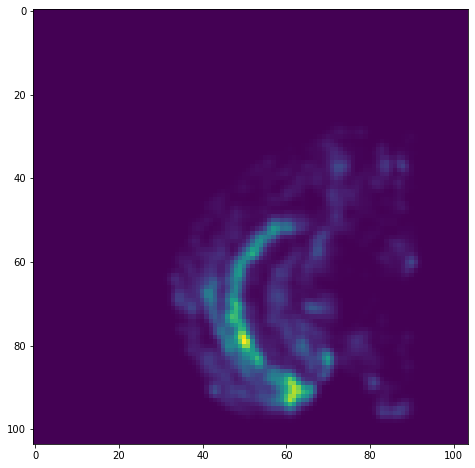

In-Silico GEX - X-axis


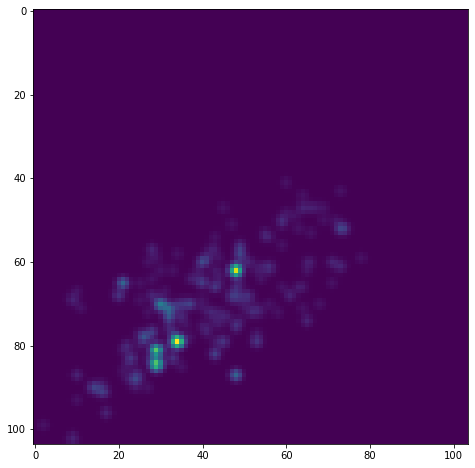

In-Silico GEX - Y-axis


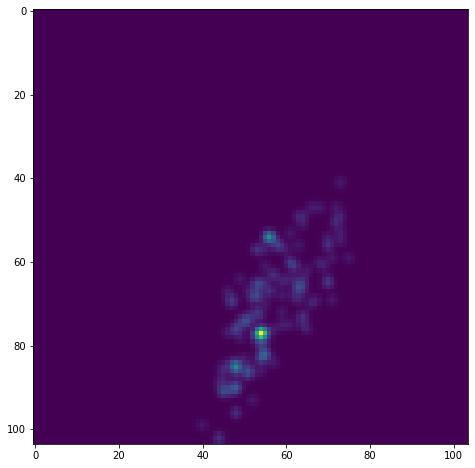

In-Silico GEX - Z-axis


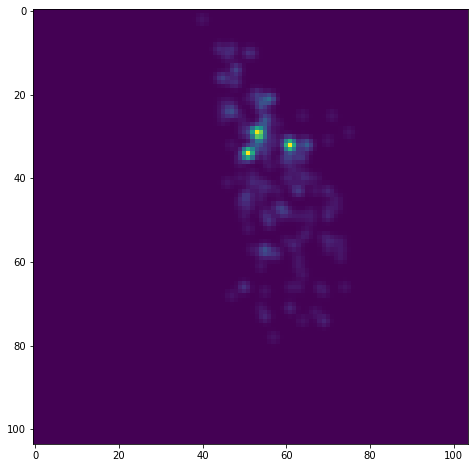

Lypd1
Real GEX


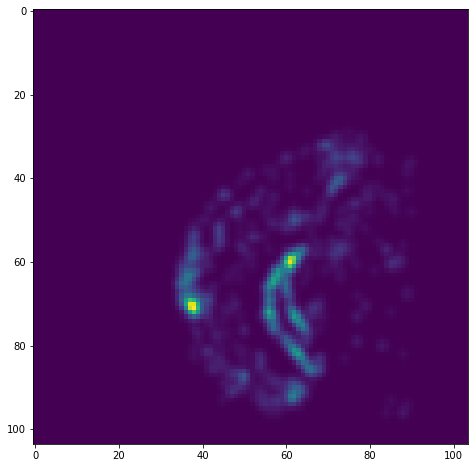

In-Silico GEX - X-axis


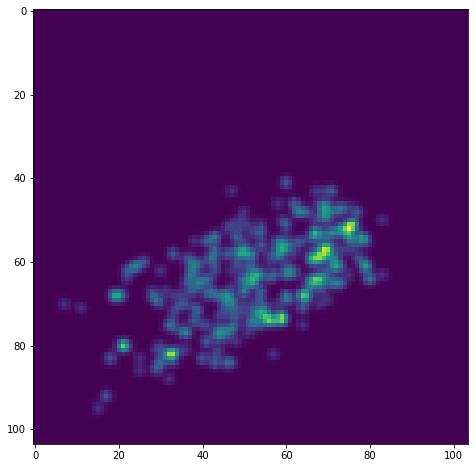

In-Silico GEX - Y-axis


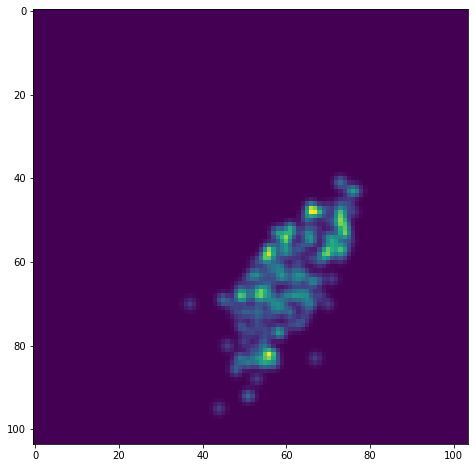

In-Silico GEX - Z-axis


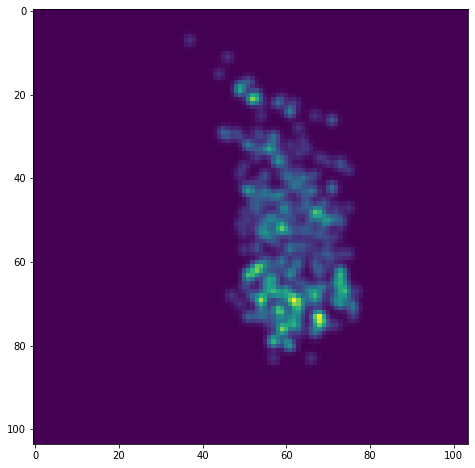

Ncam2
Real GEX


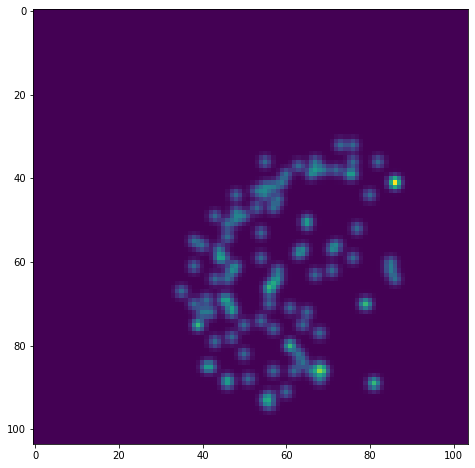

In-Silico GEX - X-axis


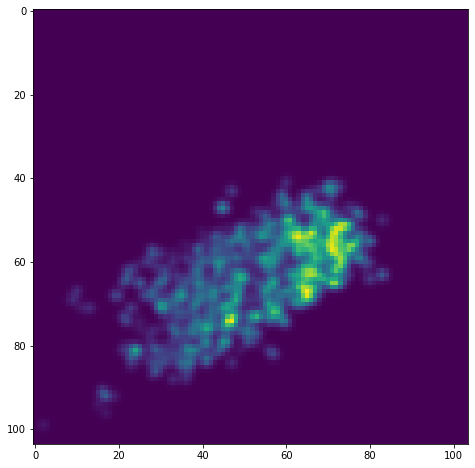

In-Silico GEX - Y-axis


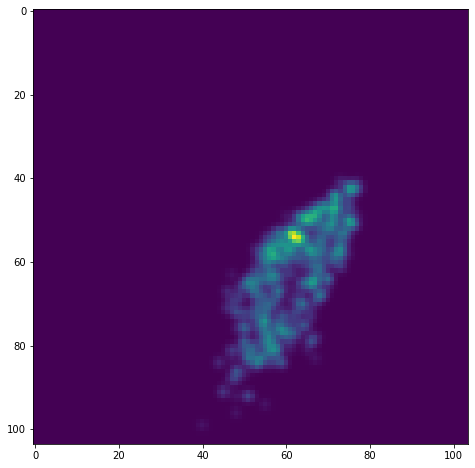

In-Silico GEX - Z-axis


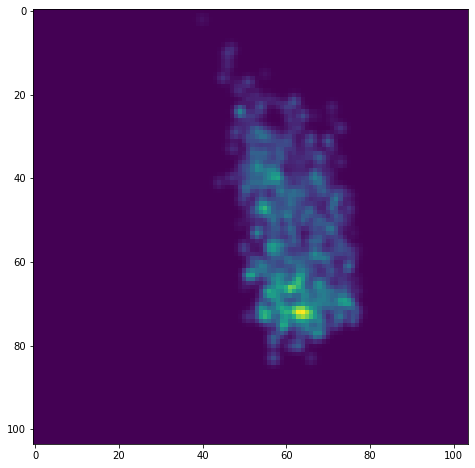

Alcam
Real GEX


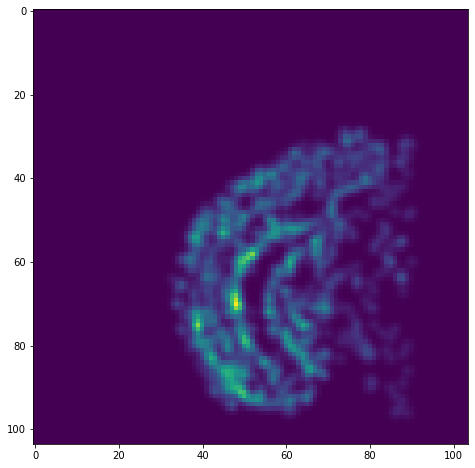

In-Silico GEX - X-axis


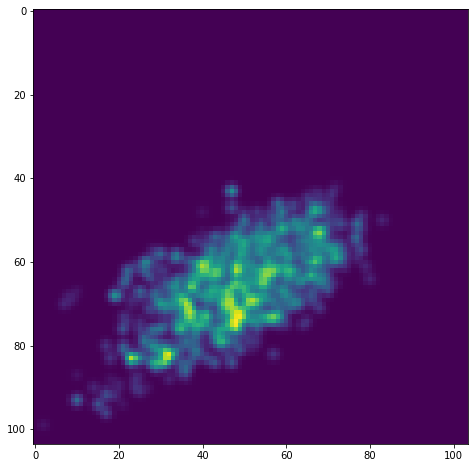

In-Silico GEX - Y-axis


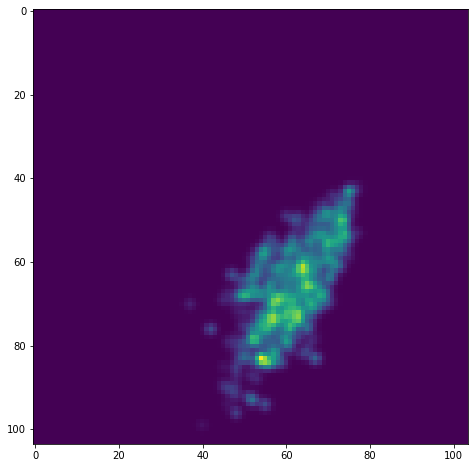

In-Silico GEX - Z-axis


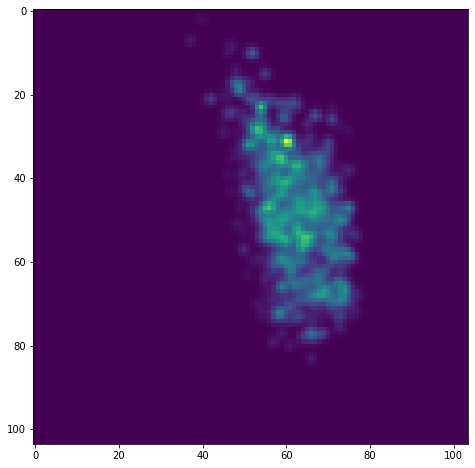

Timp2
Real GEX


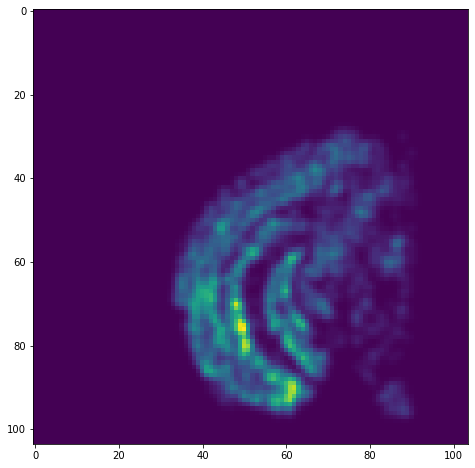

In-Silico GEX - X-axis


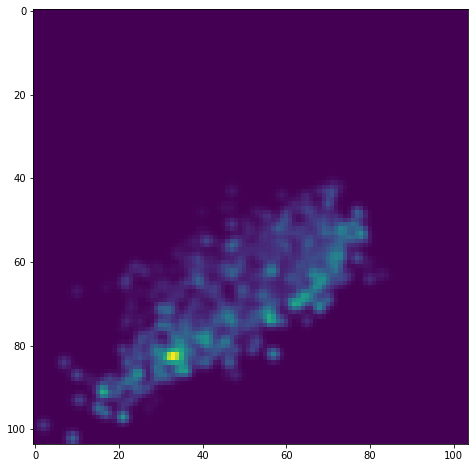

In-Silico GEX - Y-axis


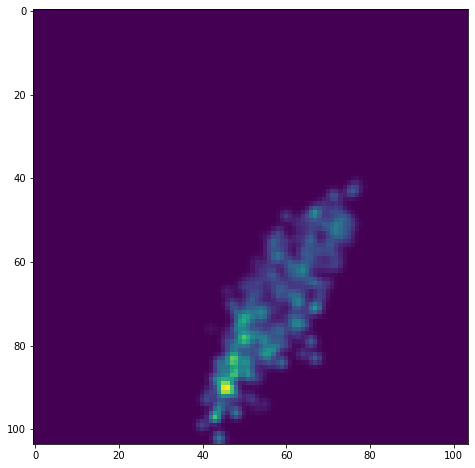

In-Silico GEX - Z-axis


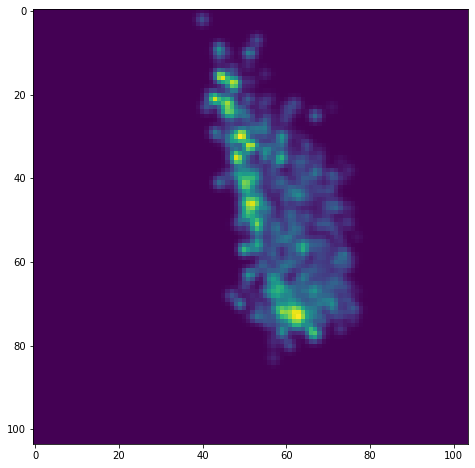

Zfp804b
Real GEX


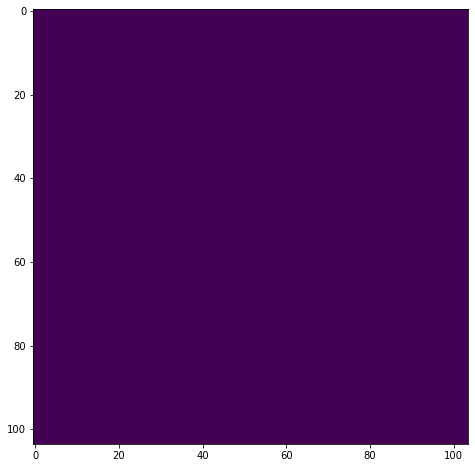

In-Silico GEX - X-axis


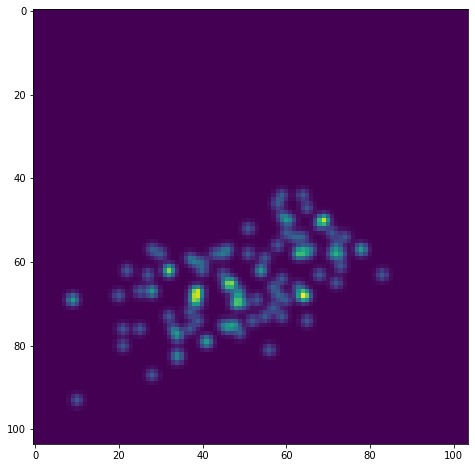

In-Silico GEX - Y-axis


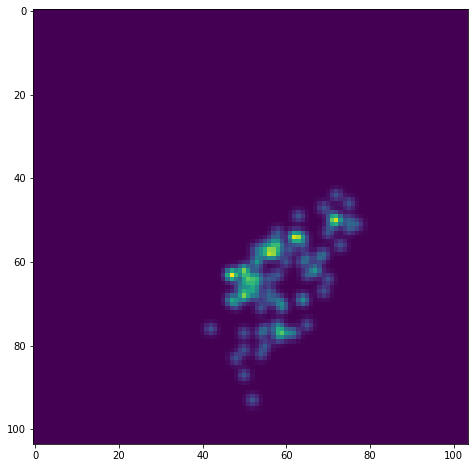

In-Silico GEX - Z-axis


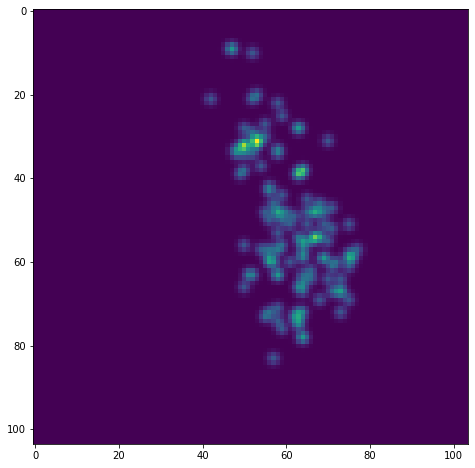

Marcksl1
Real GEX


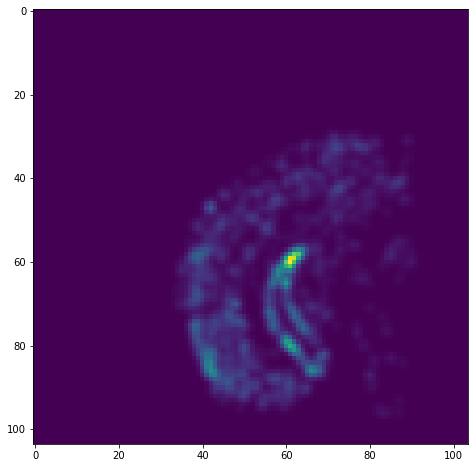

In-Silico GEX - X-axis


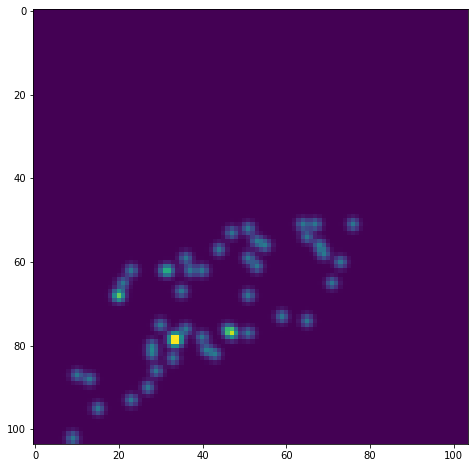

In-Silico GEX - Y-axis


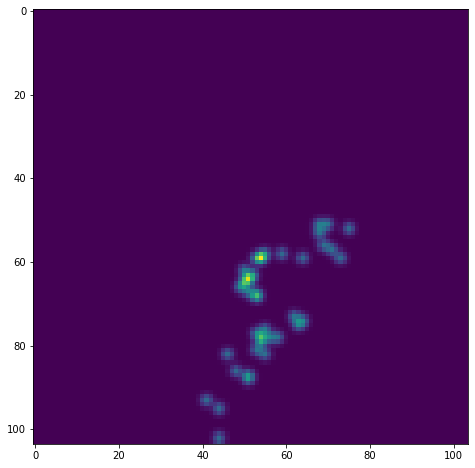

In-Silico GEX - Z-axis


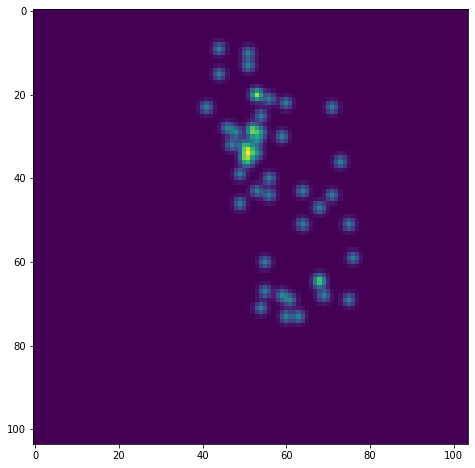

Kctd1
Real GEX


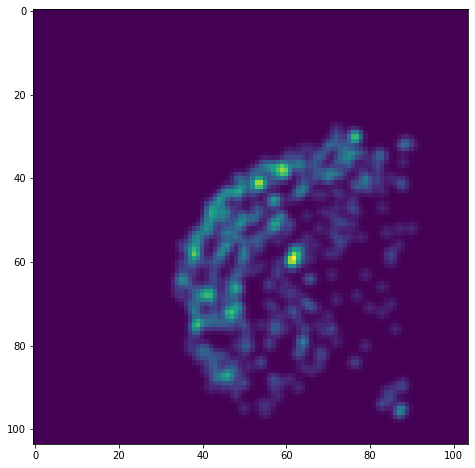

In-Silico GEX - X-axis


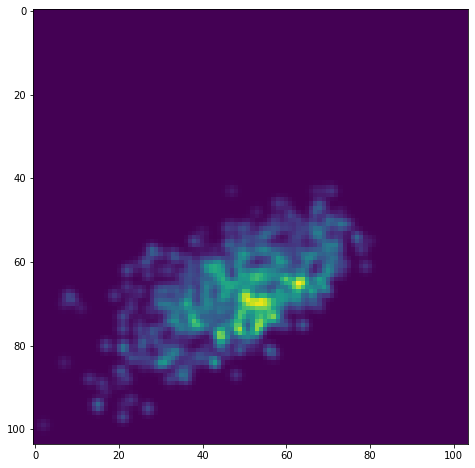

In-Silico GEX - Y-axis


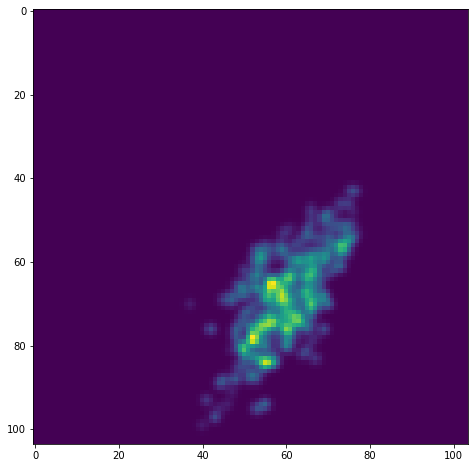

In-Silico GEX - Z-axis


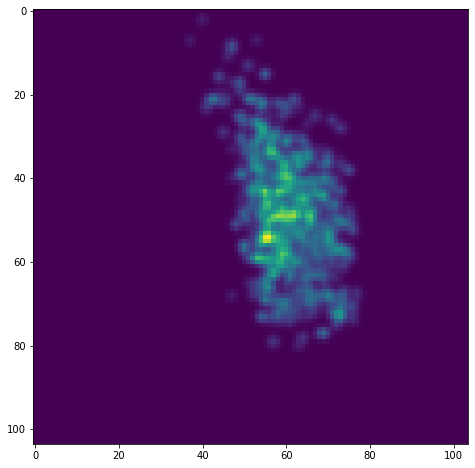

Ptprk
Real GEX


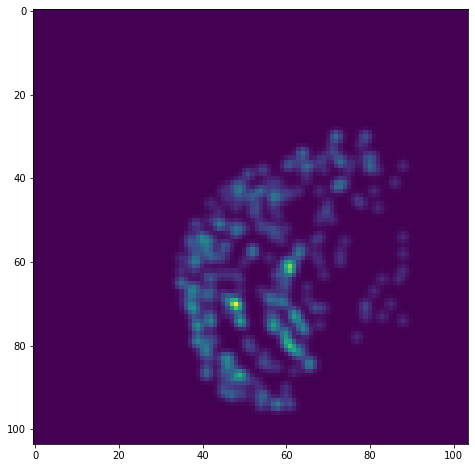

In-Silico GEX - X-axis


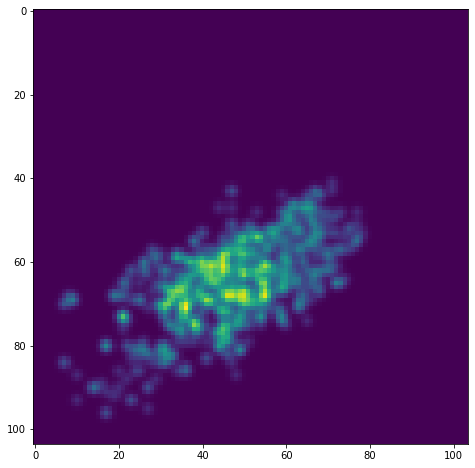

In-Silico GEX - Y-axis


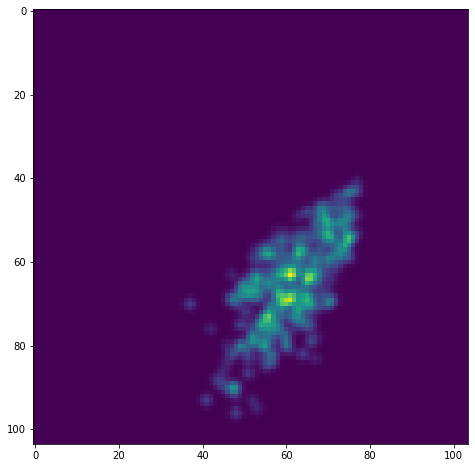

In-Silico GEX - Z-axis


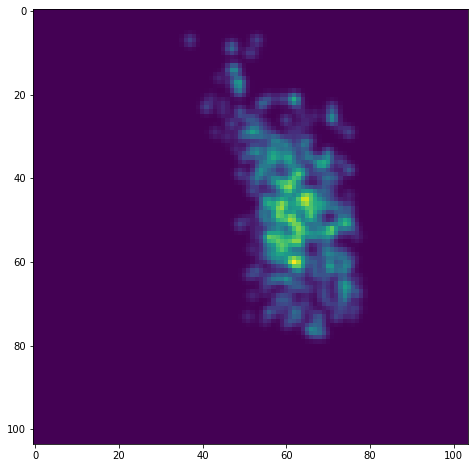

Sgcd
Real GEX


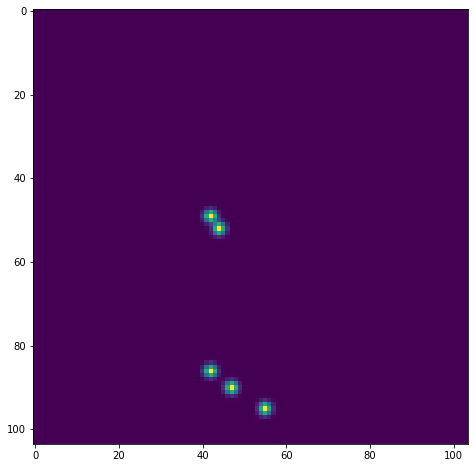

In-Silico GEX - X-axis


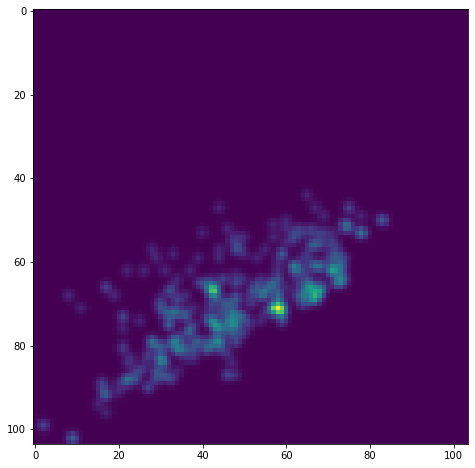

In-Silico GEX - Y-axis


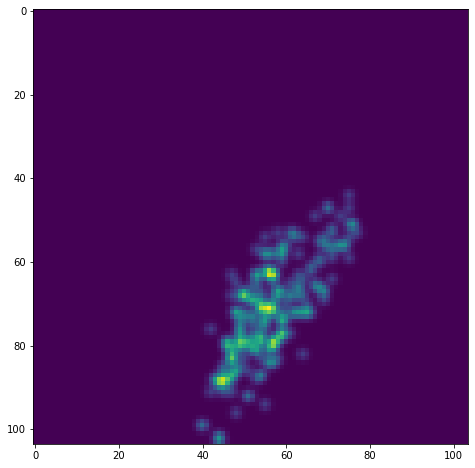

In-Silico GEX - Z-axis


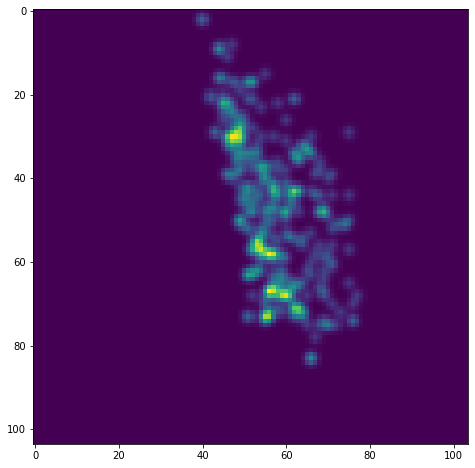

Efna5
Real GEX


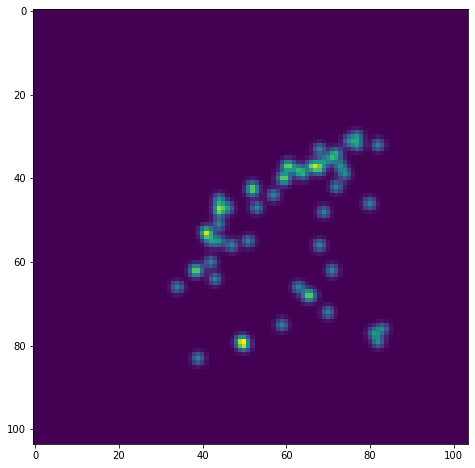

In-Silico GEX - X-axis


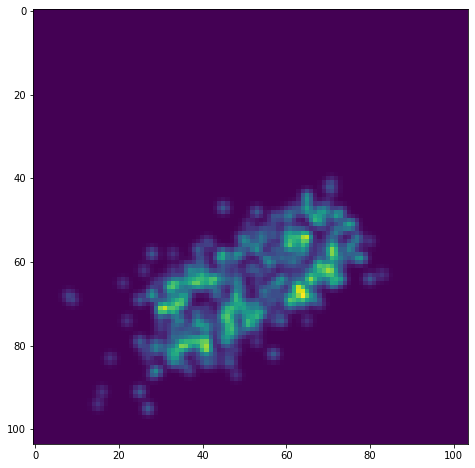

In-Silico GEX - Y-axis


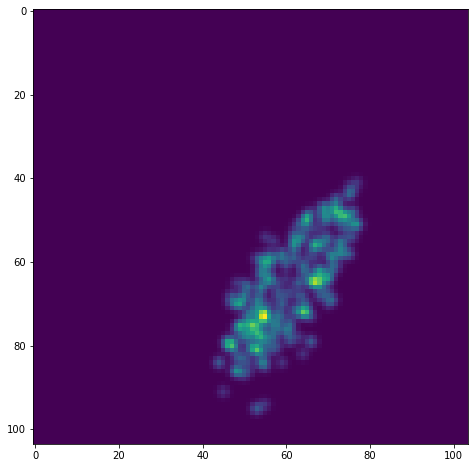

In-Silico GEX - Z-axis


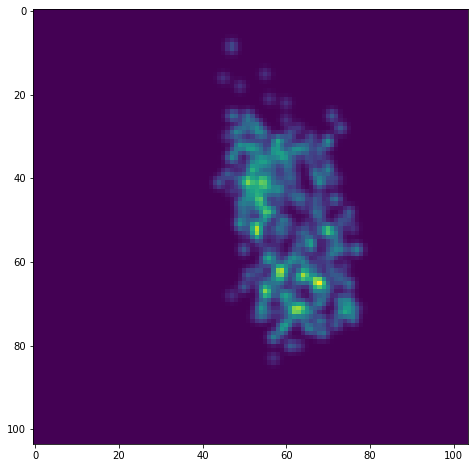

Syt17
Real GEX


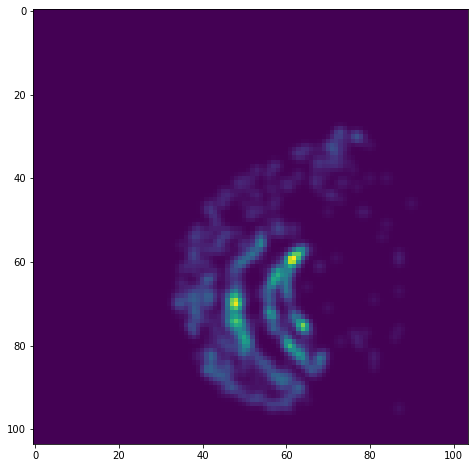

In-Silico GEX - X-axis


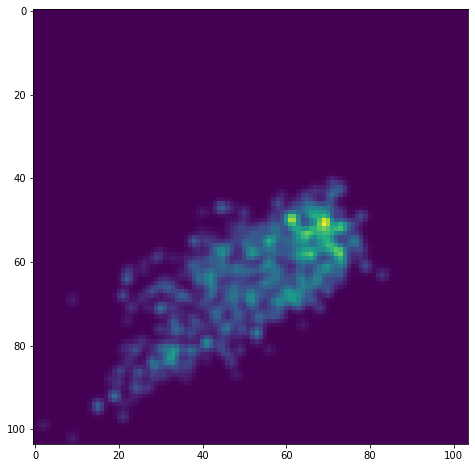

In-Silico GEX - Y-axis


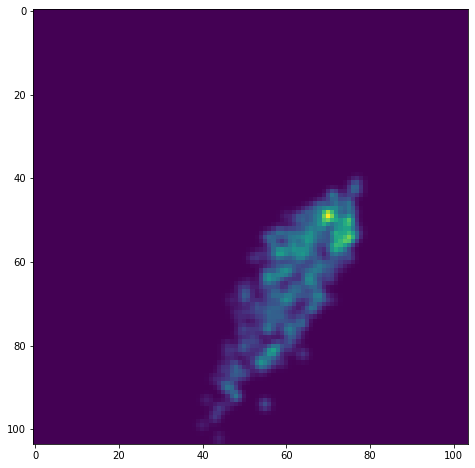

In-Silico GEX - Z-axis


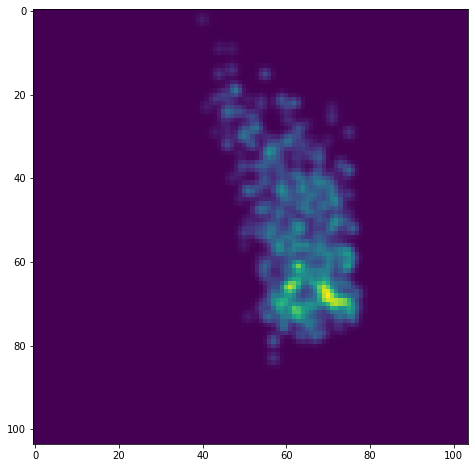

Olfm3
Real GEX


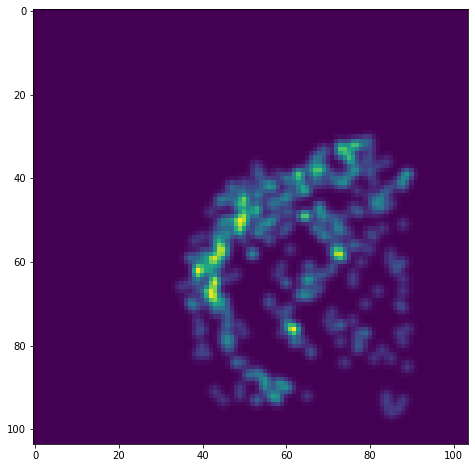

In-Silico GEX - X-axis


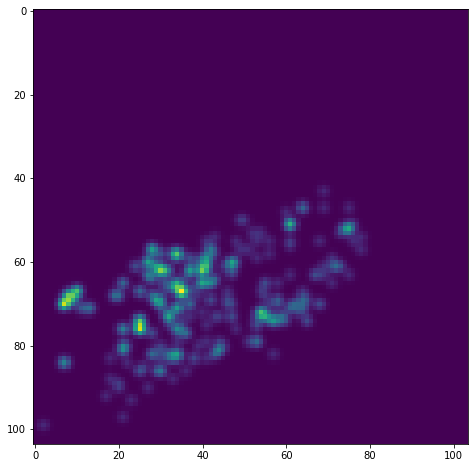

In-Silico GEX - Y-axis


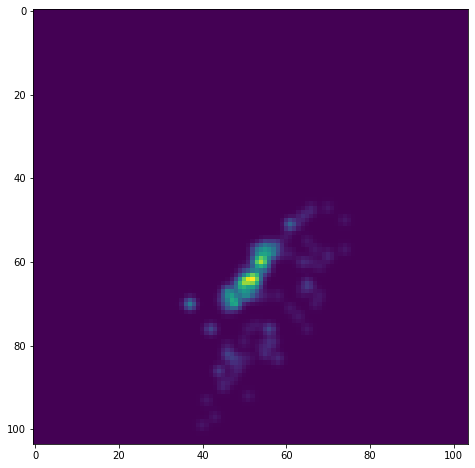

In-Silico GEX - Z-axis


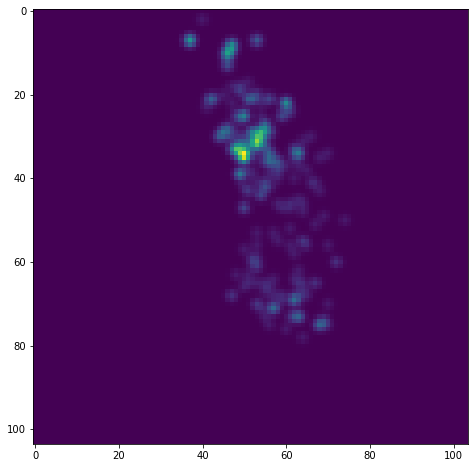

Trhde
Real GEX


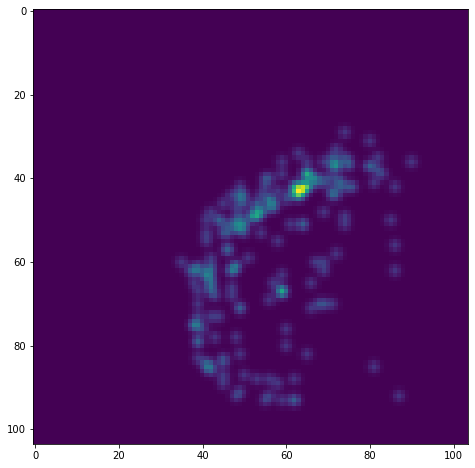

In-Silico GEX - X-axis


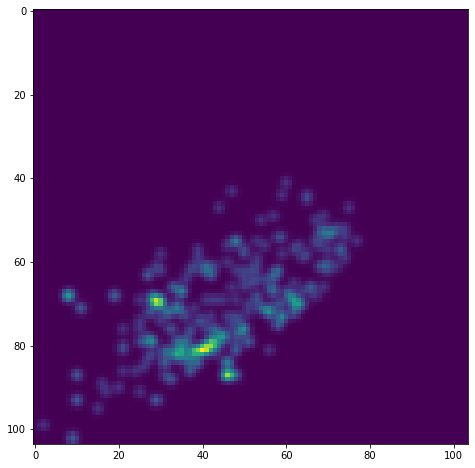

In-Silico GEX - Y-axis


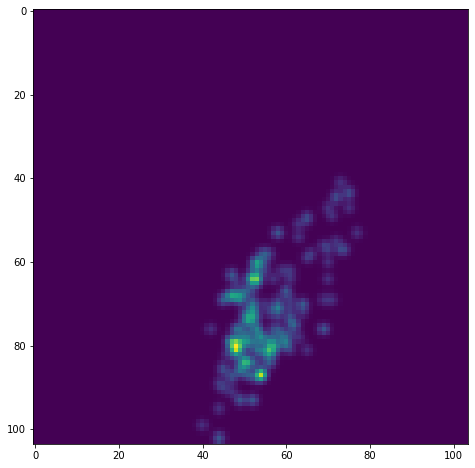

In-Silico GEX - Z-axis


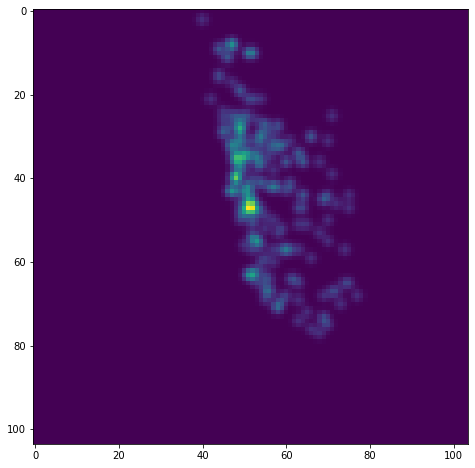

Pam
Real GEX


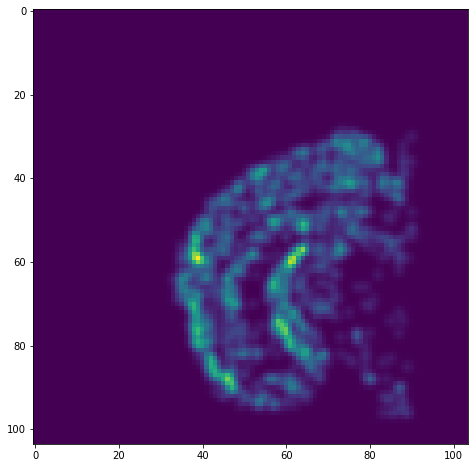

In-Silico GEX - X-axis


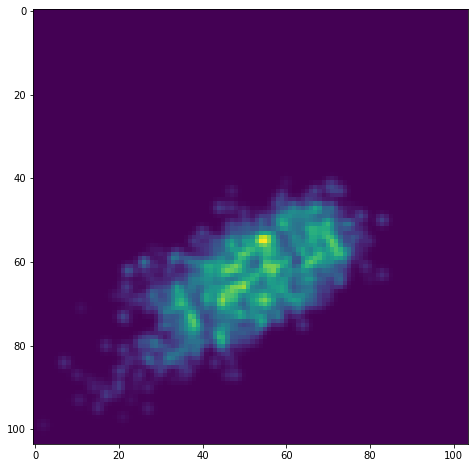

In-Silico GEX - Y-axis


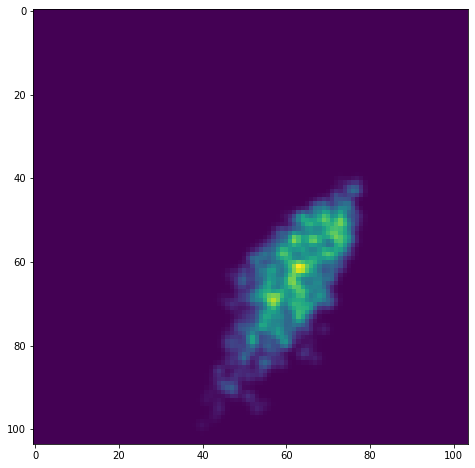

In-Silico GEX - Z-axis


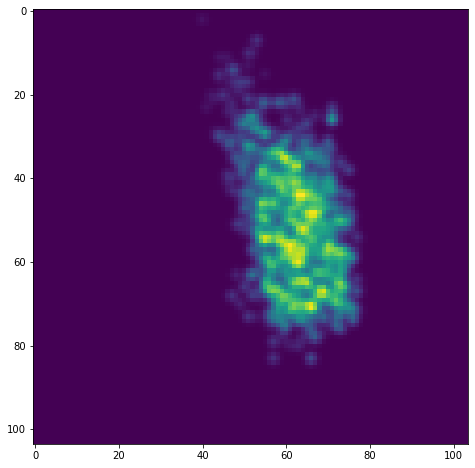

Slc24a2
Real GEX


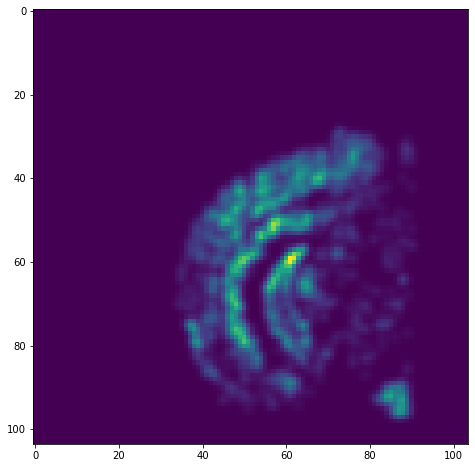

In-Silico GEX - X-axis


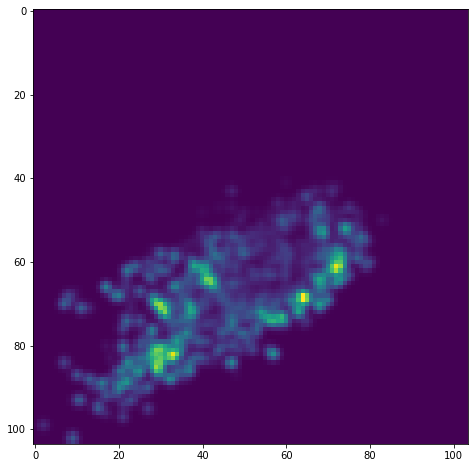

In-Silico GEX - Y-axis


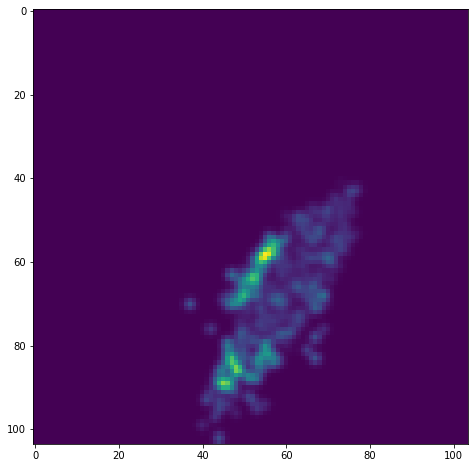

In-Silico GEX - Z-axis


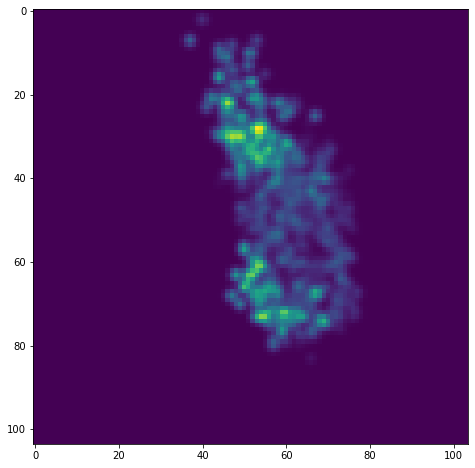

Spock3
Real GEX


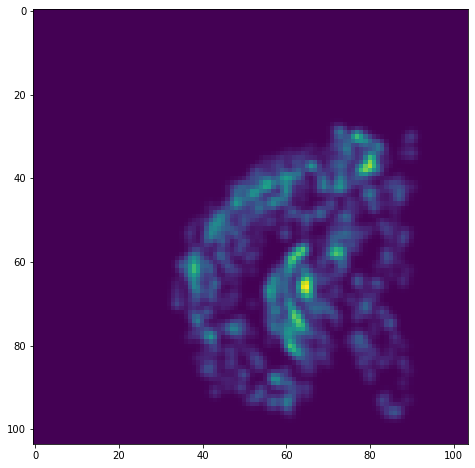

In-Silico GEX - X-axis


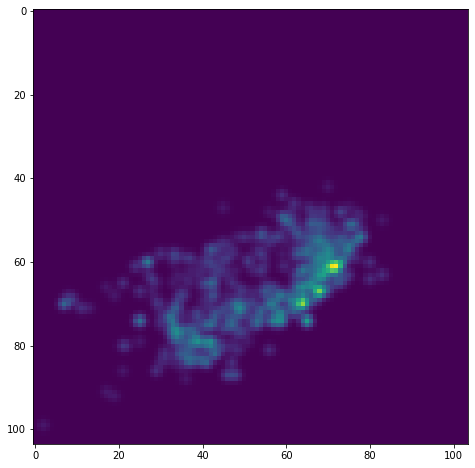

In-Silico GEX - Y-axis


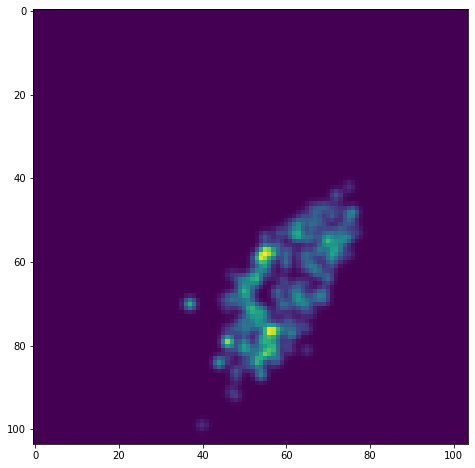

In-Silico GEX - Z-axis


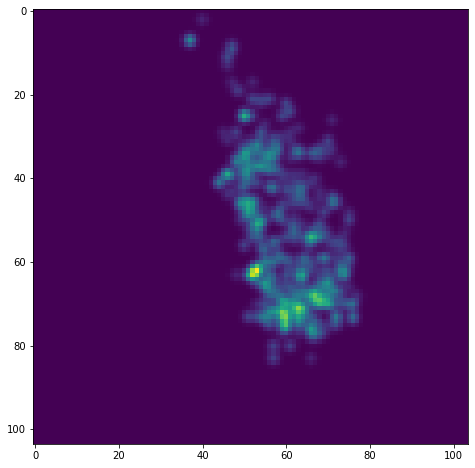

Tmtc2
Real GEX


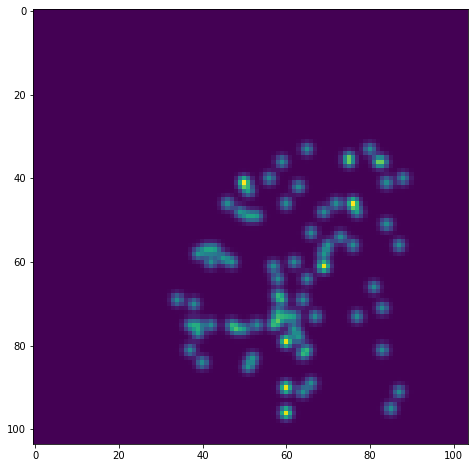

In-Silico GEX - X-axis


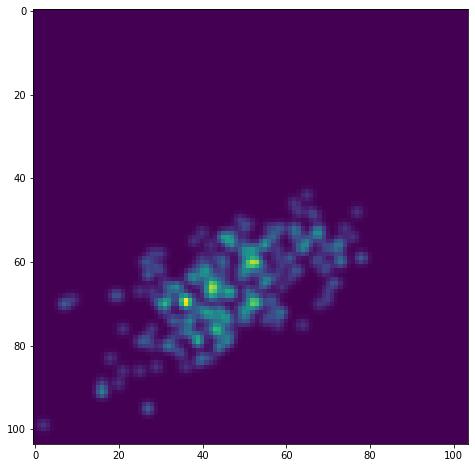

In-Silico GEX - Y-axis


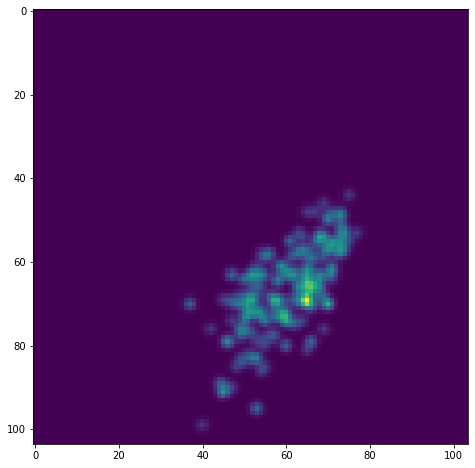

In-Silico GEX - Z-axis


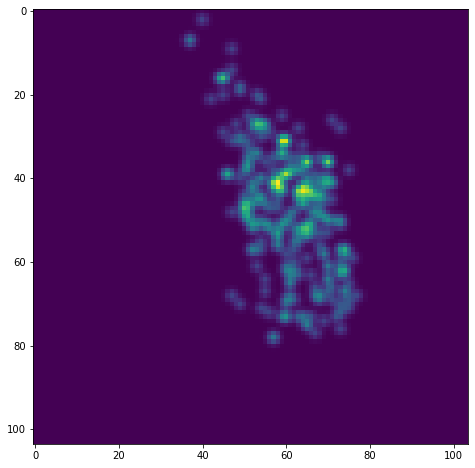

Dcc
Real GEX


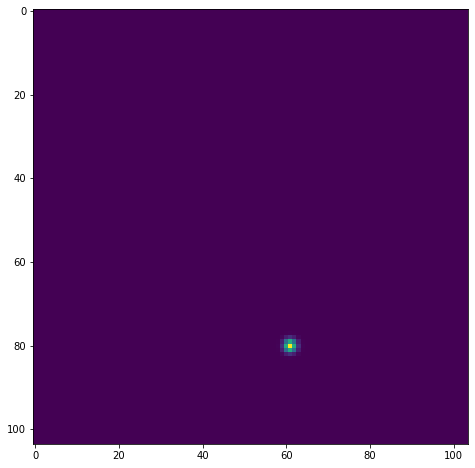

In-Silico GEX - X-axis


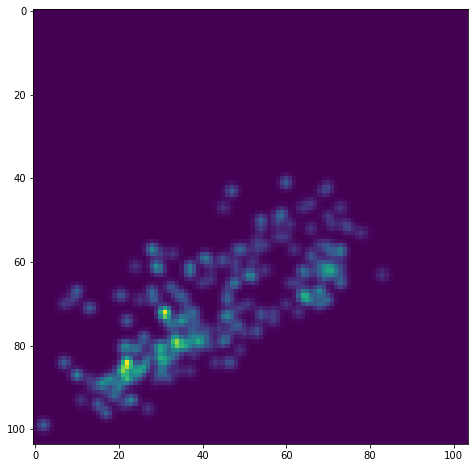

In-Silico GEX - Y-axis


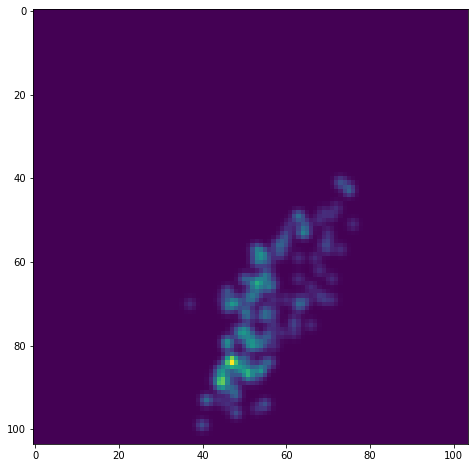

In-Silico GEX - Z-axis


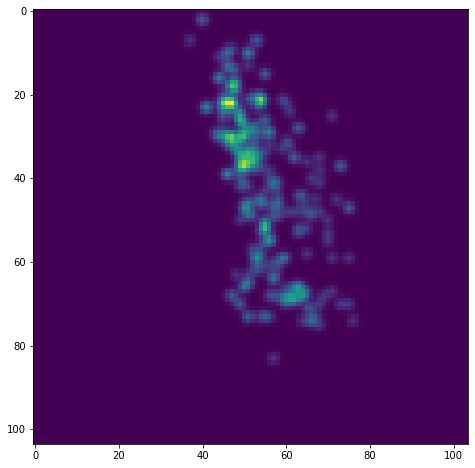

Grin3a
Real GEX


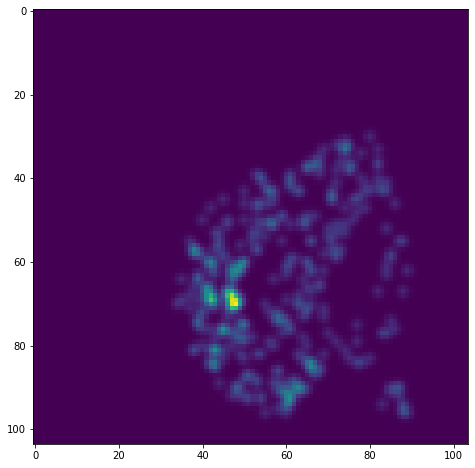

In-Silico GEX - X-axis


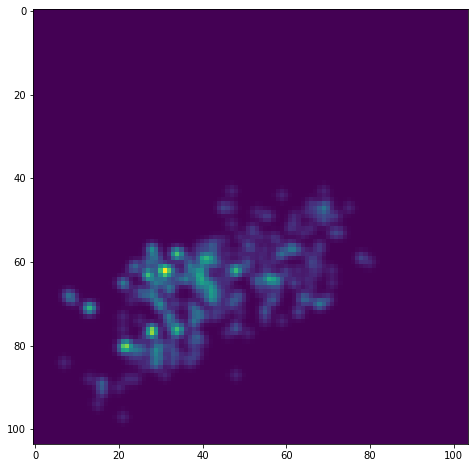

In-Silico GEX - Y-axis


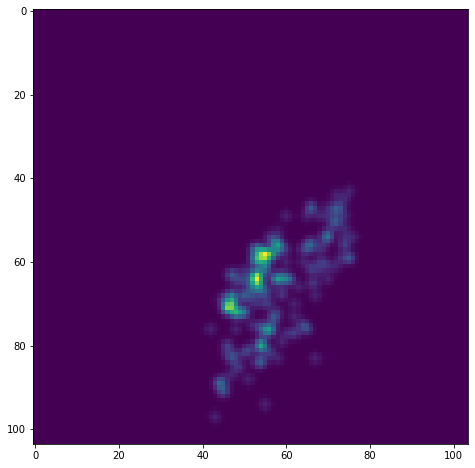

In-Silico GEX - Z-axis


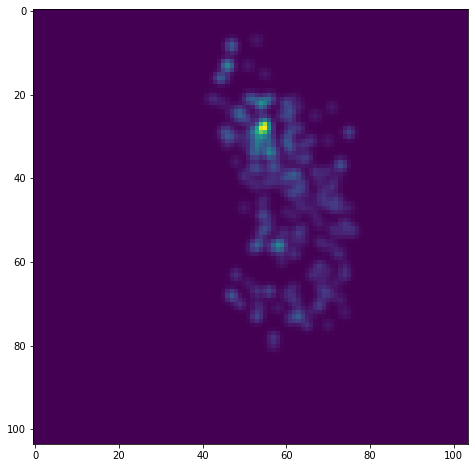

Car10
Real GEX


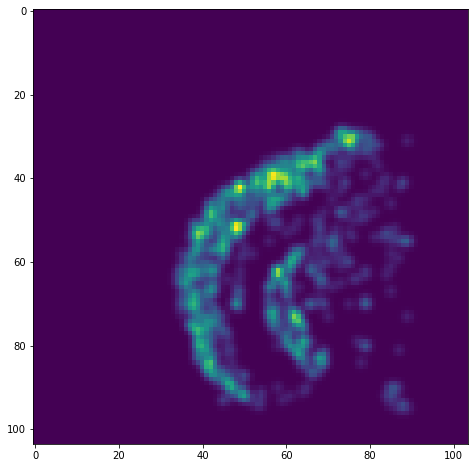

In-Silico GEX - X-axis


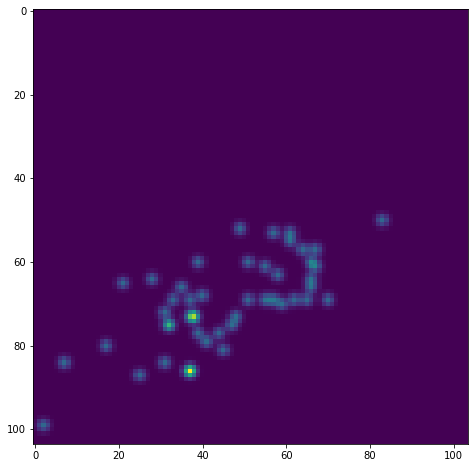

In-Silico GEX - Y-axis


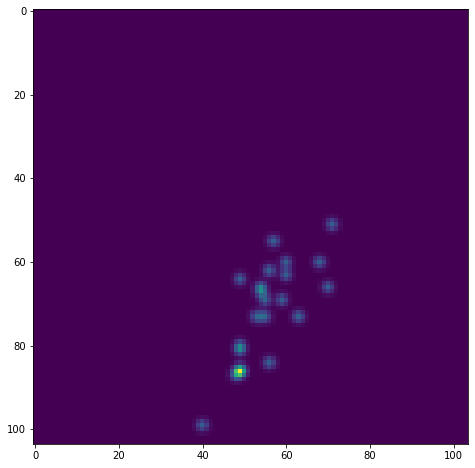

In-Silico GEX - Z-axis


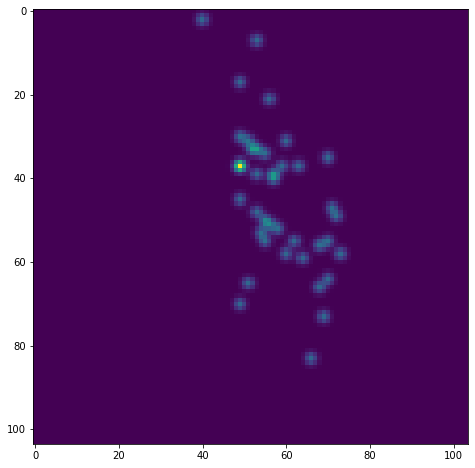

Nrg1
Real GEX


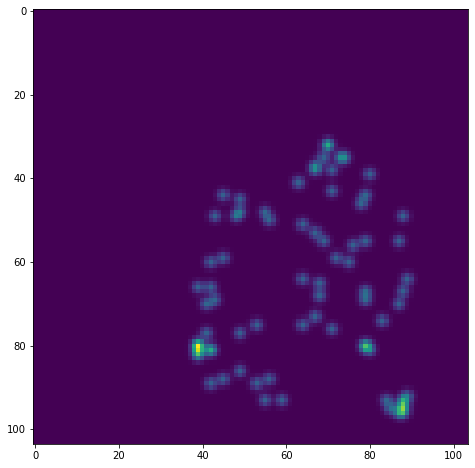

In-Silico GEX - X-axis


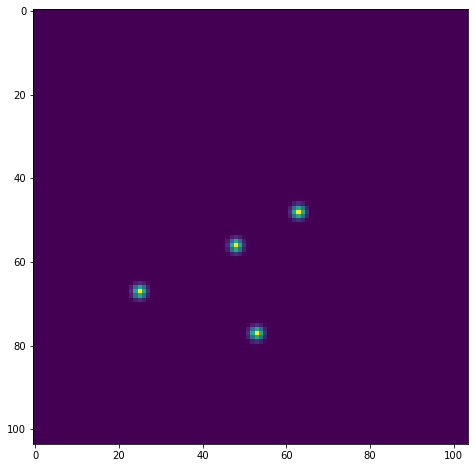

In-Silico GEX - Y-axis


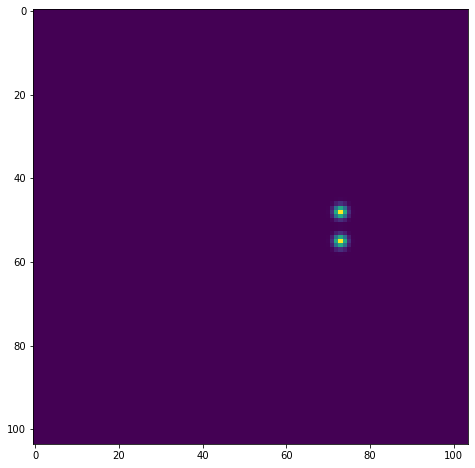

In-Silico GEX - Z-axis


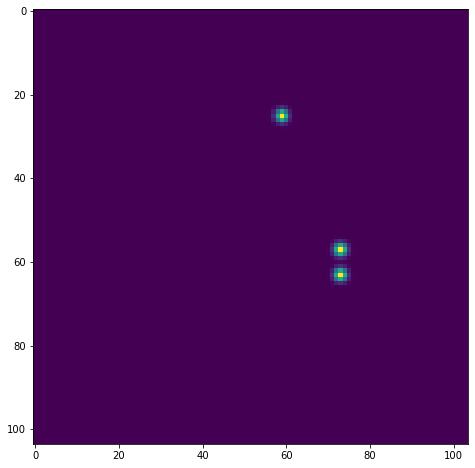

Prkca
Real GEX


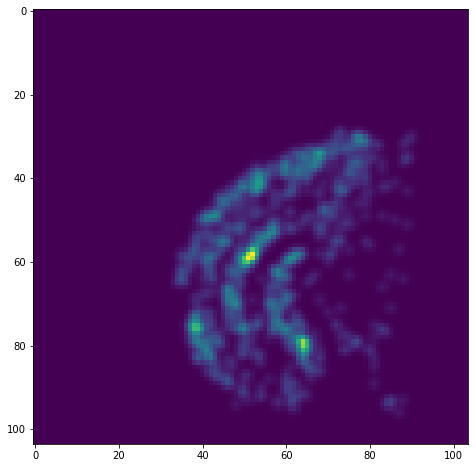

In-Silico GEX - X-axis


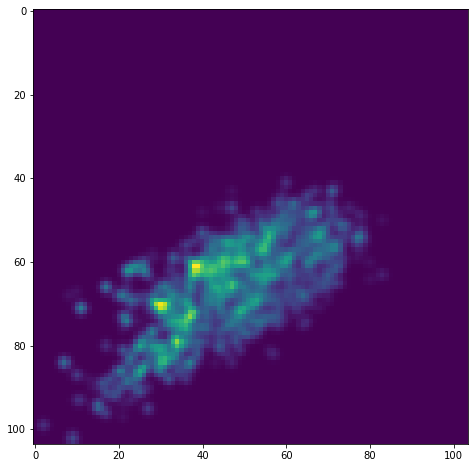

In-Silico GEX - Y-axis


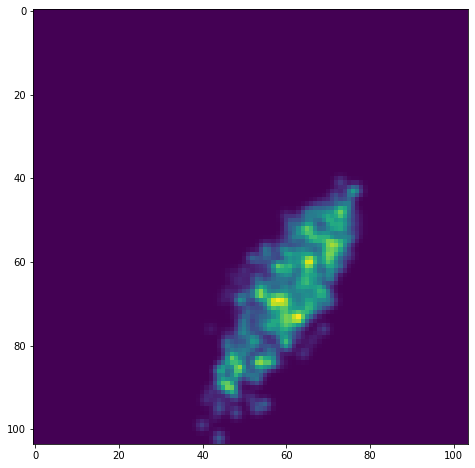

In-Silico GEX - Z-axis


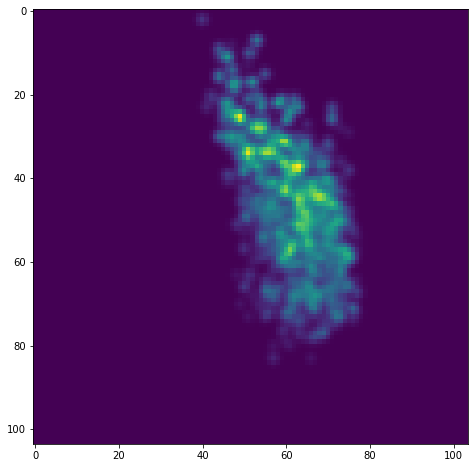

Ncald
Real GEX


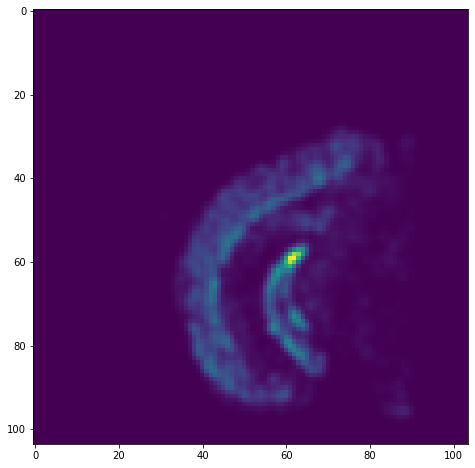

In-Silico GEX - X-axis


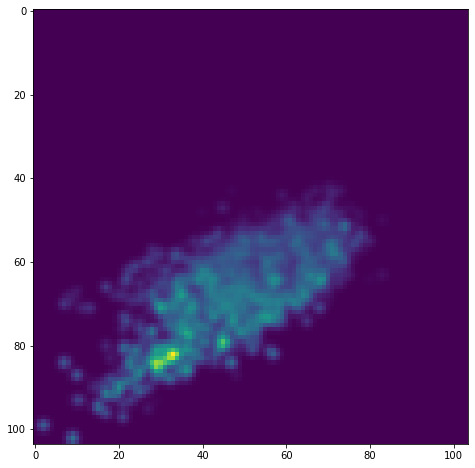

In-Silico GEX - Y-axis


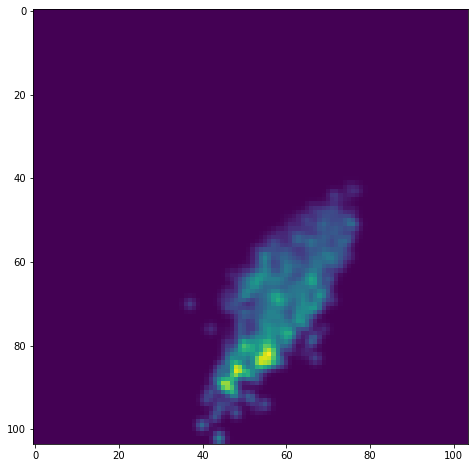

In-Silico GEX - Z-axis


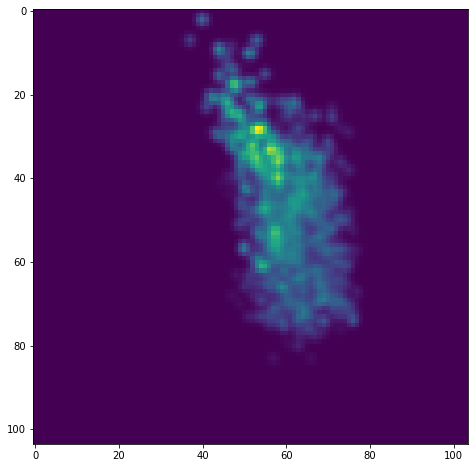

Htr2a
Real GEX


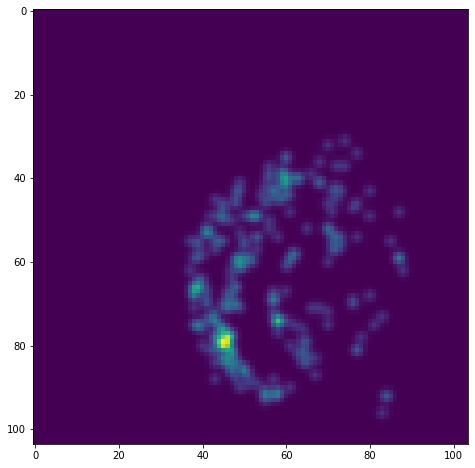

In-Silico GEX - X-axis


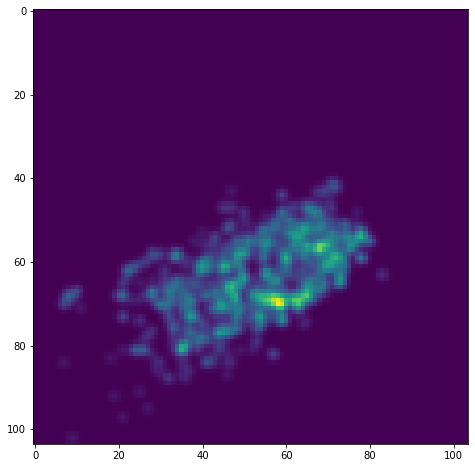

In-Silico GEX - Y-axis


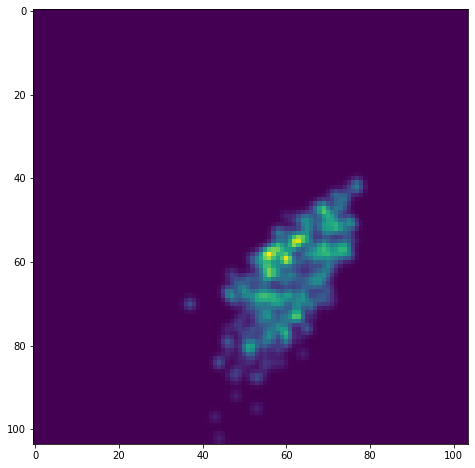

In-Silico GEX - Z-axis


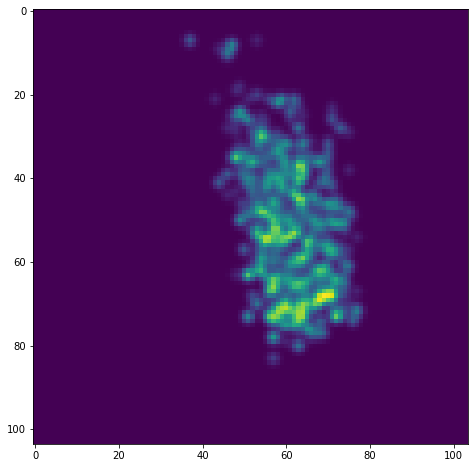

Syt2
Real GEX


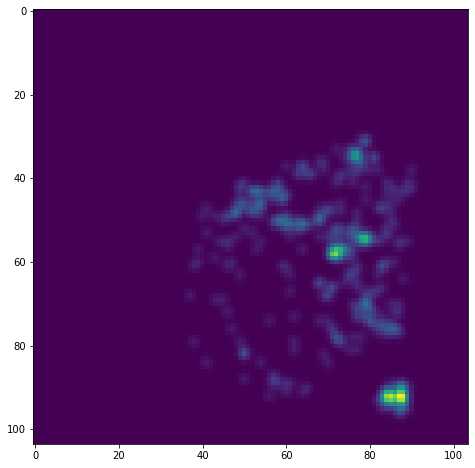

In-Silico GEX - X-axis


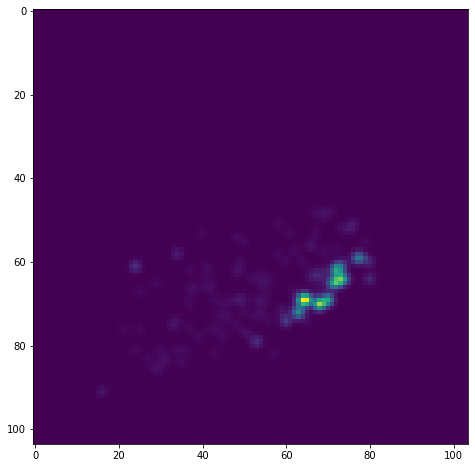

In-Silico GEX - Y-axis


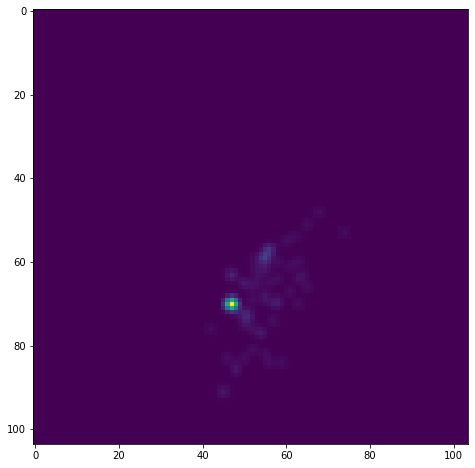

In-Silico GEX - Z-axis


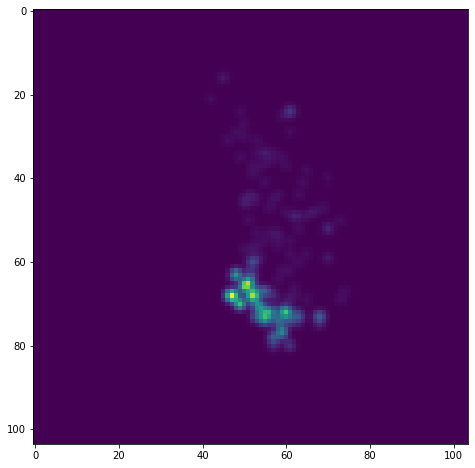

Nell1
Real GEX


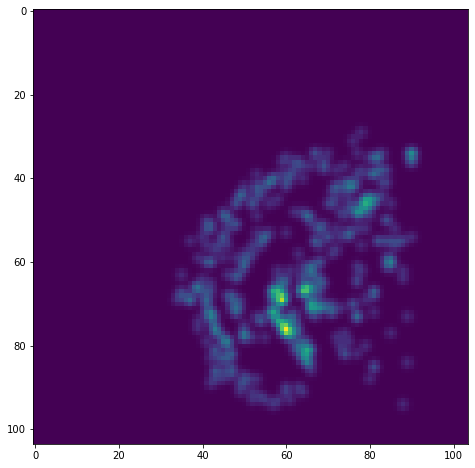

In-Silico GEX - X-axis


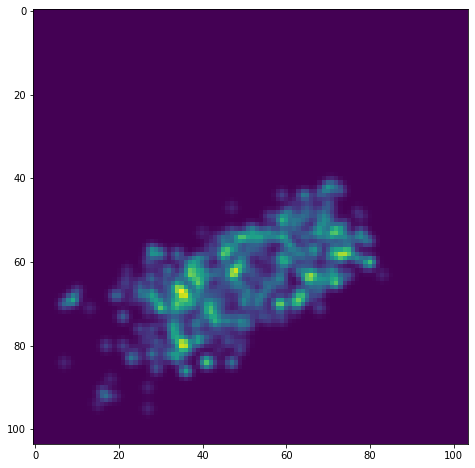

In-Silico GEX - Y-axis


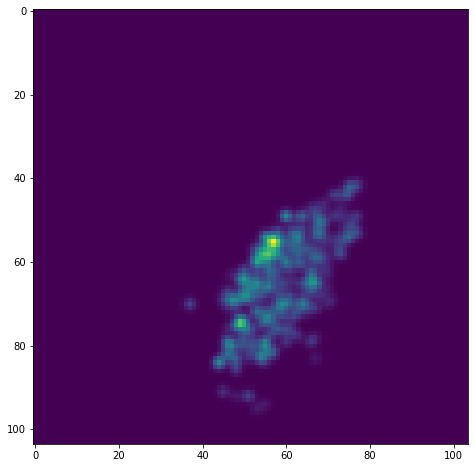

In-Silico GEX - Z-axis


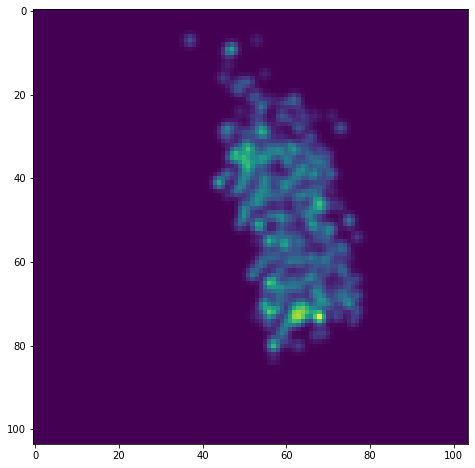

Sv2c
Real GEX


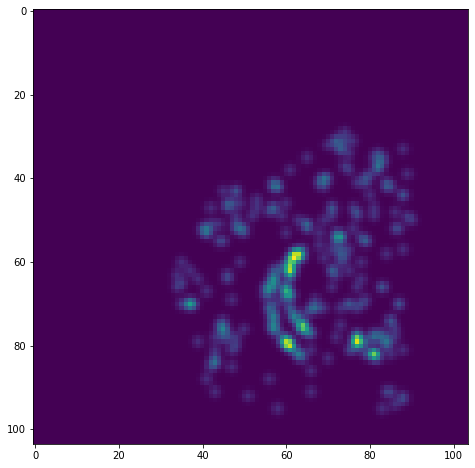

In-Silico GEX - X-axis


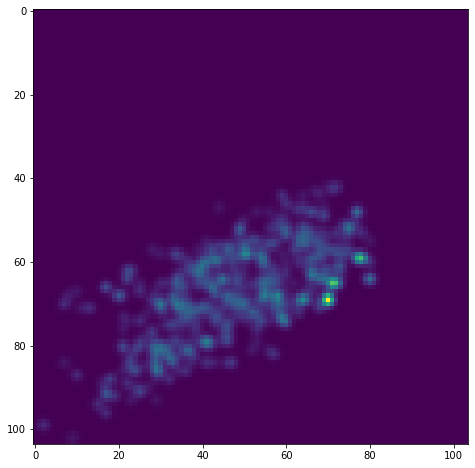

In-Silico GEX - Y-axis


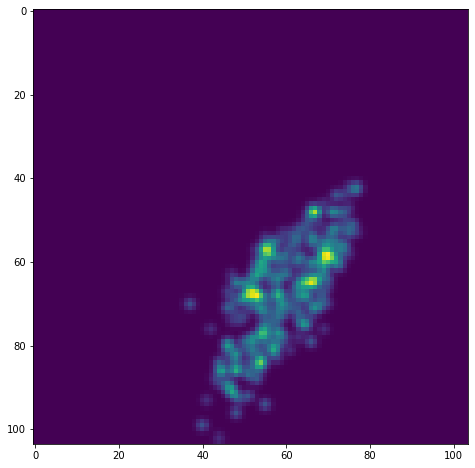

In-Silico GEX - Z-axis


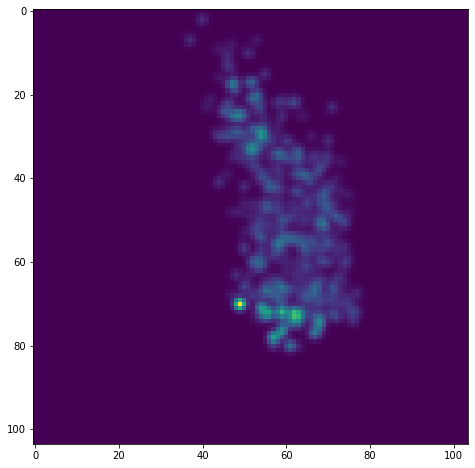

Rcan2
Real GEX


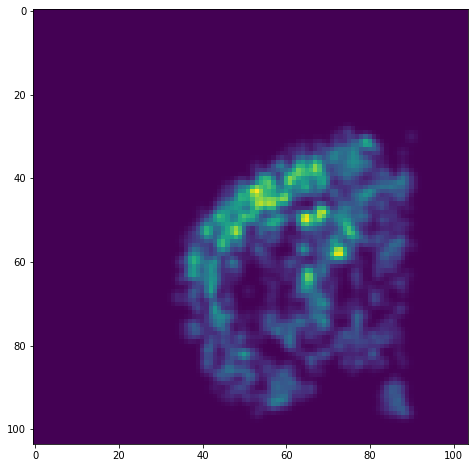

In-Silico GEX - X-axis


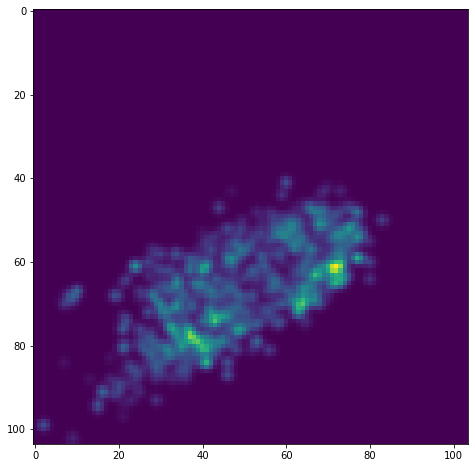

In-Silico GEX - Y-axis


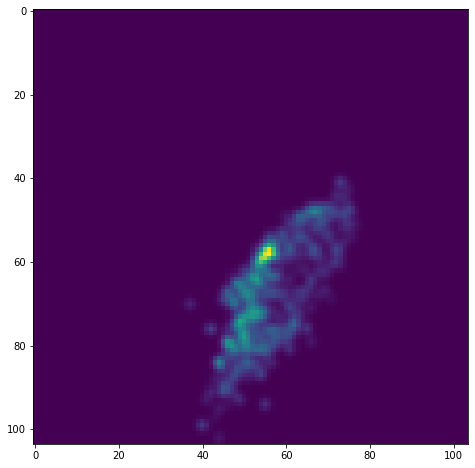

In-Silico GEX - Z-axis


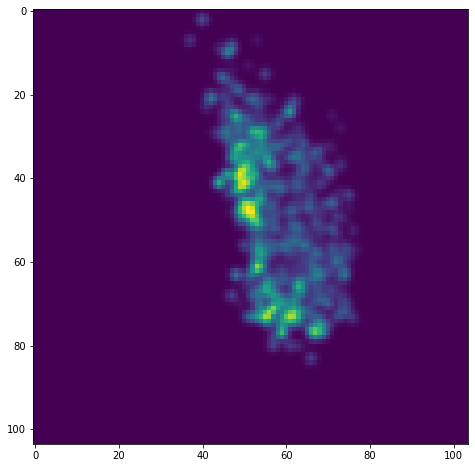

Reln
Real GEX


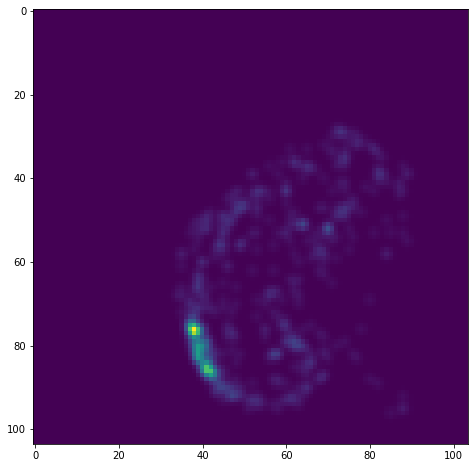

In-Silico GEX - X-axis


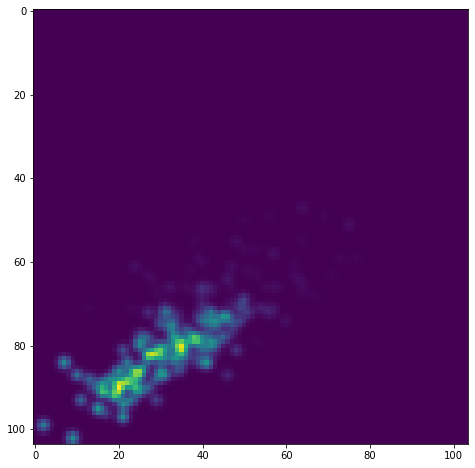

In-Silico GEX - Y-axis


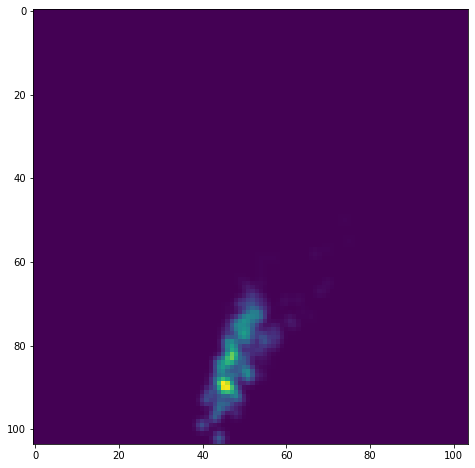

In-Silico GEX - Z-axis


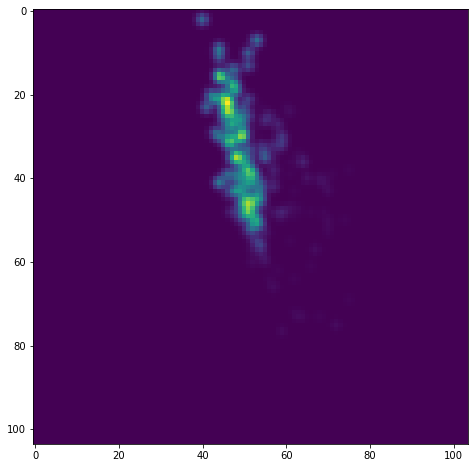

Gpc5
Real GEX


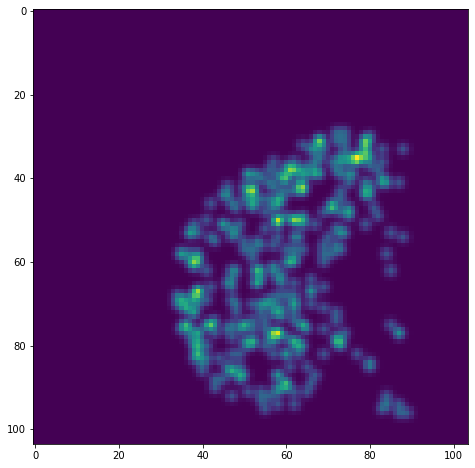

In-Silico GEX - X-axis


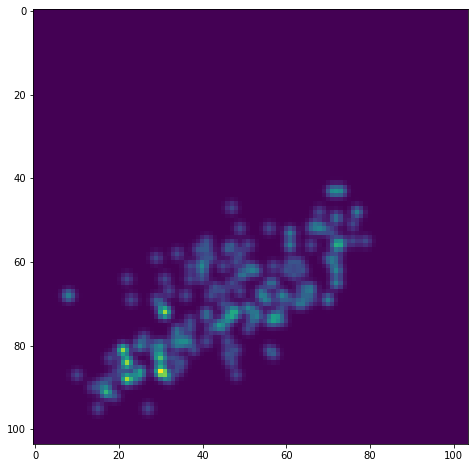

In-Silico GEX - Y-axis


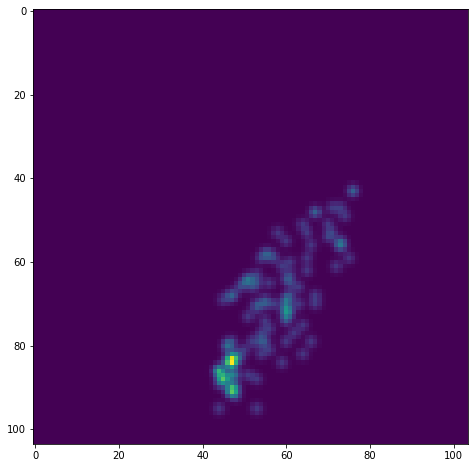

In-Silico GEX - Z-axis


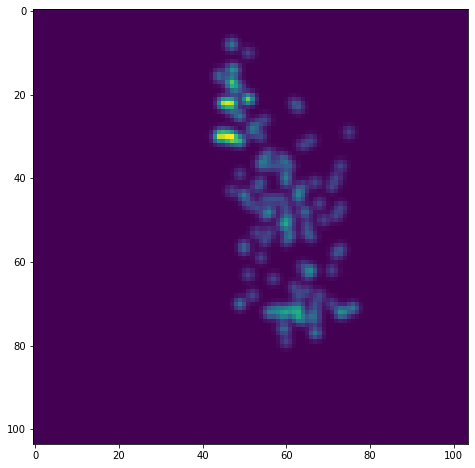

Lmo4
Real GEX


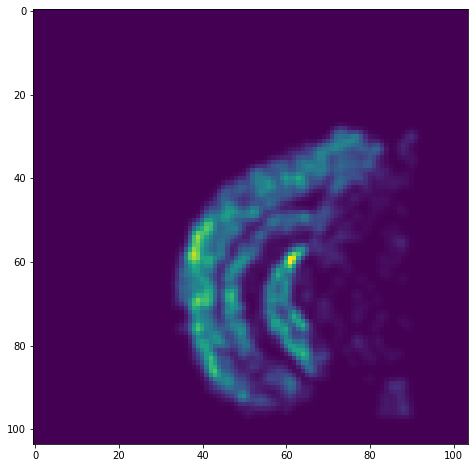

In-Silico GEX - X-axis


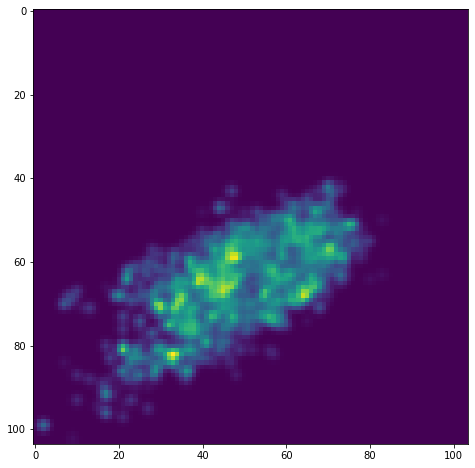

In-Silico GEX - Y-axis


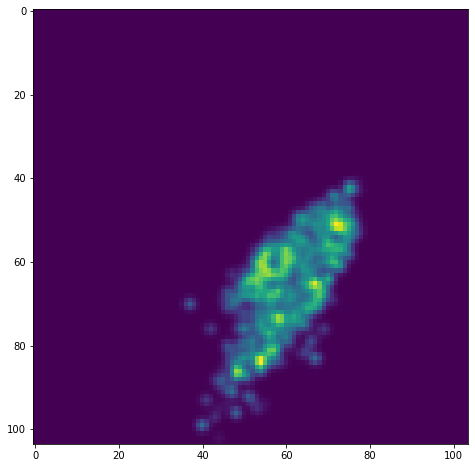

In-Silico GEX - Z-axis


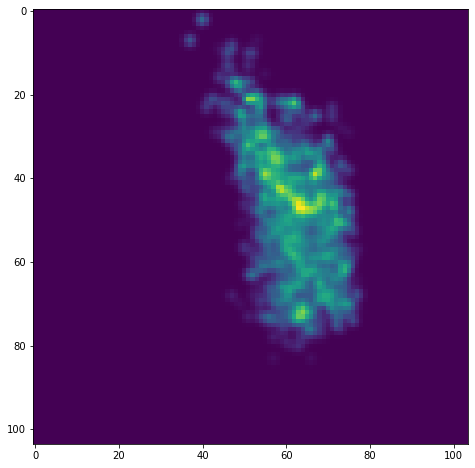

Scnn1a
Real GEX


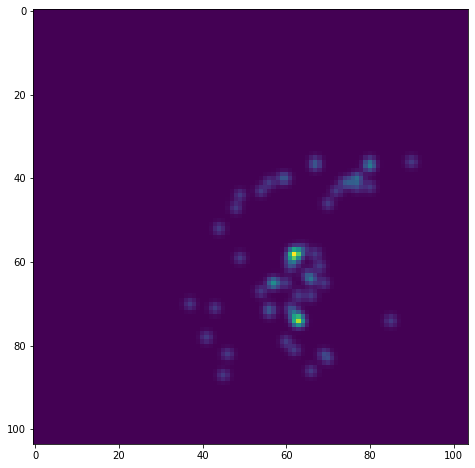

In-Silico GEX - X-axis


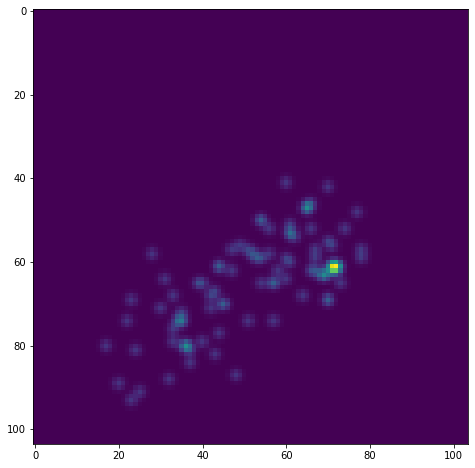

In-Silico GEX - Y-axis


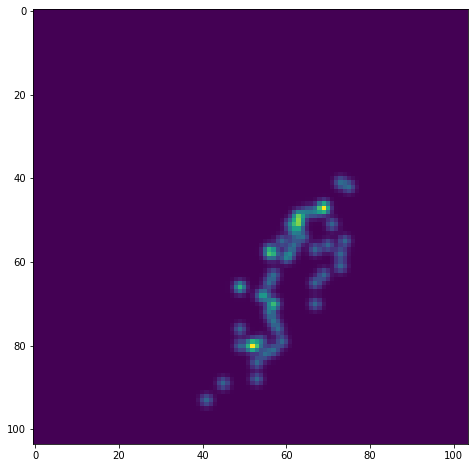

In-Silico GEX - Z-axis


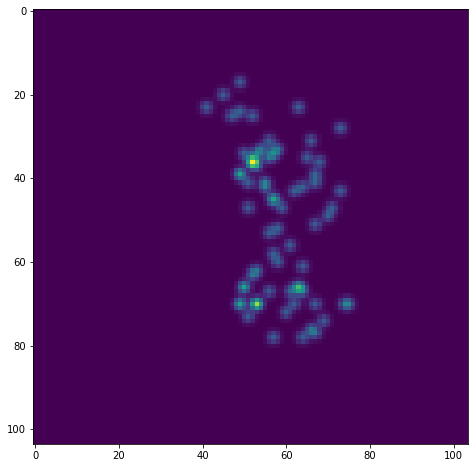

Actb
Real GEX


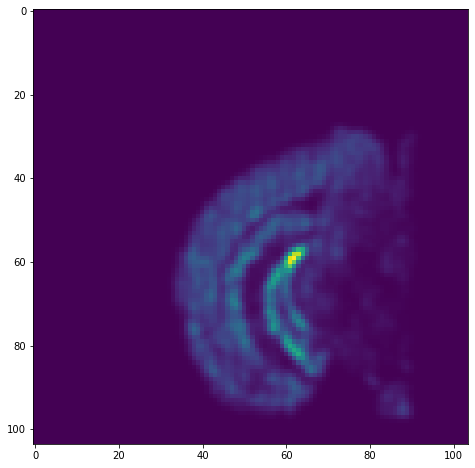

In-Silico GEX - X-axis


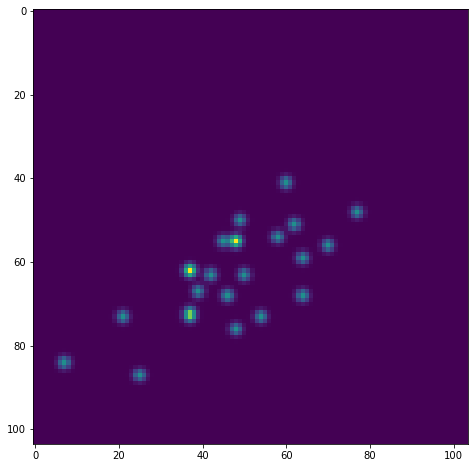

In-Silico GEX - Y-axis


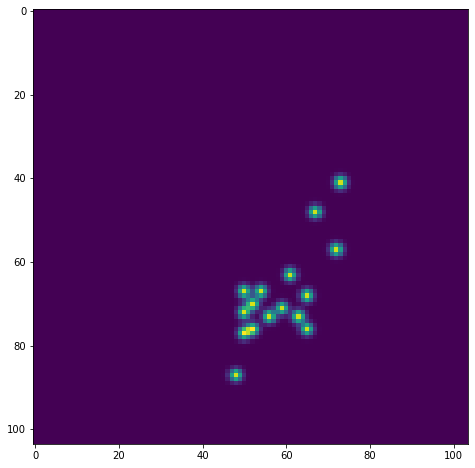

In-Silico GEX - Z-axis


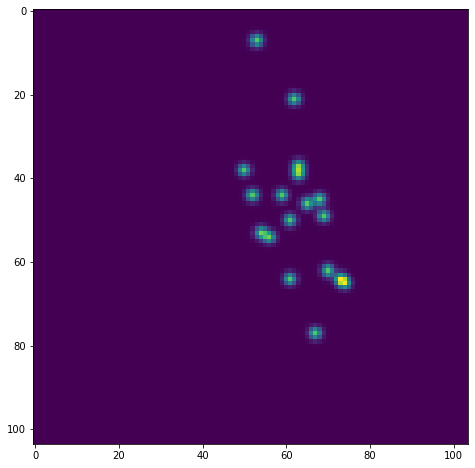

Cux2
Real GEX


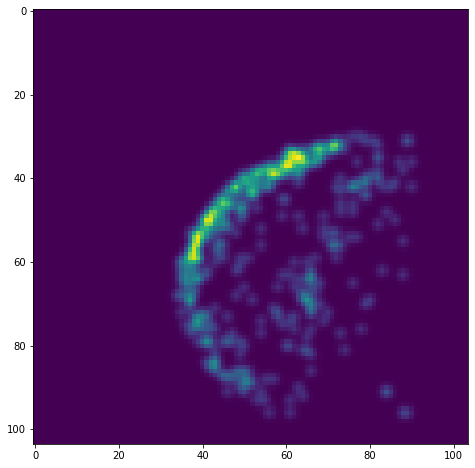

In-Silico GEX - X-axis


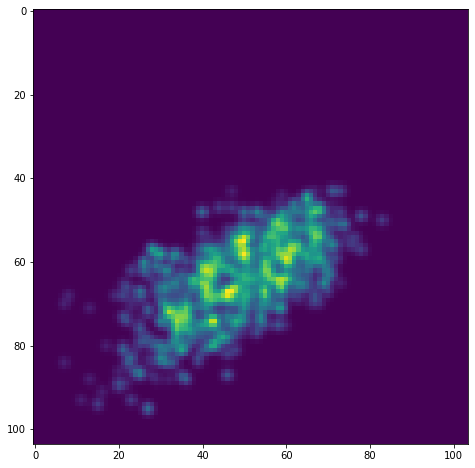

In-Silico GEX - Y-axis


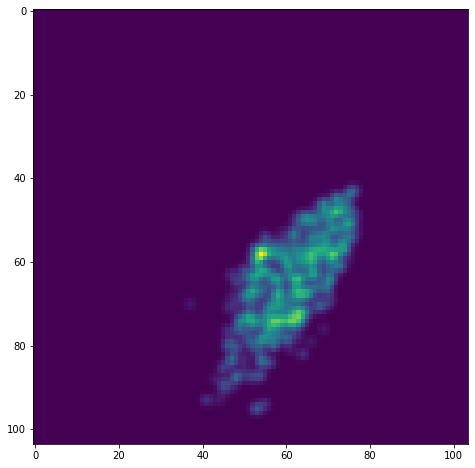

In-Silico GEX - Z-axis


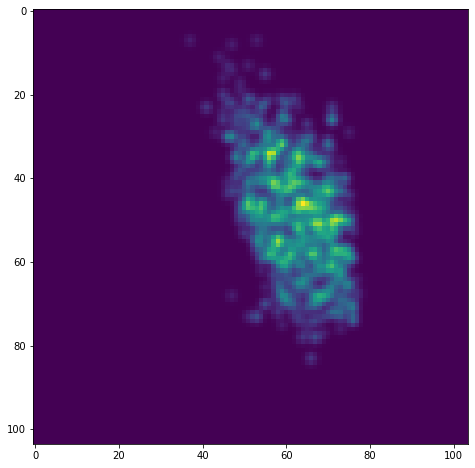

Lrrtm4
Real GEX


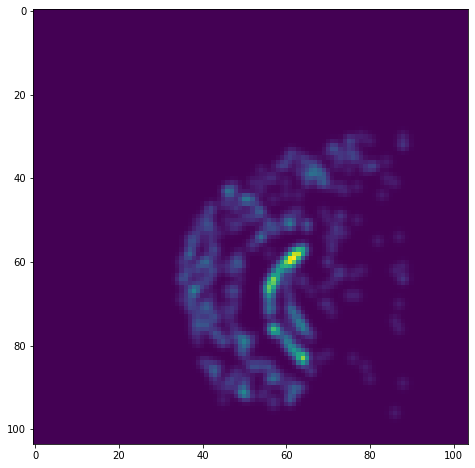

In-Silico GEX - X-axis


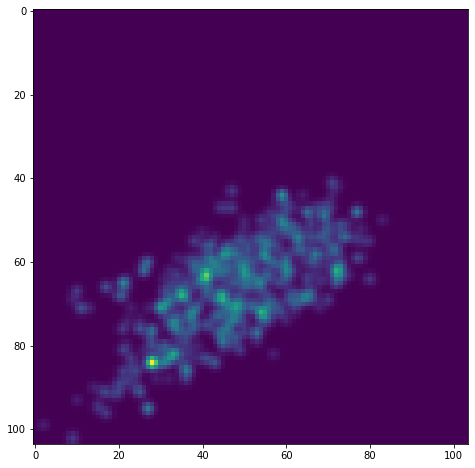

In-Silico GEX - Y-axis


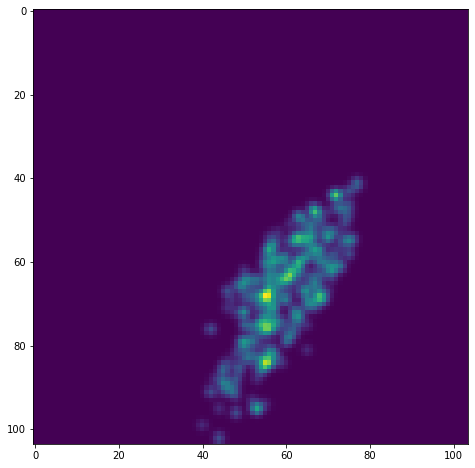

In-Silico GEX - Z-axis


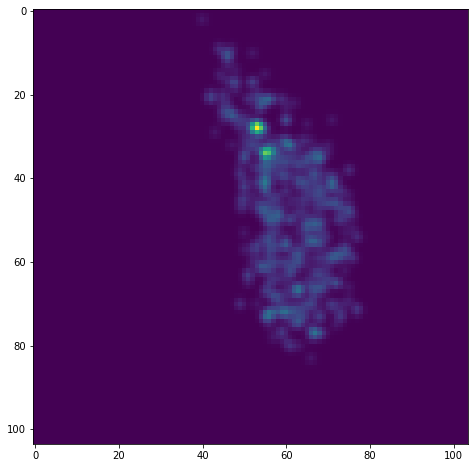

Rora
Real GEX


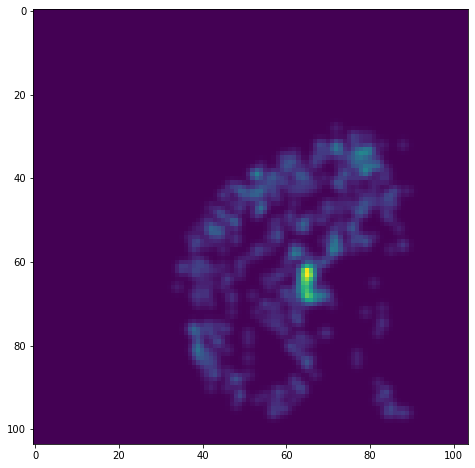

In-Silico GEX - X-axis


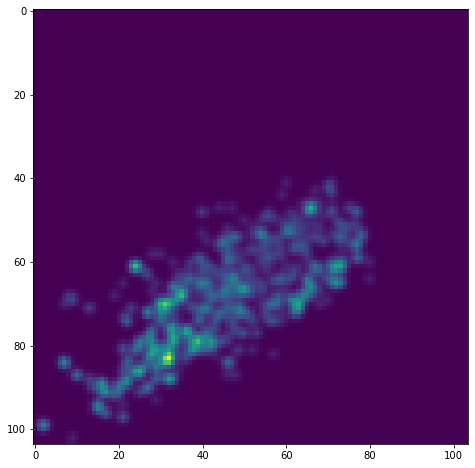

In-Silico GEX - Y-axis


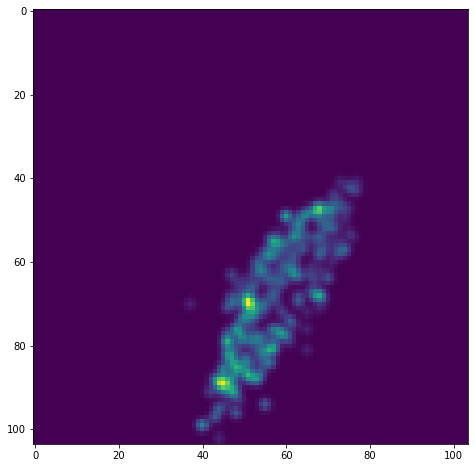

In-Silico GEX - Z-axis


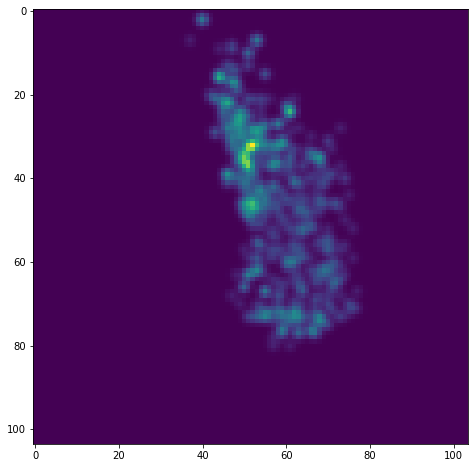

Fat3
Real GEX


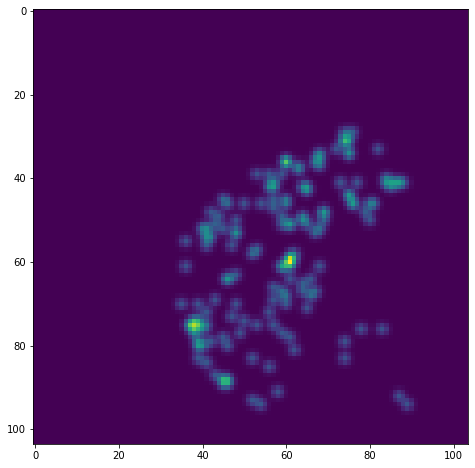

In-Silico GEX - X-axis


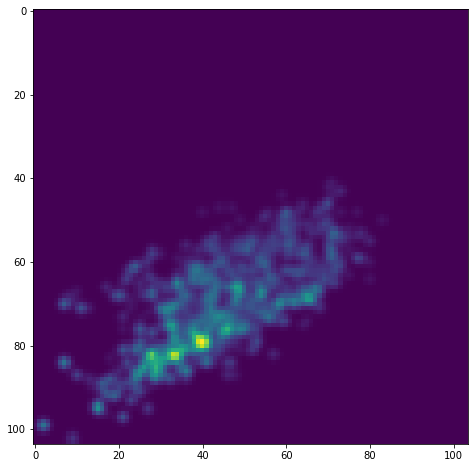

In-Silico GEX - Y-axis


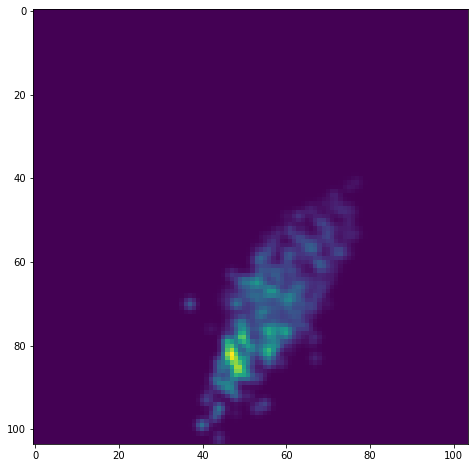

In-Silico GEX - Z-axis


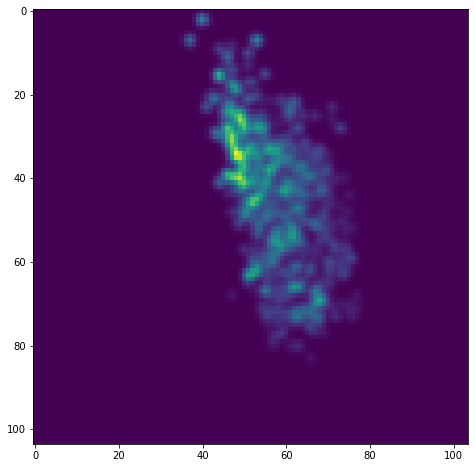

Tenm3
Real GEX


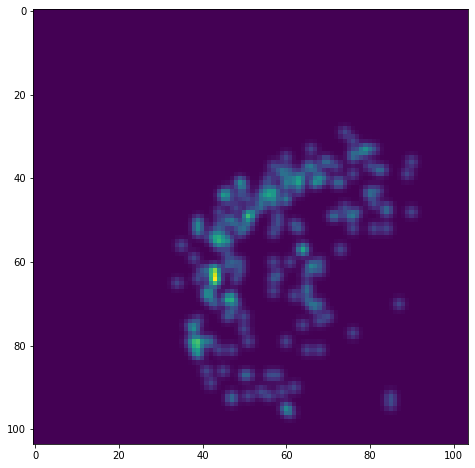

In-Silico GEX - X-axis


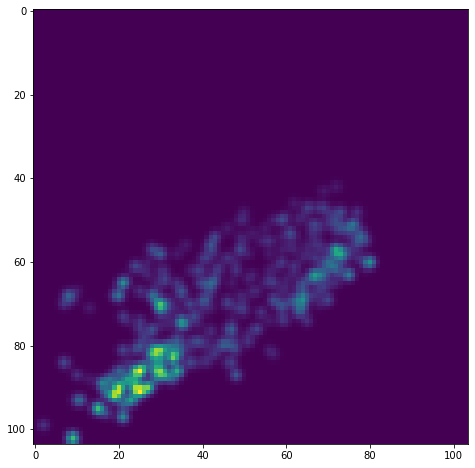

In-Silico GEX - Y-axis


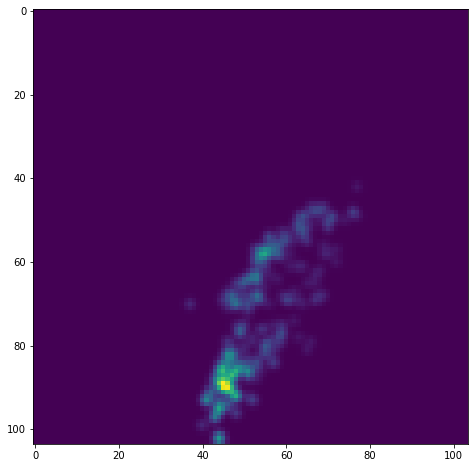

In-Silico GEX - Z-axis


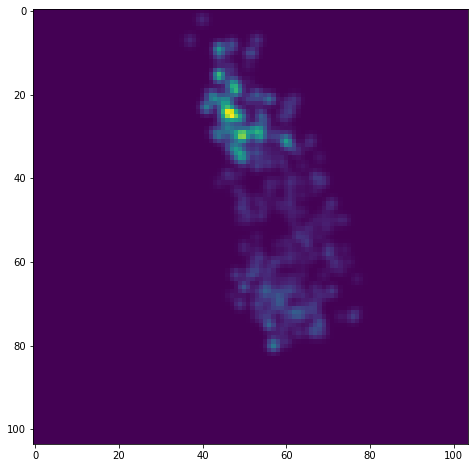

C1ql3
Real GEX


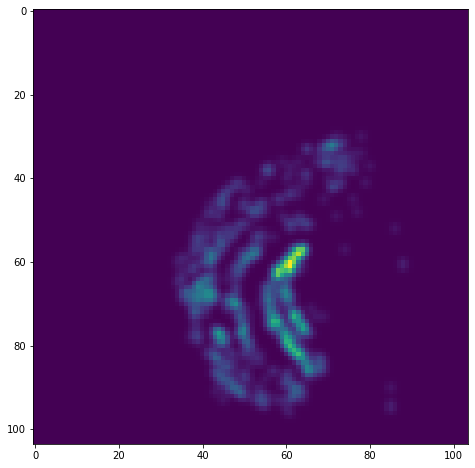

In-Silico GEX - X-axis


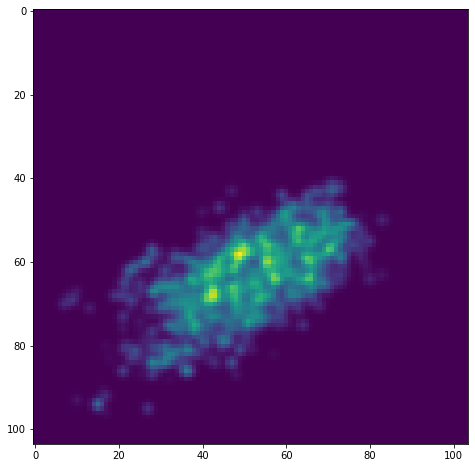

In-Silico GEX - Y-axis


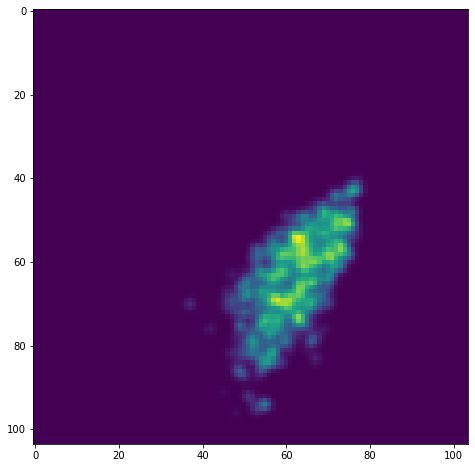

In-Silico GEX - Z-axis


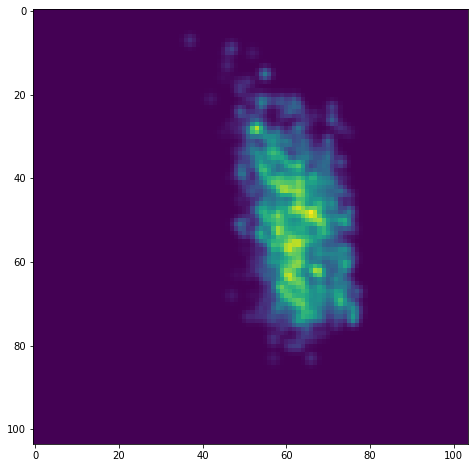

Dgkb
Real GEX


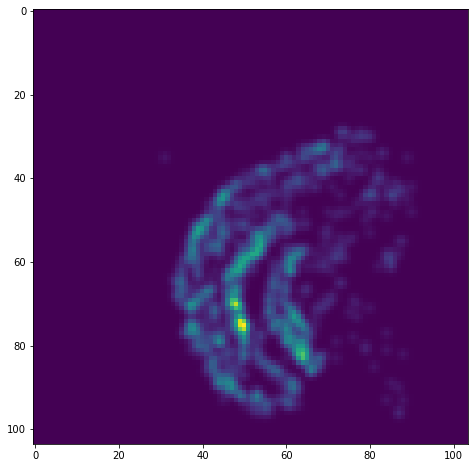

In-Silico GEX - X-axis


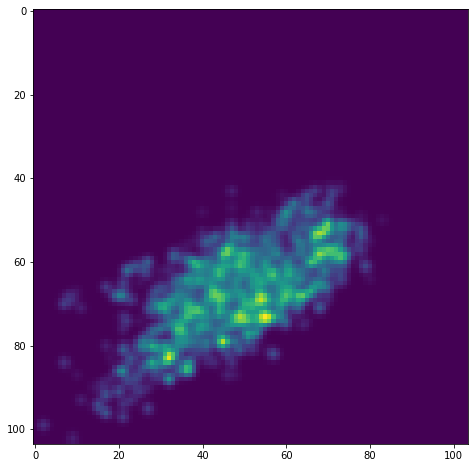

In-Silico GEX - Y-axis


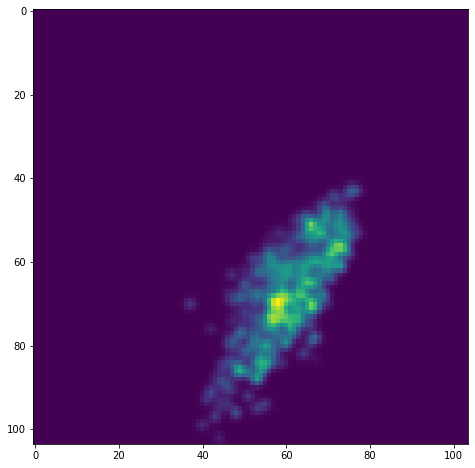

In-Silico GEX - Z-axis


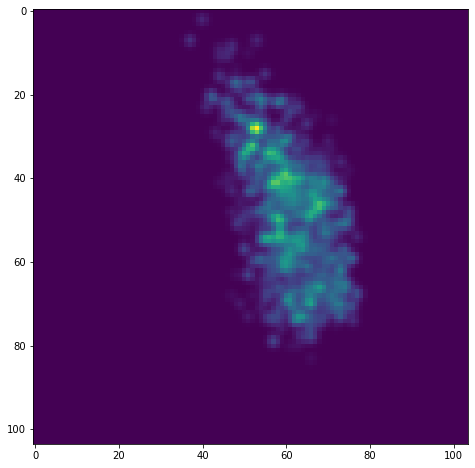

Cpne4
Real GEX


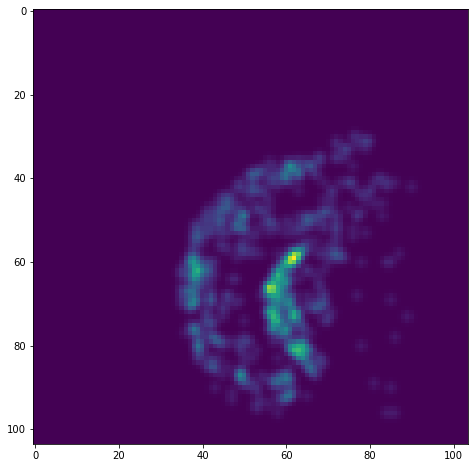

In-Silico GEX - X-axis


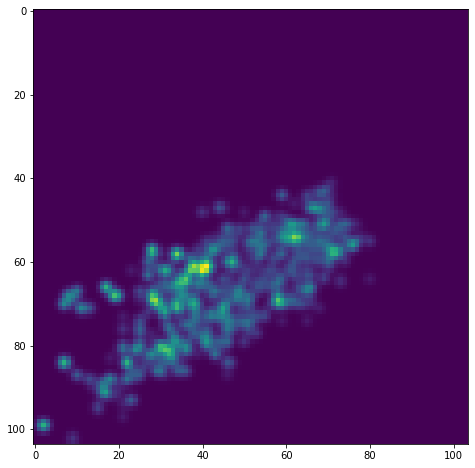

In-Silico GEX - Y-axis


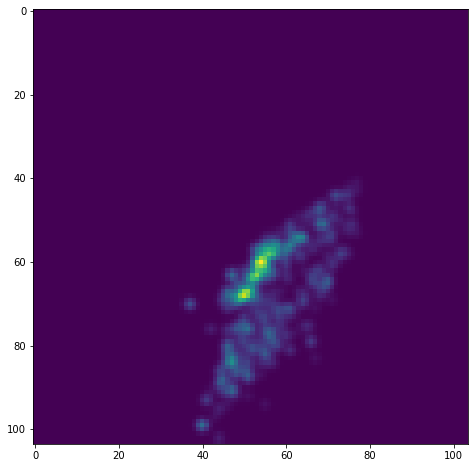

In-Silico GEX - Z-axis


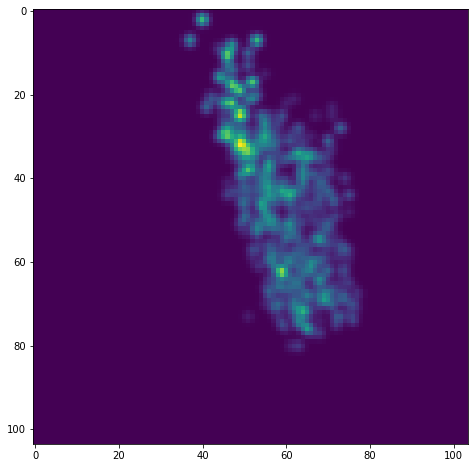

Hcn1
Real GEX


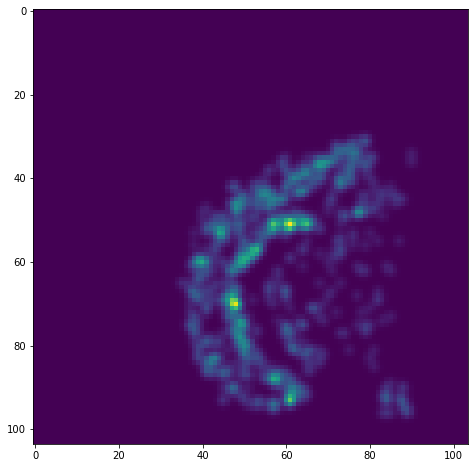

In-Silico GEX - X-axis


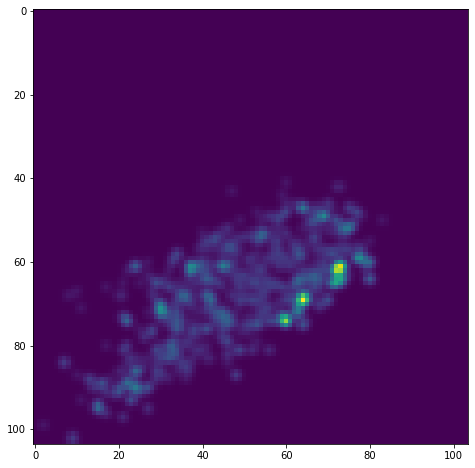

In-Silico GEX - Y-axis


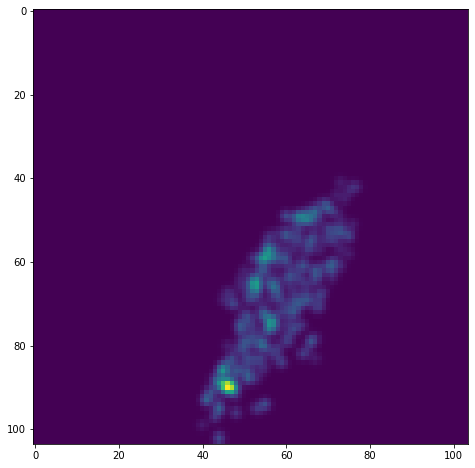

In-Silico GEX - Z-axis


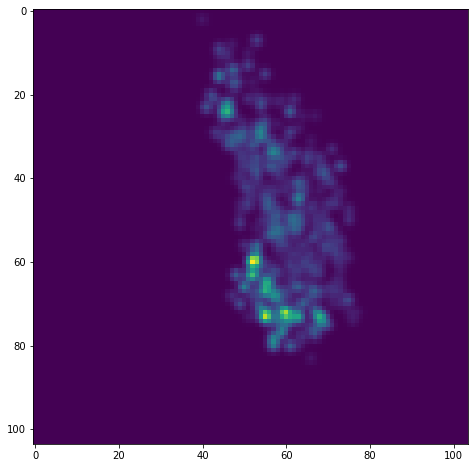

Cdh18
Real GEX


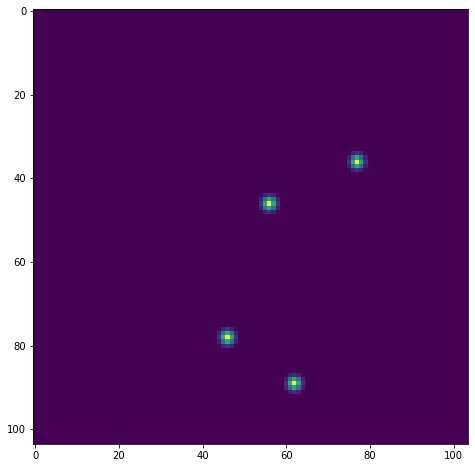

In-Silico GEX - X-axis


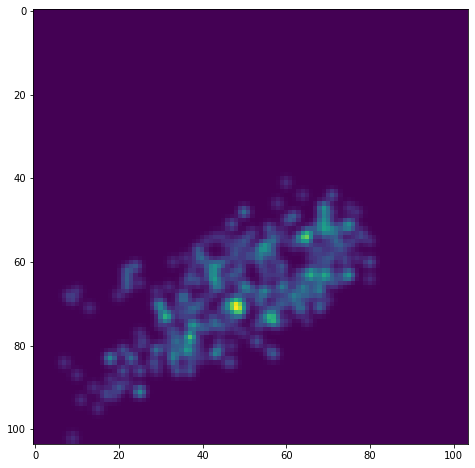

In-Silico GEX - Y-axis


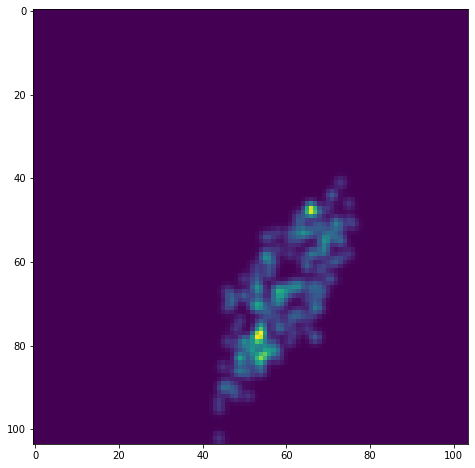

In-Silico GEX - Z-axis


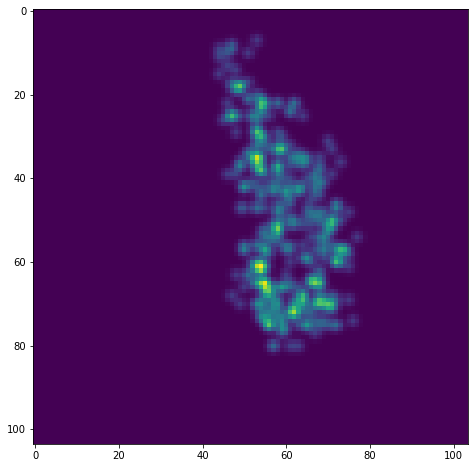

Gnb4
Real GEX


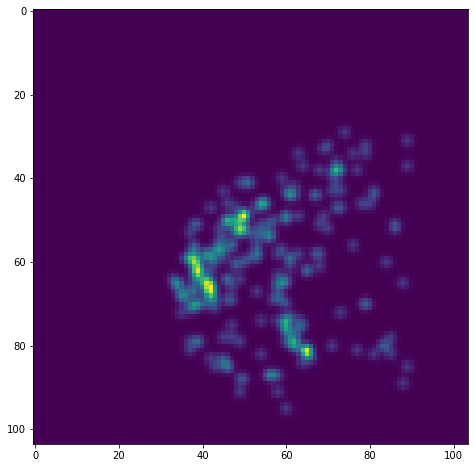

In-Silico GEX - X-axis


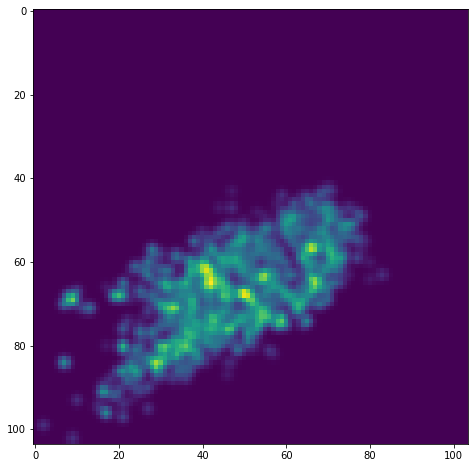

In-Silico GEX - Y-axis


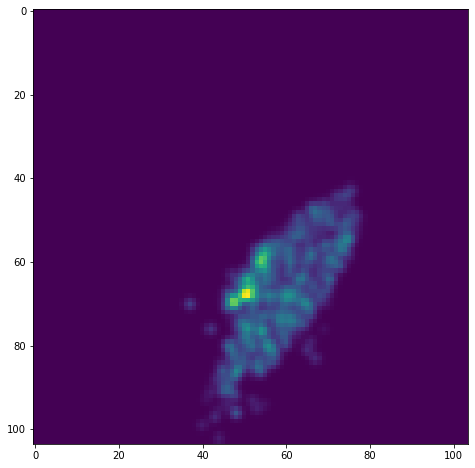

In-Silico GEX - Z-axis


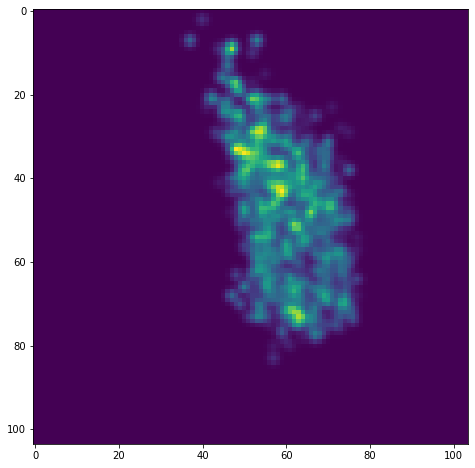

Slc17a7
Real GEX


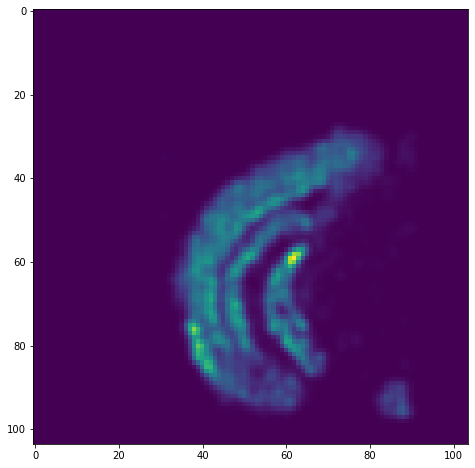

In-Silico GEX - X-axis


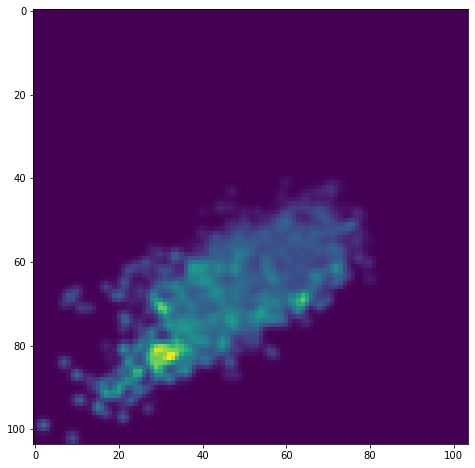

In-Silico GEX - Y-axis


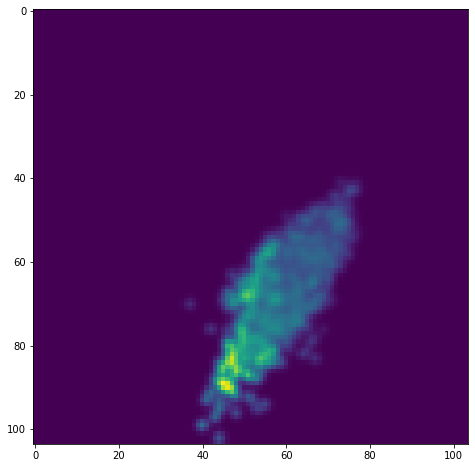

In-Silico GEX - Z-axis


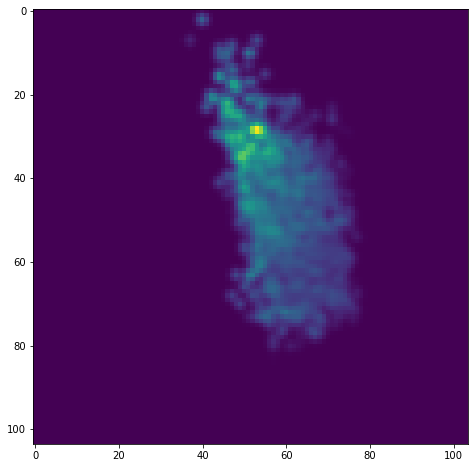

Gad1
Real GEX


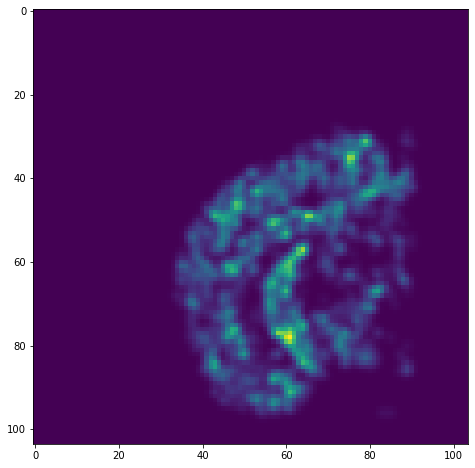

In-Silico GEX - X-axis


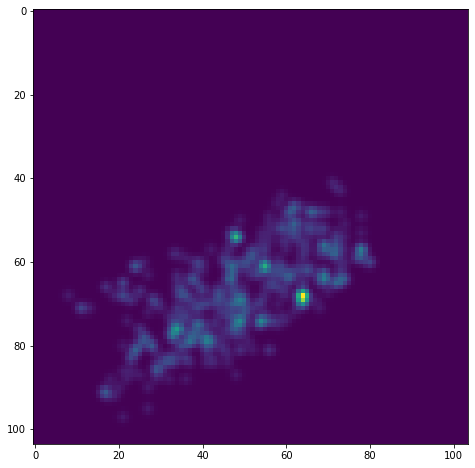

In-Silico GEX - Y-axis


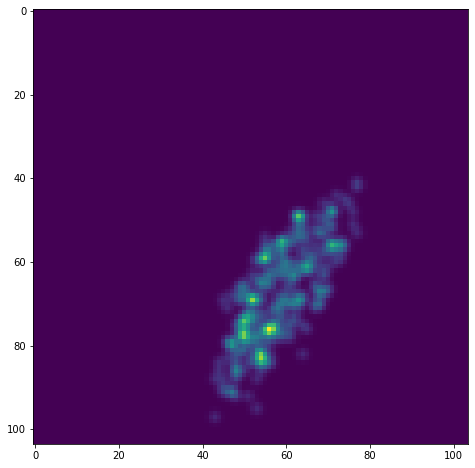

In-Silico GEX - Z-axis


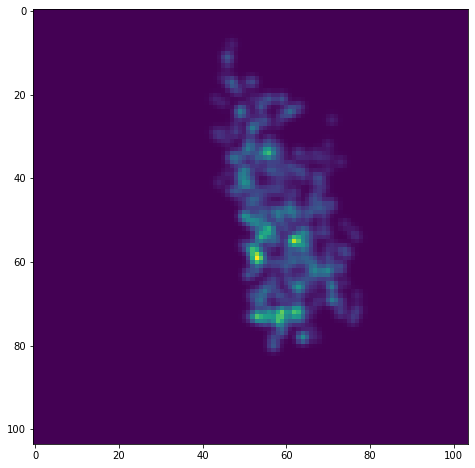

Slc30a3
Real GEX


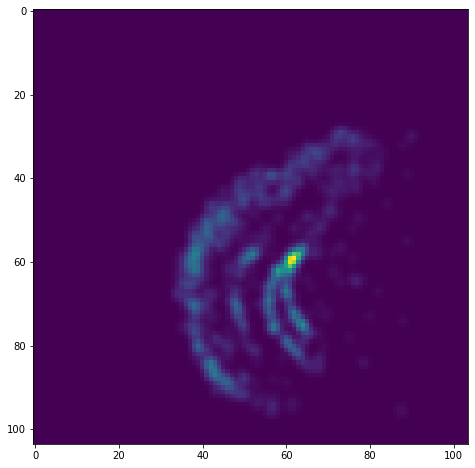

In-Silico GEX - X-axis


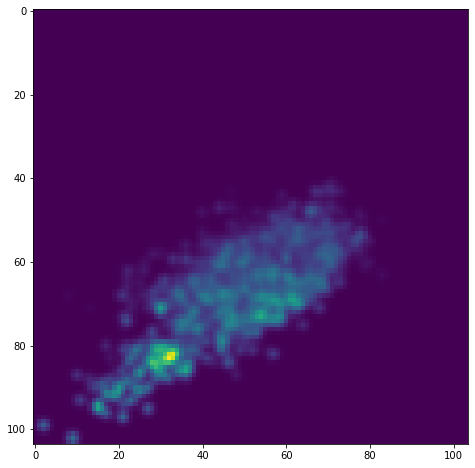

In-Silico GEX - Y-axis


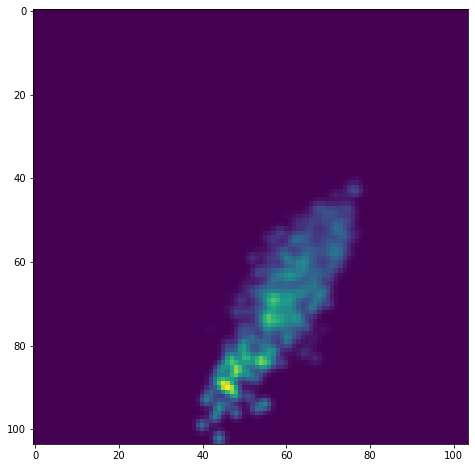

In-Silico GEX - Z-axis


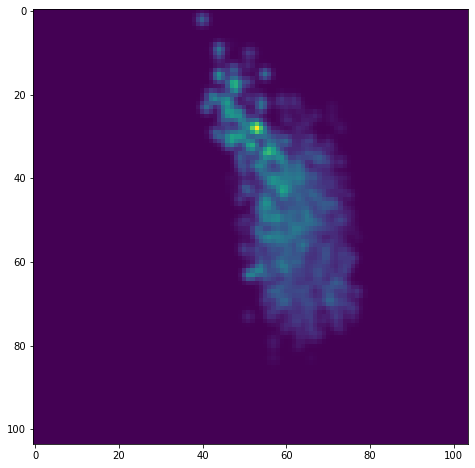

In [13]:

grid_return_list, ST_list, spatial_gex_list = net(x_list,gex_list,pixel_list)
    
for i in range(len(GRID_list)):
    grid_return_list[i+1][0][:,:2] = GRID_list[i]


    
main_axis_size = 200
    
kde_grid_new = []
for i in range(len(grid_return_list)):
    kde_grid_new += [[to_kde_grid(M_list[i],grid_return_list[i][0][:,:2].cpu().detach().numpy(),main_axis_size)]]


spatial_image = []
for i in range(1,len(kde_grid_new)):    
    main_histology = np.max((kde_grid_new[i][0].reshape([(main_axis_size+4*window_size)*(main_axis_size+4*window_size),len(genes)])@((spatial_gex_list[0][2].T).cpu().detach().numpy())).reshape([(main_axis_size+4*window_size),(main_axis_size+4*window_size),32,32,3]),(2,3))
    main_histology = (main_histology-np.min(main_histology))/np.max(main_histology-np.min(main_histology))
    spatial_image += [[main_histology]]

    
i=0

x = (to_kde_grid(M_list[i],(grid_return_list[i][0][:,[0,1]].cpu().detach().numpy()),main_axis_size))
y = (to_kde_grid(M_list[i],(grid_return_list[i][0][:,[0,2]].cpu().detach().numpy()),main_axis_size))
z = (to_kde_grid(M_list[i],(grid_return_list[i][0][:,[1,2]].cpu().detach().numpy()),main_axis_size))

image_x = np.max((x.reshape([(main_axis_size+4*window_size)*(main_axis_size+4*window_size),len(genes)])@((spatial_gex_list[0][2].T).cpu().detach().numpy())).reshape([(main_axis_size+4*window_size),(main_axis_size+4*window_size),32,32,3]),(2,3))
image_x = (image_x-np.min(image_x))/np.max(image_x-np.min(image_x))

image_y = np.max((y.reshape([(main_axis_size+4*window_size)*(main_axis_size+4*window_size),len(genes)])@((spatial_gex_list[0][2].T).cpu().detach().numpy())).reshape([(main_axis_size+4*window_size),(main_axis_size+4*window_size),32,32,3]),(2,3))
image_y = (image_y-np.min(image_y))/np.max(image_y-np.min(image_y))

image_z = np.max((z.reshape([(main_axis_size+4*window_size)*(main_axis_size+4*window_size),len(genes)])@((spatial_gex_list[0][2].T).cpu().detach().numpy())).reshape([(main_axis_size+4*window_size),(main_axis_size+4*window_size),32,32,3]),(2,3))
image_z = (image_z-np.min(image_z))/np.max(image_z-np.min(image_z))

print("In-Silico Histology Examples - X-axis")
plt.imshow(image_x)
plt.show()

print("In-Silico Histology Examples - Y-axis")
plt.imshow(image_y)
plt.show()

print("In-Silico Histology Examples - Z-axis")
plt.imshow(image_z)
plt.show()
                


for i in range(4):    
    print("Re-predicted images of Histology training dataset")
    plt.imshow(spatial_image[i][0])
    plt.show()
    




print("Plotting in-silico ST data via loss function optimisation through learning proper gene to pixel transformations and cell placement via KNN gene convolutions")
for i in range(len(genes)):
    print(genes[i])
    print("Real GEX")
    plt.imshow(kde_grid_new[1][0][:,:,i])
    plt.show()

    print("In-Silico GEX - X-axis")
    plt.imshow(x[:,:,i])
    plt.show()

    print("In-Silico GEX - Y-axis")
    plt.imshow(y[:,:,i])
    plt.show()

    print("In-Silico GEX - Z-axis")
    plt.imshow(z[:,:,i])
    plt.show()
              

    

